### "RQs" for analyzing URLs/domain names used for fetching video chunks:
##### Does the same domain name always resolve to the same IP address on a single vantage point?
- most subdomains map to one IP address
- on US West, 4 domain names map to two different IP addresses during the course of the measurement, however these  "alternate" addresses are only seen once for three of the subdomains and twice for the remaining one

##### When does the domain and/or IP address change? 
- the subdomain seems video ID specific, no clear pattern when it changes for a video itself but it seems to be ~ 40%-50% (depending on vantage point) chance for it to change between runs of the same video ID
- for south africa there appears to be a pattern based on time, where we have periods where pretty much every run uses a different subdomain
- for south africa there are a lot more subdomain changes during a measurement run
- the "sn" part appers to change a lot more frequently than the "rr" part across vantage points

##### Is there overlap in the CNAMEs within the domains used by a vantage point?
- no clear pattern based on IP address ranges when looking at "sn" part of the subdomain label; there is some overlap within a /24 sometimes but not always
- rr part stays relatively consistent, mostly 2 or 1 rr number (rr1, rr2) for a single sn (except for Japan where we find rr6)

##### Which googlevideo domain is used on which vantage point and with which IP address?
- the 4 domain names that map to two different IP addresses on US West do not appear on other vantage points
- 77 domain names only occur on one vantage point, except for the 4 above, they all map to one IP address
- 16 are found on two vantage points
- 67 IP addresses
    - 51 IP addresses are only resolved on a single vantage point
    - 16 are resolved on two vantage points
       
- 81 domain+IP combinations are only seen on a single vantage point (57 unique IP addresses, 77 unique domain names)
    - 22 domain name pairs resolve to the same ip address, 20 of which just have an "r" removed at the start
        - the 2 remaining ones are on US West:
            - rr2---sn-a5mekn6d.googlevideo.com.->173.194.8.199: 19
            - rr2---sn-o097znsr.googlevideo.com.->173.194.8.199: 1
            - 
            - rr4---sn-o097znse.googlevideo.com.->173.194.8.105: 1
            - rr4---sn-a5mekn6l.googlevideo.com.->173.194.8.105: 20
    - domain name count ==> 81 combinations - 4 US West domain names that map to diff IPs = 77 domain names
- 16 domain+IP combinations are seen on two vantage points (one to one mapping)
    - the mapping here is unique, every domain name corresponds to one IP

##### Overlap between vantage points, if domain names overlap, do IP addresses as well (and vice versa)?
- domain name overlap:
    - South America East, US East:                       8 times
    - Africa South, Europe Central:                      5 times
    - Asia Pacific Northeast, Asia Pacific Southeast:    3 times
    - they resolve to the same IP address on both vantage points

##### Assumption: this should be DNS protocol agnostic, and since we are only using a single resolver per vantage point, the only difference between runs could possibly result from requesting a different video ID (resolution is unllikely)
## Caveat: in this run we alternate between videos -> videos seem to have different sets of subdomains at least for the two we measure

In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
mpl.rcParams['figure.dpi'] = 100

In [2]:
conn = sqlite3.connect('first-msm-run-on-all-vms/web-performance-youtube-merged.db')

In [7]:
googlevideo_subdomains = pd.read_sql_query("SELECT * FROM page_resources", conn)
googlevideo_subdomains['googlevideo'] = googlevideo_subdomains.name.str.split('/').str[2]

In [9]:
lookups = pd.read_sql_query('SELECT * FROM lookups', conn)

In [5]:
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error
0,a019d80e-bda1-6022-2330-422d0ff0b319,-1,-1.000000e+00,-1.000000e+00,tls,154.0.173.6,aqz-KE-bpKQ,Africa South,2022-03-07 17:18:09.937705,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,failed loading player for cache warming ### Me...
1,ed2ebf9a-57a5-ed44-5b2a-012b8fb3755c,-1,-1.000000e+00,-1.000000e+00,tls,185.121.25.64,aqz-KE-bpKQ,Africa South,2022-03-07 17:22:38.140803,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
2,544b9c53-fb16-e2fe-5fb0-0268b693a586,1646673799468697071,1.646674e+12,1.646674e+12,tls,185.121.25.64,aqz-KE-bpKQ,Africa South,2022-03-07 17:22:43.846963,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
3,30b40159-f0f0-88d6-3bc6-a1ea77c5ef1f,-1,-1.000000e+00,-1.000000e+00,tls,185.121.25.64,lqiN98z6Dak,Africa South,2022-03-07 17:23:21.023793,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
4,7a1a699c-6c32-6b28-f8f1-cac46c3d96c8,1646673842497402384,1.646674e+12,1.646674e+12,tls,185.121.25.64,lqiN98z6Dak,Africa South,2022-03-07 17:23:26.657266,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115356,892bb7e6-6971-f8e2-dbad-f9193758c29c,1647109802531703775,1.647110e+12,1.647110e+12,udp,94.140.14.59,lqiN98z6Dak,US West,2022-03-12 18:29:29.181181,auto,2560,1440,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
115357,31c645c5-08b4-ebaf-9448-a759575f57d7,-1,-1.000000e+00,-1.000000e+00,udp,94.140.14.59,aqz-KE-bpKQ,US West,2022-03-12 18:30:07.431304,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
115358,651c800b-d38c-86f8-5228-bdbb1bf68384,1647109844114445223,1.647110e+12,1.647110e+12,udp,94.140.14.59,aqz-KE-bpKQ,US West,2022-03-12 18:30:10.764789,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
115359,8cbf089c-63bb-f1af-efce-73aca6d84a1f,-1,-1.000000e+00,-1.000000e+00,udp,94.140.14.59,lqiN98z6Dak,US West,2022-03-12 18:30:45.815109,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,


In [8]:
googlevideo_subdomains

,connectEnd,connectStart,decodedBodySize,domainLookupEnd,domainLookupStart,duration,encodedBodySize,entryType,fetchStart,initiatorType,name,nextHopProtocol,requestStart,responseEnd,responseStart,secureConnectionStart,startTime,transferSize,msm_id,googlevideo
0,23281.7,23281.7,1662363,23281.7,23281.7,229.6,1662363.0,resource,23281.7,xmlhttprequest,https://rr2---sn-5hnekn7z.googlevideo.com/vide...,h3,23282.3,23511.3,23448.1,23281.7,23281.7,1662663,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com
1,6977.4,6977.4,130893,6977.4,6977.4,175.4,130893.0,resource,6977.4,xmlhttprequest,https://rr2---sn-5hnekn7z.googlevideo.com/vide...,h3,6978.3,7152.8,7144.5,6977.4,6977.4,131193,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com
2,9531.6,9531.6,280215,9531.6,9531.6,187.2,280215.0,resource,9531.6,xmlhttprequest,https://rr2---sn-5hnekn7z.googlevideo.com/vide...,h3,9532.3,9718.8,9697.2,9531.6,9531.6,280515,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com
3,4356.7,4018.3,66880,4018.3,3867.0,836.9,66880.0,resource,3866.6,xmlhttprequest,https://rr2---sn-5hnekn7z.googlevideo.com/vide...,http/1.1,4356.8,4703.5,4527.6,4186.6,3866.6,67180,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com
4,5025.8,5025.8,65536,5025.8,5025.8,397.1,65536.0,resource,5025.8,xmlhttprequest,https://rr2---sn-5hnekn7z.googlevideo.com/vide...,h3,5026.4,5422.9,5190.7,5025.8,5025.8,65836,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811272,14152.8,14152.8,4410475,14152.8,14152.8,121.8,4410475.0,resource,14152.8,xmlhttprequest,https://rr4---sn-n4v7snl7.googlevideo.com/vide...,h3,14153.7,14274.6,14157.8,14152.8,14152.8,4410775,d26cd0d1-ce4e-c917-9f5f-d1a416ce98f1,rr4---sn-n4v7snl7.googlevideo.com
811273,11955.9,11955.9,4410475,11955.9,11955.9,108.8,4410475.0,resource,11955.9,xmlhttprequest,https://rr4---sn-n4v7snl7.googlevideo.com/vide...,h3,11956.6,12064.7,11959.7,11955.9,11955.9,4410775,d26cd0d1-ce4e-c917-9f5f-d1a416ce98f1,rr4---sn-n4v7snl7.googlevideo.com
811274,8319.3,8319.3,161758,8319.3,8319.3,6.8,161758.0,resource,8319.3,xmlhttprequest,https://rr4---sn-n4v7snl7.googlevideo.com/vide...,h3,8320.0,8326.1,8323.5,8319.3,8319.3,162058,d26cd0d1-ce4e-c917-9f5f-d1a416ce98f1,rr4---sn-n4v7snl7.googlevideo.com
811275,18835.6,18835.6,3814532,18835.6,18835.6,164.6,3814532.0,resource,18835.6,xmlhttprequest,https://rr4---sn-n4v7snl7.googlevideo.com/vide...,h3,18836.5,19000.2,18840.3,18835.6,18835.6,3814832,d26cd0d1-ce4e-c917-9f5f-d1a416ce98f1,rr4---sn-n4v7snl7.googlevideo.com


In [22]:
lookups = lookups[lookups.domain.str.endswith('googlevideo.com.')].copy()

In [23]:
lookups.rename(columns=lambda x: x.replace('measurement_id', 'msm_id'), inplace=True)

In [16]:
lookups[lookups.status == 'SERVFAIL'].answer.unique()

array(['read udp 172.31.27.22:39745->185.121.25.64:53: i/o timeout',
       'read udp 172.31.42.48:60092->202.218.2.19:53: i/o timeout',
       'failed to read response from quic://94.140.15.15:784 due to Application error 0x0, cause: Application error 0x0',
       'read udp 172.31.32.114:57967->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:38146->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:33468->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:44103->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:43613->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:53034->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:55190->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:34535->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:43015->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:34452->94.140.15.15:53: i/o timeout',
       'read udp 172.31.32.114:43213->94.140.15.15:

In [25]:
lookups[lookups.status == 'SERVFAIL'].msm_id.unique()

array(['8c063aa3-50a8-911d-f8d6-4d3dbbc1d359',
       '4e20dce8-f676-71f1-e2f0-0d25b506dbf1',
       '46b41ae2-7728-22fc-3cc9-fe27354f0418',
       '2a351d9b-71e7-e57b-6d6c-11367082ff97',
       '4b8d196d-d6d7-ccd2-af0d-37b028d793dc',
       '2a4f4d4d-29f5-700f-bc19-a5a526e50357',
       '6ba9d8ef-e2d5-2a24-a350-57b5fbb454a7',
       '0fdddd03-7d48-d51a-d3bd-b2d4aad88fa3',
       'be154033-e67a-e62d-7a2f-3529c428724f',
       'd12e2547-0d10-d765-c4de-ea50c6a98703',
       'a7662419-1d7f-a7cc-9b68-58167810ef54',
       '09f35412-60bc-4578-d7bf-de6e90abed67',
       '69b1634b-9161-5999-7285-f72747171c6b',
       '4247e9d7-a4cd-ef57-b492-fcf88bd55b6a',
       '5a7169f3-0e76-f242-2a16-c66a3b24b735',
       '40de5e49-5182-26a6-bbbf-f6fdc6065ca4',
       '5576cfe8-98c8-1734-6cb0-3fb7e850390d',
       'd992d1df-643b-a26c-869e-d0429764b667',
       '23e7f2fb-4354-6105-0500-48be31f8cb5f',
       '847adfbd-4c13-0b91-b0fb-15c4b1eefd5e',
       'd806da72-8c97-671a-6db6-71b05337bd26',
       '498bf

In [26]:
lookups[(lookups.msm_id.isin(lookups[lookups.status == 'SERVFAIL'].msm_id.unique())) & (lookups.status != 'SERVFAIL')]

,msm_id,domain,elapsed,status,answer
102490,8c063aa3-50a8-911d-f8d6-4d3dbbc1d359,rr2---sn-woc7ln7y.googlevideo.com.,150.277283,NOERROR,"rr2---sn-woc7ln7y.googlevideo.com.,628,IN,CNAM..."
102491,8c063aa3-50a8-911d-f8d6-4d3dbbc1d359,rr4---sn-woc7ln7y.googlevideo.com.,142.086719,NOERROR,"rr4---sn-woc7ln7y.googlevideo.com.,1028,IN,CNA..."
102493,8c063aa3-50a8-911d-f8d6-4d3dbbc1d359,rr2---sn-5hnekn7z.googlevideo.com.,152.655140,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,1005,IN,CNA..."
102494,8c063aa3-50a8-911d-f8d6-4d3dbbc1d359,rr2---sn-5hne6nsr.googlevideo.com.,146.238625,NOERROR,"rr2---sn-5hne6nsr.googlevideo.com.,642,IN,CNAM..."
214333,4e20dce8-f676-71f1-e2f0-0d25b506dbf1,rr6---sn-3pm7sn7y.googlevideo.com.,2.051518,NOERROR,"rr6---sn-3pm7sn7y.googlevideo.com.,376,IN,CNAM..."
...,...,...,...,...,...
693230,1022d240-c617-98be-0090-4c2ae05312ae,rr4---sn-p5qlsn76.googlevideo.com.,7.247991,NOERROR,"rr4---sn-p5qlsn76.googlevideo.com.,1348,IN,CNA..."
709241,289e7d65-e7e2-d624-a980-22bd6646a6f2,rr4---sn-p5qs7n7d.googlevideo.com.,7.346006,NOERROR,"rr4---sn-p5qs7n7d.googlevideo.com.,1135,IN,CNA..."
709242,289e7d65-e7e2-d624-a980-22bd6646a6f2,rr4---sn-p5qlsn76.googlevideo.com.,7.237861,NOERROR,"rr4---sn-p5qlsn76.googlevideo.com.,59,IN,CNAME..."
711511,9f2d094c-2b7d-4d51-90d1-a260bb78dcf7,rr4---sn-p5qlsn76.googlevideo.com.,7.250123,NOERROR,"rr4---sn-p5qlsn76.googlevideo.com.,777,IN,CNAM..."


In [27]:
lookups[(lookups.msm_id.isin(lookups[lookups.status == 'SERVFAIL'].msm_id.unique())) & (lookups.status == 'SERVFAIL')]

,msm_id,domain,elapsed,status,answer
102495,8c063aa3-50a8-911d-f8d6-4d3dbbc1d359,rr2---sn-5hne6nsr.googlevideo.com.,10002.268395,SERVFAIL,read udp 172.31.27.22:39745->185.121.25.64:53:...
214336,4e20dce8-f676-71f1-e2f0-0d25b506dbf1,rr6---sn-oguesnz6.googlevideo.com.,10001.679703,SERVFAIL,read udp 172.31.42.48:60092->202.218.2.19:53: ...
243782,46b41ae2-7728-22fc-3cc9-fe27354f0418,rr2---sn-ntq7yned.googlevideo.com.,31976.263346,SERVFAIL,failed to read response from quic://94.140.15....
243783,46b41ae2-7728-22fc-3cc9-fe27354f0418,rr2---sn-ntq7yned.googlevideo.com.,8334.104645,SERVFAIL,failed to read response from quic://94.140.15....
243784,46b41ae2-7728-22fc-3cc9-fe27354f0418,rr2---sn-oguelnss.googlevideo.com.,7341.614301,SERVFAIL,failed to read response from quic://94.140.15....
...,...,...,...,...,...
688073,b3963a27-ad32-8e81-5b72-a4312f4b4087,rr2---sn-p5qddn7k.googlevideo.com.,10002.689707,SERVFAIL,read udp 172.31.18.219:43342->94.140.14.14:53:...
690913,a43ca90d-4761-90cc-51c2-8c099e6027f7,rr4---sn-p5qs7n7d.googlevideo.com.,10003.956476,SERVFAIL,read udp 172.31.18.219:54076->94.140.14.14:53:...
693232,1022d240-c617-98be-0090-4c2ae05312ae,rr4---sn-p5qlsn76.googlevideo.com.,10000.455655,SERVFAIL,read udp 172.31.18.219:49271->94.140.14.14:53:...
709244,289e7d65-e7e2-d624-a980-22bd6646a6f2,rr4---sn-p5qlsn76.googlevideo.com.,10000.438893,SERVFAIL,read udp 172.31.18.219:47444->94.140.14.14:53:...


In [34]:
measurements[measurements.msm_id.isin(lookups[lookups.status == 'SERVFAIL'].msm_id.unique())].sort_values('timestamp')

,msm_id,py_time,js_time,resource_time_origin,protocol,server,domain,vantagePoint,timestamp,suggested_quality,player_width,player_height,start_time,play_time,video_ids,cacheWarming,error
82554,87a5c79e-31ce-f699-c750-f61ccc7f44de,1646679886987677748,1.646680e+12,1.646680e+12,udp,94.140.14.14,aqz-KE-bpKQ,US East,2022-03-07 19:04:12.951920,auto,2560,1440,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
66386,40de5e49-5182-26a6-bbbf-f6fdc6065ca4,1646688243245388403,1.646688e+12,1.646688e+12,udp,94.140.14.14,aqz-KE-bpKQ,South America East,2022-03-07 21:23:28.256389,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
66394,5576cfe8-98c8-1734-6cb0-3fb7e850390d,1646688415411241843,1.646688e+12,1.646688e+12,udp,94.140.14.14,aqz-KE-bpKQ,South America East,2022-03-07 21:26:20.395562,auto,2560,1440,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
66480,d992d1df-643b-a26c-869e-d0429764b667,1646690657150221448,1.646691e+12,1.646691e+12,udp,94.140.14.14,lqiN98z6Dak,South America East,2022-03-07 22:03:42.007723,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
66558,23e7f2fb-4354-6105-0500-48be31f8cb5f,1646692706300049378,1.646693e+12,1.646693e+12,udp,94.140.14.14,aqz-KE-bpKQ,South America East,2022-03-07 22:37:51.314072,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
33727,46b41ae2-7728-22fc-3cc9-fe27354f0418,-1,-1.000000e+00,-1.000000e+00,quic,94.140.15.15,lqiN98z6Dak,Asia Pacific Southeast,2022-03-07 23:36:49.267322,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",1,
66706,847adfbd-4c13-0b91-b0fb-15c4b1eefd5e,1646696642139818660,1.646697e+12,1.646697e+12,udp,94.140.14.14,aqz-KE-bpKQ,South America East,2022-03-07 23:43:27.152193,auto,1280,720,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
66718,d806da72-8c97-671a-6db6-71b05337bd26,1646696900982098133,1.646697e+12,1.646697e+12,udp,94.140.14.14,aqz-KE-bpKQ,South America East,2022-03-07 23:47:45.939577,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
66798,498bf81e-9dff-15a0-9bac-7fd29fe8cfa8,1646699317332733828,1.646699e+12,1.646699e+12,udp,94.140.14.14,aqz-KE-bpKQ,South America East,2022-03-08 00:28:02.366458,auto,3840,2160,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,
83752,f77df5ae-4133-19fb-7228-d2fbc038f145,1646711643841548462,1.646712e+12,1.646712e+12,udp,94.140.14.14,lqiN98z6Dak,US East,2022-03-08 03:53:30.190985,auto,1920,1080,0,30,"aqz-KE-bpKQ, lqiN98z6Dak",0,


In [35]:
measurements[measurements.msm_id.isin(lookups[lookups.status == 'SERVFAIL'].msm_id.unique())].vantagePoint.unique()

array(['Africa South', 'Asia Pacific Northeast', 'Asia Pacific Southeast',
       'South America East', 'US East'], dtype=object)

In [389]:
measurements.rename(columns=lambda x: x.replace('domain', 'video_id'), inplace=True)

In [390]:
measurements = measurements[measurements.cacheWarming == 0]

In [391]:
lookups['ip_addr'] = lookups['answer'].str.split(',').str[-1].str[:-1]

In [392]:
lookups['round_robin_str'] = lookups['domain'].str.split('---').str[0]
lookups['rand_sn_str'] = lookups['domain'].str.split('---').str[1].str.split('.').str[0]
lookups['video_subdomain'] = lookups['domain'].str.split('.').str[0]
lookups['subdomain_and_ip'] = lookups['video_subdomain'] + '-' + lookups['ip_addr']

In [394]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

/tmp/ipykernel_17564/851542379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurements['player_width'] = measurements['player_width'].astype(str)
/tmp/ipykernel_17564/851542379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurements['player_height'] = measurements['player_height'].astype(str)
/tmp/ipykernel_17564/851542379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [395]:
googlevideo_subdomains = pd.merge(googlevideo_subdomains, measurements[['msm_id', 'resource_time_origin']], on='msm_id')

In [396]:
googlevideo_subdomains['time'] = googlevideo_subdomains['startTime'] + googlevideo_subdomains['resource_time_origin']
googlevideo_subdomains['time'] = pd.to_datetime(googlevideo_subdomains['time'], unit='ms', origin='unix')

In [397]:
googlevideo_requests = googlevideo_subdomains[['time', 'googlevideo', 'msm_id']]

In [398]:
measurements['timestamp'] = pd.to_datetime(measurements['timestamp'])

/tmp/ipykernel_17564/2509173728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measurements['timestamp'] = pd.to_datetime(measurements['timestamp'])


In [399]:
googlevideo_requests = googlevideo_requests.groupby(['msm_id', 'googlevideo'], as_index=False).agg(first_time_seen=('time', np.min))
googlevideo_requests

,msm_id,googlevideo,first_time_seen
0,0000c85d-710c-e4df-8f0d-f4bc64dbac17,rr4---sn-woc7ln7y.googlevideo.com,2022-03-10 04:26:46.676499968
1,0000ca8c-557d-f4c0-f38f-9ab4f628316f,rr2---sn-bg07dn6r.googlevideo.com,2022-03-08 11:56:15.918500096
2,00011cc2-bc8e-214c-20b9-4a29610cbdfc,rr4---sn-o097znse.googlevideo.com,2022-03-12 03:48:05.934899968
3,0001402c-2c01-8135-e4c9-a91107183767,rr6---sn-3pm7sn7y.googlevideo.com,2022-03-10 16:55:10.593600000
4,00016162-7fd0-7bad-e433-9b925952d80e,rr4---sn-bg07dnsl.googlevideo.com,2022-03-09 13:15:48.470800128
...,...,...,...
60874,fffb4bf1-cf69-04c9-0bb1-c6546f2571e4,rr2---sn-ntqe6nez.googlevideo.com,2022-03-09 15:13:06.945100032
60875,fffbc4d3-c081-c9e3-8970-aae83393cf3e,rr4---sn-bg07dnsl.googlevideo.com,2022-03-09 03:20:43.786100224
60876,fffead2c-a9a9-4ad7-b84d-402e40fcee08,rr2---sn-bg07dn6r.googlevideo.com,2022-03-10 04:44:35.814700032
60877,ffff298b-3fff-8159-9ac6-036e0e494386,rr2---sn-ntqe6nez.googlevideo.com,2022-03-11 02:36:09.247200000


In [402]:
googlevideo_requests['domain'] = googlevideo_requests['googlevideo'] + '.'
googlevideo_requests

,msm_id,googlevideo,first_time_seen,domain
0,0000c85d-710c-e4df-8f0d-f4bc64dbac17,rr4---sn-woc7ln7y.googlevideo.com,2022-03-10 04:26:46.676499968,rr4---sn-woc7ln7y.googlevideo.com.
1,0000ca8c-557d-f4c0-f38f-9ab4f628316f,rr2---sn-bg07dn6r.googlevideo.com,2022-03-08 11:56:15.918500096,rr2---sn-bg07dn6r.googlevideo.com.
2,00011cc2-bc8e-214c-20b9-4a29610cbdfc,rr4---sn-o097znse.googlevideo.com,2022-03-12 03:48:05.934899968,rr4---sn-o097znse.googlevideo.com.
3,0001402c-2c01-8135-e4c9-a91107183767,rr6---sn-3pm7sn7y.googlevideo.com,2022-03-10 16:55:10.593600000,rr6---sn-3pm7sn7y.googlevideo.com.
4,00016162-7fd0-7bad-e433-9b925952d80e,rr4---sn-bg07dnsl.googlevideo.com,2022-03-09 13:15:48.470800128,rr4---sn-bg07dnsl.googlevideo.com.
...,...,...,...,...
60874,fffb4bf1-cf69-04c9-0bb1-c6546f2571e4,rr2---sn-ntqe6nez.googlevideo.com,2022-03-09 15:13:06.945100032,rr2---sn-ntqe6nez.googlevideo.com.
60875,fffbc4d3-c081-c9e3-8970-aae83393cf3e,rr4---sn-bg07dnsl.googlevideo.com,2022-03-09 03:20:43.786100224,rr4---sn-bg07dnsl.googlevideo.com.
60876,fffead2c-a9a9-4ad7-b84d-402e40fcee08,rr2---sn-bg07dn6r.googlevideo.com,2022-03-10 04:44:35.814700032,rr2---sn-bg07dn6r.googlevideo.com.
60877,ffff298b-3fff-8159-9ac6-036e0e494386,rr2---sn-ntqe6nez.googlevideo.com,2022-03-11 02:36:09.247200000,rr2---sn-ntqe6nez.googlevideo.com.


In [403]:
lookups

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip
13,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com.,152.211291,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,699,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103
27,7a1a699c-6c32-6b28-f8f1-cac46c3d96c8,rr4---sn-5hnekn7k.googlevideo.com.,149.194440,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,627,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73
41,e2576b0d-50a9-f803-e475-4d880109c675,rr2---sn-5hnekn7z.googlevideo.com.,142.190267,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,610,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103
57,22cb024f-8247-54be-730f-b2b57f8a4074,rr4---sn-5hnekn7k.googlevideo.com.,171.337583,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,538,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73
72,150bdff4-3e93-9c75-8236-5c550ea665e1,rr2---sn-5hnekn7z.googlevideo.com.,150.356304,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,521,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103
...,...,...,...,...,...,...,...,...,...,...
830821,3c7e0c54-cae9-53bd-6256-b9189b271137,rr4---sn-n4v7snl7.googlevideo.com.,9.886096,NOERROR,"rr4---sn-n4v7snl7.googlevideo.com.,860,IN,CNAM...",74.125.103.137,rr4,sn-n4v7snl7,rr4---sn-n4v7snl7,rr4---sn-n4v7snl7-74.125.103.137
830835,2cf02006-5094-efc4-77ec-750435ef9ad0,rr2---sn-o097znsr.googlevideo.com.,12.252375,NOERROR,"rr2---sn-o097znsr.googlevideo.com.,1041,IN,CNA...",173.194.8.7,rr2,sn-o097znsr,rr2---sn-o097znsr,rr2---sn-o097znsr-173.194.8.7
830849,892bb7e6-6971-f8e2-dbad-f9193758c29c,rr4---sn-o097znse.googlevideo.com.,8.844368,NOERROR,"rr4---sn-o097znse.googlevideo.com.,666,IN,CNAM...",74.125.166.41,rr4,sn-o097znse,rr4---sn-o097znse,rr4---sn-o097znse-74.125.166.41
830864,651c800b-d38c-86f8-5228-bdbb1bf68384,rr2---sn-n4v7sney.googlevideo.com.,8.729008,NOERROR,"rr2---sn-n4v7sney.googlevideo.com.,179,IN,CNAM...",74.125.103.39,rr2,sn-n4v7sney,rr2---sn-n4v7sney,rr2---sn-n4v7sney-74.125.103.39


In [404]:
lookups = pd.merge(lookups, googlevideo_requests, on=['msm_id', 'domain'])
lookups

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen
0,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com.,152.211291,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,699,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:22:49.099600128
1,7a1a699c-6c32-6b28-f8f1-cac46c3d96c8,rr4---sn-5hnekn7k.googlevideo.com.,149.194440,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,627,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73,rr4---sn-5hnekn7k.googlevideo.com,2022-03-07 17:23:32.022299904
2,e2576b0d-50a9-f803-e475-4d880109c675,rr2---sn-5hnekn7z.googlevideo.com.,142.190267,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,610,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:24:18.062300160
3,22cb024f-8247-54be-730f-b2b57f8a4074,rr4---sn-5hnekn7k.googlevideo.com.,171.337583,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,538,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73,rr4---sn-5hnekn7k.googlevideo.com,2022-03-07 17:25:02.213599744
4,150bdff4-3e93-9c75-8236-5c550ea665e1,rr2---sn-5hnekn7z.googlevideo.com.,150.356304,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,521,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:25:47.131300096
...,...,...,...,...,...,...,...,...,...,...,...,...
60954,3c7e0c54-cae9-53bd-6256-b9189b271137,rr4---sn-n4v7snl7.googlevideo.com.,9.886096,NOERROR,"rr4---sn-n4v7snl7.googlevideo.com.,860,IN,CNAM...",74.125.103.137,rr4,sn-n4v7snl7,rr4---sn-n4v7snl7,rr4---sn-n4v7snl7-74.125.103.137,rr4---sn-n4v7snl7.googlevideo.com,2022-03-12 18:28:17.776300032
60955,2cf02006-5094-efc4-77ec-750435ef9ad0,rr2---sn-o097znsr.googlevideo.com.,12.252375,NOERROR,"rr2---sn-o097znsr.googlevideo.com.,1041,IN,CNA...",173.194.8.7,rr2,sn-o097znsr,rr2---sn-o097znsr,rr2---sn-o097znsr-173.194.8.7,rr2---sn-o097znsr.googlevideo.com,2022-03-12 18:28:53.731100160
60956,892bb7e6-6971-f8e2-dbad-f9193758c29c,rr4---sn-o097znse.googlevideo.com.,8.844368,NOERROR,"rr4---sn-o097znse.googlevideo.com.,666,IN,CNAM...",74.125.166.41,rr4,sn-o097znse,rr4---sn-o097znse,rr4---sn-o097znse-74.125.166.41,rr4---sn-o097znse.googlevideo.com,2022-03-12 18:29:31.903500032
60957,651c800b-d38c-86f8-5228-bdbb1bf68384,rr2---sn-n4v7sney.googlevideo.com.,8.729008,NOERROR,"rr2---sn-n4v7sney.googlevideo.com.,179,IN,CNAM...",74.125.103.39,rr2,sn-n4v7sney,rr2---sn-n4v7sney,rr2---sn-n4v7sney-74.125.103.39,rr2---sn-n4v7sney.googlevideo.com,2022-03-12 18:30:13.217699840


In [405]:
lookups['ip_addr/24'] = lookups['ip_addr'].str.rsplit('.',1).str[0]
lookups['ip_addr/16'] = lookups['ip_addr'].str.rsplit('.',2).str[0]

In [428]:
lookups[lookups.video_subdomain == 'redirector']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16
2893,ca22505b-3797-9b9e-295f-67688c18ee09,redirector.googlevideo.com.,148.308688,NOERROR,"redirector.googlevideo.com.,124,IN,A,142.250.1...",142.250.187.238,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.187.238,redirector.googlevideo.com,2022-03-09 00:35:58.696000000,142.250.187,142.250
4151,6583d20e-b07c-b967-0f46-597acd192576,redirector.googlevideo.com.,148.539392,NOERROR,"redirector.googlevideo.com.,255,IN,A,142.250.1...",142.250.187.238,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.187.238,redirector.googlevideo.com,2022-03-09 11:49:15.807700224,142.250.187,142.250
8979,22842c55-c7f2-3f86-c3f2-f505be338bba,redirector.googlevideo.com.,164.137688,NOERROR,"redirector.googlevideo.com.,218,IN,A,172.217.1...",172.217.169.78,redirector.googlevideo.com.,NaN,redirector,redirector-172.217.169.78,redirector.googlevideo.com,2022-03-11 15:34:50.802700032,172.217.169,172.217
9176,c16fc6c5-1419-2eb3-1e9e-5a385e13e24a,redirector.googlevideo.com.,300.500607,NOERROR,"redirector.googlevideo.com.,105,IN,A,142.250.1...",142.250.180.14,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.180.14,redirector.googlevideo.com,2022-03-11 18:26:46.792900096,142.250.180,142.250
9580,0cc1c590-62d5-4ace-e16c-87aecffcef54,redirector.googlevideo.com.,162.473625,NOERROR,"redirector.googlevideo.com.,143,IN,A,142.250.1...",142.250.187.206,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.187.206,redirector.googlevideo.com,2022-03-11 23:36:35.924799744,142.250.187,142.250
9960,bd03c8e8-1921-d1f6-e1fb-745296688c9c,redirector.googlevideo.com.,155.717689,NOERROR,"redirector.googlevideo.com.,80,IN,A,172.217.16...",172.217.169.14,redirector.googlevideo.com.,NaN,redirector,redirector-172.217.169.14,redirector.googlevideo.com,2022-03-12 03:24:08.085400064,172.217.169,172.217
11144,1e427b6a-49a0-a8bb-6c0f-04f5757fa7d8,redirector.googlevideo.com.,153.084218,NOERROR,"redirector.googlevideo.com.,159,IN,A,142.250.1...",142.250.180.14,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.180.14,redirector.googlevideo.com,2022-03-12 17:39:14.036200192,142.250.180,142.250
14131,edc94675-6463-5971-8321-49601de0c588,redirector.googlevideo.com.,20.159757,NOERROR,"redirector.googlevideo.com.,286,IN,A,216.58.22...",216.58.220.142,redirector.googlevideo.com.,NaN,redirector,redirector-216.58.220.142,redirector.googlevideo.com,2022-03-09 12:33:26.087800064,216.58.220,216.58
20579,16f332e1-a9e6-3872-3128-e23cde754c17,redirector.googlevideo.com.,185.362536,NOERROR,"redirector.googlevideo.com.,15,IN,A,74.125.24....",74.125.24.100,redirector.googlevideo.com.,NaN,redirector,redirector-74.125.24.100,redirector.googlevideo.com,2022-03-08 10:12:39.191200000,74.125.24,74.125
21921,4e83db4e-53c8-9032-e224-8f01fb970b78,redirector.googlevideo.com.,94.121297,NOERROR,"redirector.googlevideo.com.,282,IN,A,74.125.24...",74.125.24.100,redirector.googlevideo.com.,NaN,redirector,redirector-74.125.24.100,redirector.googlevideo.com,2022-03-09 05:43:16.925299968,74.125.24,74.125


In [472]:
lookups[lookups.status == 'NOERROR'].groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r1---sn-1gi7znek,1,74.125.108.198
66,rr4---sn-a5mekn6d,1,173.194.8.201
65,rr4---sn-5hnekn7k,1,209.85.226.73
64,rr4---sn-5hnedn7e,1,74.125.100.138
63,rr4---sn-5hne6nz6,1,74.125.100.201
...,...,...,...
78,rr4---sn-o097znse,2,"[74.125.166.41, 173.194.8.105]"
36,rr2---sn-a5mekn6d,2,"[173.194.8.199, 142.250.68.65]"
41,rr2---sn-n4v7sney,2,"[74.125.103.39, 173.194.8.7]"
45,rr2---sn-o097znsr,2,"[173.194.8.7, 173.194.8.199]"


In [473]:
lookups = pd.merge(lookups, measurements[measurements.error == ''][['msm_id', 'video_id', 'player_dimensions', 'timestamp']], on='msm_id')

In [660]:
lookups

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
0,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com.,152.211291,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,699,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:22:49.099600128,74.125.100,74.125,aqz-KE-bpKQ,1280x720,2022-03-07 17:22:43.846963
1,7a1a699c-6c32-6b28-f8f1-cac46c3d96c8,rr4---sn-5hnekn7k.googlevideo.com.,149.194440,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,627,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73,rr4---sn-5hnekn7k.googlevideo.com,2022-03-07 17:23:32.022299904,209.85.226,209.85,lqiN98z6Dak,1280x720,2022-03-07 17:23:26.657266
2,e2576b0d-50a9-f803-e475-4d880109c675,rr2---sn-5hnekn7z.googlevideo.com.,142.190267,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,610,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:24:18.062300160,74.125.100,74.125,aqz-KE-bpKQ,1920x1080,2022-03-07 17:24:12.805090
3,22cb024f-8247-54be-730f-b2b57f8a4074,rr4---sn-5hnekn7k.googlevideo.com.,171.337583,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,538,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73,rr4---sn-5hnekn7k.googlevideo.com,2022-03-07 17:25:02.213599744,209.85.226,209.85,lqiN98z6Dak,1920x1080,2022-03-07 17:24:55.775264
4,150bdff4-3e93-9c75-8236-5c550ea665e1,rr2---sn-5hnekn7z.googlevideo.com.,150.356304,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,521,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:25:47.131300096,74.125.100,74.125,aqz-KE-bpKQ,2560x1440,2022-03-07 17:25:41.910113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60954,3c7e0c54-cae9-53bd-6256-b9189b271137,rr4---sn-n4v7snl7.googlevideo.com.,9.886096,NOERROR,"rr4---sn-n4v7snl7.googlevideo.com.,860,IN,CNAM...",74.125.103.137,rr4,sn-n4v7snl7,rr4---sn-n4v7snl7,rr4---sn-n4v7snl7-74.125.103.137,rr4---sn-n4v7snl7.googlevideo.com,2022-03-12 18:28:17.776300032,74.125.103,74.125,lqiN98z6Dak,1920x1080,2022-03-12 18:28:10.312525
60955,2cf02006-5094-efc4-77ec-750435ef9ad0,rr2---sn-o097znsr.googlevideo.com.,12.252375,NOERROR,"rr2---sn-o097znsr.googlevideo.com.,1041,IN,CNA...",173.194.8.7,rr2,sn-o097znsr,rr2---sn-o097znsr,rr2---sn-o097znsr-173.194.8.7,rr2---sn-o097znsr.googlevideo.com,2022-03-12 18:28:53.731100160,173.194.8,173.194,aqz-KE-bpKQ,2560x1440,2022-03-12 18:28:51.125717
60956,892bb7e6-6971-f8e2-dbad-f9193758c29c,rr4---sn-o097znse.googlevideo.com.,8.844368,NOERROR,"rr4---sn-o097znse.googlevideo.com.,666,IN,CNAM...",74.125.166.41,rr4,sn-o097znse,rr4---sn-o097znse,rr4---sn-o097znse-74.125.166.41,rr4---sn-o097znse.googlevideo.com,2022-03-12 18:29:31.903500032,74.125.166,74.125,lqiN98z6Dak,2560x1440,2022-03-12 18:29:29.181181
60957,651c800b-d38c-86f8-5228-bdbb1bf68384,rr2---sn-n4v7sney.googlevideo.com.,8.729008,NOERROR,"rr2---sn-n4v7sney.googlevideo.com.,179,IN,CNAM...",74.125.103.39,rr2,sn-n4v7sney,rr2---sn-n4v7sney,rr2---sn-n4v7sney-74.125.103.39,rr2---sn-n4v7sney.googlevideo.com,2022-03-12 18:30:13.217699840,74.125.103,74.125,aqz-KE-bpKQ,3840x2160,2022-03-12 18:30:10.764789


### EU central

In [474]:
measurements_eu = measurements[measurements.vantagePoint == 'Europe Central'].copy()
lookups_eu = lookups[lookups.msm_id.isin(measurements_eu.msm_id.unique())].copy()
googlevideo_subdomains_eu = googlevideo_subdomains[googlevideo_subdomains.msm_id.isin(measurements_eu.msm_id.unique())].copy().reset_index(drop=True, inplace=True)
googlevideo_requests_eu = googlevideo_requests[googlevideo_requests.msm_id.isin(measurements_eu.msm_id.unique())].copy().reset_index(drop=True, inplace=True)
measurements_eu.reset_index(drop=True, inplace=True)
lookups_eu.reset_index(drop=True, inplace=True)

In [94]:
googlevideo_subdomains_eu

,connectEnd,connectStart,decodedBodySize,domainLookupEnd,domainLookupStart,duration,encodedBodySize,entryType,fetchStart,initiatorType,name,nextHopProtocol,requestStart,responseEnd,responseStart,secureConnectionStart,startTime,transferSize,msm_id,googlevideo
357510,30761.6,30761.6,1630621,30761.6,30761.6,49.5,1630621.0,resource,30761.6,xmlhttprequest,https://rr2---sn-4g5ednly.googlevideo.com/vide...,h3,30762.3,30811.1,30764.3,30761.6,30761.6,1630921,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com
357511,13023.5,13023.5,1313025,13023.5,13023.5,28.0,1313025.0,resource,13023.5,xmlhttprequest,https://rr2---sn-4g5ednly.googlevideo.com/vide...,h3,13025.6,13051.5,13027.2,13023.5,13023.5,1313325,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com
357512,13011.9,13011.9,343516,13011.9,13011.9,9.6,343516.0,resource,13011.9,xmlhttprequest,https://rr2---sn-4g5ednly.googlevideo.com/vide...,h3,13012.6,13021.5,13014.5,13011.9,13011.9,343816,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com
357513,6011.8,6011.8,211950,6011.8,6011.8,8.1,211950.0,resource,6011.8,xmlhttprequest,https://rr2---sn-4g5ednly.googlevideo.com/vide...,h3,6012.5,6019.9,6014.9,6011.8,6011.8,212250,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com
357514,15261.5,15261.5,2082967,15261.5,15261.5,49.4,2082967.0,resource,15261.5,xmlhttprequest,https://rr2---sn-4g5ednly.googlevideo.com/vide...,h3,15262.3,15310.9,15265.1,15261.5,15261.5,2083267,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466236,23753.1,23753.1,4410475,23753.1,23753.1,183.9,4410475.0,resource,23753.1,xmlhttprequest,https://rr4---sn-4g5ednde.googlevideo.com/vide...,h3,23757.0,23937.0,23760.1,23753.1,23753.1,4410775,641aedee-cb1c-67fa-8f4d-d6c4bad9dbf4,rr4---sn-4g5ednde.googlevideo.com
466237,13431.2,13431.2,4410475,13431.2,13431.2,107.2,4410475.0,resource,13431.2,xmlhttprequest,https://rr4---sn-4g5ednde.googlevideo.com/vide...,h3,13432.6,13538.4,13436.6,13431.2,13431.2,4410775,641aedee-cb1c-67fa-8f4d-d6c4bad9dbf4,rr4---sn-4g5ednde.googlevideo.com
466238,10752.5,10752.5,4410475,10752.5,10752.5,88.0,4410475.0,resource,10752.5,xmlhttprequest,https://rr4---sn-4g5ednde.googlevideo.com/vide...,h3,10753.3,10840.5,10756.5,10752.5,10752.5,4410775,641aedee-cb1c-67fa-8f4d-d6c4bad9dbf4,rr4---sn-4g5ednde.googlevideo.com
466239,2305.3,2305.3,3314245,2305.3,2305.3,114.1,3314245.0,resource,2305.3,xmlhttprequest,https://rr4---sn-4g5ednde.googlevideo.com/vide...,h3,2306.1,2419.4,2309.9,2305.3,2305.3,3314545,641aedee-cb1c-67fa-8f4d-d6c4bad9dbf4,rr4---sn-4g5ednde.googlevideo.com


In [401]:
googlevideo_requests_eu

,msm_id,googlevideo,first_time_seen
7,0002d2cd-7203-95eb-6c0a-46349bbb5341,rr2---sn-4g5ednly.googlevideo.com,2022-03-12 09:36:09.635200000
8,0002d2cd-7203-95eb-6c0a-46349bbb5341,rr2---sn-4g5lzner.googlevideo.com,2022-03-12 09:35:47.822599936
19,000b0b96-2a20-d17a-dda7-bd9300d5a2f1,rr2---sn-4g5lzner.googlevideo.com,2022-03-09 23:38:31.057999872
53,002f78f5-0215-0edd-edc2-4fb19e7b9c1e,rr5---sn-1gi7znek.googlevideo.com,2022-03-08 06:01:21.912800000
63,003710d5-9554-9c86-a82a-324e46598d17,rr5---sn-1gi7znek.googlevideo.com,2022-03-10 15:34:16.007800064
...,...,...,...
60831,ffd73e9b-cd16-b6dc-a0e8-2971530ec410,rr5---sn-1gieen7e.googlevideo.com,2022-03-11 13:41:26.249999872
60841,ffe57e5e-fcde-168f-844d-36851ab27630,rr4---sn-4g5e6nsr.googlevideo.com,2022-03-07 17:26:01.386700032
60842,ffe5d6bd-afea-bb33-852b-2dc3f001c28d,rr1---sn-1gi7znek.googlevideo.com,2022-03-10 22:14:04.457999872
60856,ffee2a8d-f660-f11e-fa89-fa2c54d98f67,rr5---sn-1gi7znek.googlevideo.com,2022-03-10 15:14:41.750000128


In [101]:
lookups_eu.answer.unique()

array(['rr2---sn-4g5ednly.googlevideo.com.,1593,IN,CNAME,rr2.sn-4g5ednly.googlevideo.com.|rr2.sn-4g5ednly.googlevideo.com.,1593,IN,A,173.194.187.231|',
       'rr4---sn-4g5ednde.googlevideo.com.,1198,IN,CNAME,rr4.sn-4g5ednde.googlevideo.com.|rr4.sn-4g5ednde.googlevideo.com.,1198,IN,A,74.125.162.137|',
       'rr2---sn-4g5lzner.googlevideo.com.,394,IN,CNAME,rr2.sn-4g5lzner.googlevideo.com.|rr2.sn-4g5lzner.googlevideo.com.,170,IN,A,74.125.162.71|',
       ...,
       'rr2---sn-4g5lzner.googlevideo.com.,925,IN,CNAME,rr2.sn-4g5lzner.googlevideo.com.|rr2.sn-4g5lzner.googlevideo.com.,925,IN,A,74.125.162.71|',
       'rr4---sn-4g5e6nsr.googlevideo.com.,101,IN,CNAME,rr4.sn-4g5e6nsr.googlevideo.com.|rr4.sn-4g5e6nsr.googlevideo.com.,101,IN,A,173.194.187.105|',
       'rr4---sn-4g5ednde.googlevideo.com.,66,IN,CNAME,rr4.sn-4g5ednde.googlevideo.com.|rr4.sn-4g5ednde.googlevideo.com.,66,IN,A,74.125.162.137|'],
      dtype=object)

In [475]:
lookups_eu.answer.nunique()

6456

## all subdomains are uniquely resolving to one ip address

In [476]:
lookups_eu.groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r1---sn-1gi7znek,1,74.125.108.198
27,rr5---sn-1gi7znek,1,74.125.108.202
26,rr4---sn-aigzrnld,1,74.125.97.73
25,rr4---sn-aigl6nsr,1,74.125.105.137
24,rr4---sn-5hnekn7k,1,209.85.226.73
23,rr4---sn-5hne6nz6,1,74.125.100.201
22,rr4---sn-4g5ednly,1,173.194.187.233
21,rr4---sn-4g5ednde,1,74.125.162.137
20,rr4---sn-4g5e6nsr,1,173.194.187.105
19,rr3---sn-1gieen7e,1,74.125.173.168


In [477]:
measurements_eu.error.unique()

array(['',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n'],
      dtype=object)

In [116]:
lookups_eu[lookups_eu.video_subdomain == 'redirector'].head()

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,video_id,player_dimensions,timestamp
175,b191df16-dd23-fbf9-fe5f-a47829bac9e9,redirector.googlevideo.com.,0.761896,NOERROR,"redirector.googlevideo.com.,138,IN,A,142.250.7...",142.250.74.110,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.74.110,aqz-KE-bpKQ,2560x1440,2022-03-07 20:13:59.574950
195,7a34bf55-1e6e-9596-cea7-0e3cfeb80827,redirector.googlevideo.com.,1.294586,NOERROR,"redirector.googlevideo.com.,137,IN,A,142.250.7...",142.250.74.46,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.74.46,aqz-KE-bpKQ,2560x1440,2022-03-07 20:33:03.563586
236,c6594c51-3fa4-e856-4906-bcc77bd26cfb,redirector.googlevideo.com.,0.734723,NOERROR,"redirector.googlevideo.com.,39,IN,A,142.250.74...",142.250.74.110,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.74.110,lqiN98z6Dak,3840x2160,2022-03-07 21:04:43.110223
493,8e5ed8b4-c3e1-ae09-866a-5cbeaddd37a7,redirector.googlevideo.com.,0.793059,NOERROR,"redirector.googlevideo.com.,1,IN,A,142.250.74....",142.250.74.110,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.74.110,lqiN98z6Dak,1280x720,2022-03-08 00:11:17.743519
532,901f7482-a434-dc4f-c96f-009f3dbee399,redirector.googlevideo.com.,1.350565,NOERROR,"redirector.googlevideo.com.,298,IN,A,142.250.7...",142.250.74.46,redirector.googlevideo.com.,NaN,redirector,redirector-142.250.74.46,aqz-KE-bpKQ,1280x720,2022-03-08 00:40:24.030124


In [431]:
lookups_eu[lookups_eu.video_subdomain == 'redirector'].video_id.value_counts()

lqiN98z6Dak    2
Name: video_id, dtype: int64

In [432]:
lookups_eu[lookups_eu.video_subdomain != 'redirector'].groupby('rand_sn_str').agg(rr_count=('round_robin_str', pd.Series.nunique)).sort_values('rr_count')

,rr_count
rand_sn_str,
sn-1gi7znes,1
sn-5hne6nsr,1
sn-5hne6nz6,1
sn-5hnekn7k,1
sn-5hnekn7z,1
sn-aigl6n7s,1
sn-aigl6nsr,1
sn-aigzrn7k,1
sn-aigzrnld,1


In [433]:
lookups_eu[lookups_eu.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1)

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
0,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com.,1.319814,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,1593,IN,CNA...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,rr2---sn-4g5ednly.googlevideo.com,2022-03-07 17:24:00.825200128,173.194.187,173.194,aqz-KE-bpKQ,1280x720,2022-03-07 17:23:58.250341
1,e6ba9a6c-91db-8aed-6db1-4a3f39598ec7,rr4---sn-4g5ednde.googlevideo.com.,1.433083,NOERROR,"rr4---sn-4g5ednde.googlevideo.com.,1198,IN,CNA...",74.125.162.137,rr4,sn-4g5ednde,rr4---sn-4g5ednde,rr4---sn-4g5ednde-74.125.162.137,rr4---sn-4g5ednde.googlevideo.com,2022-03-07 17:24:39.402200064,74.125.162,74.125,lqiN98z6Dak,1280x720,2022-03-07 17:24:36.914565
2,1e2c97e4-a7cc-a5c9-86cc-67dea123f300,rr2---sn-4g5lzner.googlevideo.com.,1.502322,NOERROR,"rr2---sn-4g5lzner.googlevideo.com.,394,IN,CNAM...",74.125.162.71,rr2,sn-4g5lzner,rr2---sn-4g5lzner,rr2---sn-4g5lzner-74.125.162.71,rr2---sn-4g5lzner.googlevideo.com,2022-03-07 17:25:23.477399808,74.125.162,74.125,aqz-KE-bpKQ,1920x1080,2022-03-07 17:25:17.928521
3,ffe57e5e-fcde-168f-844d-36851ab27630,rr4---sn-4g5e6nsr.googlevideo.com.,278.775458,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,259,IN,CNAM...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,rr4---sn-4g5e6nsr.googlevideo.com,2022-03-07 17:26:01.386700032,173.194.187,173.194,lqiN98z6Dak,1920x1080,2022-03-07 17:25:58.835307
4,f1133e2f-05ce-72fe-caa7-a030fb5f92b2,rr2---sn-4g5ednly.googlevideo.com.,1.367432,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,156,IN,CNAM...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,rr2---sn-4g5ednly.googlevideo.com,2022-03-07 17:26:42.720199936,173.194.187,173.194,aqz-KE-bpKQ,2560x1440,2022-03-07 17:26:40.019475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8266,df1935b8-3249-6375-d6ff-0a35c1e298a7,rr4---sn-4g5e6nsr.googlevideo.com.,1.319745,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,1053,IN,CNA...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,rr4---sn-4g5e6nsr.googlevideo.com,2022-03-12 18:28:03.974200064,173.194.187,173.194,lqiN98z6Dak,1920x1080,2022-03-12 18:28:01.373804
8267,93bd4430-a665-ec4e-9342-b4fc38e85ae2,rr2---sn-4g5lzner.googlevideo.com.,1.367733,NOERROR,"rr2---sn-4g5lzner.googlevideo.com.,925,IN,CNAM...",74.125.162.71,rr2,sn-4g5lzner,rr2---sn-4g5lzner,rr2---sn-4g5lzner-74.125.162.71,rr2---sn-4g5lzner.googlevideo.com,2022-03-12 18:28:44.435599872,74.125.162,74.125,aqz-KE-bpKQ,2560x1440,2022-03-12 18:28:42.143843
8268,cc7dacce-be43-132e-11df-5e0db9ee41b6,rr4---sn-4g5e6nsr.googlevideo.com.,1.208496,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,101,IN,CNAM...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,rr4---sn-4g5e6nsr.googlevideo.com,2022-03-12 18:29:22.157699840,173.194.187,173.194,lqiN98z6Dak,2560x1440,2022-03-12 18:29:19.745690
8269,ab1b34e4-16a2-db47-4cfb-1afd5ea75f43,rr2---sn-4g5ednly.googlevideo.com.,1.955441,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,1511,IN,CNA...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,rr2---sn-4g5ednly.googlevideo.com,2022-03-12 18:30:03.141600000,173.194.187,173.194,aqz-KE-bpKQ,3840x2160,2022-03-12 18:30:00.382134


In [434]:
lookups_eu[lookups_eu.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1).groupby('rand_sn_str', as_index=False).agg(rr_strs=('round_robin_str', pd.Series.unique))

,rand_sn_str,rr_strs
0,sn-1gi7znek,"[rr5, rr1, rr3, r1, r5]"
1,sn-1gieen7e,"[rr1, rr5, rr3, r5, r3]"
2,sn-4g5e6nsr,"[rr4, rr2, r4]"
3,sn-4g5ednde,"[rr4, r4]"
4,sn-4g5ednly,"[rr2, rr4, r2]"
5,sn-4g5lzner,"[rr2, r2]"


In [435]:
lookups_eu[lookups_eu.rand_sn_str == 'sn-1gi7znek']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
482,36fb87d8-33d7-6ba6-11b5-7c1bb1c29065,rr5---sn-1gi7znek.googlevideo.com.,1.609540,NOERROR,"rr5---sn-1gi7znek.googlevideo.com.,324,IN,CNAM...",74.125.108.202,rr5,sn-1gi7znek,rr5---sn-1gi7znek,rr5---sn-1gi7znek-74.125.108.202,rr5---sn-1gi7znek.googlevideo.com,2022-03-08 01:10:48.694600192,74.125.108,74.125,lqiN98z6Dak,1280x720,2022-03-08 01:10:46.050979
493,015accfe-2090-d73e-0d5a-f43363ed53cb,rr1---sn-1gi7znek.googlevideo.com.,7.370829,NOERROR,"rr1---sn-1gi7znek.googlevideo.com.,591,IN,CNAM...",74.125.108.198,rr1,sn-1gi7znek,rr1---sn-1gi7znek,rr1---sn-1gi7znek-74.125.108.198,rr1---sn-1gi7znek.googlevideo.com,2022-03-08 01:18:05.413900032,74.125.108,74.125,aqz-KE-bpKQ,2560x1440,2022-03-08 01:18:02.649636
504,16769674-84f8-9a5d-9369-b5ed46c1041b,rr5---sn-1gi7znek.googlevideo.com.,0.826801,NOERROR,"rr5---sn-1gi7znek.googlevideo.com.,808,IN,CNAM...",74.125.108.202,rr5,sn-1gi7znek,rr5---sn-1gi7znek,rr5---sn-1gi7znek-74.125.108.202,rr5---sn-1gi7znek.googlevideo.com,2022-03-08 01:25:21.689699840,74.125.108,74.125,lqiN98z6Dak,3840x2160,2022-03-08 01:25:16.566786
529,98e0834a-901a-c66f-cfe0-1354e6f4d0d2,rr1---sn-1gi7znek.googlevideo.com.,1.221687,NOERROR,"rr1---sn-1gi7znek.googlevideo.com.,603,IN,CNAM...",74.125.108.198,rr1,sn-1gi7znek,rr1---sn-1gi7znek,rr1---sn-1gi7znek-74.125.108.198,rr1---sn-1gi7znek.googlevideo.com,2022-03-08 01:47:48.577299968,74.125.108,74.125,aqz-KE-bpKQ,2560x1440,2022-03-08 01:47:45.907001
539,6754e11f-7503-ef06-b638-e18f1bebfaca,rr5---sn-1gi7znek.googlevideo.com.,1.421862,NOERROR,"rr5---sn-1gi7znek.googlevideo.com.,938,IN,CNAM...",74.125.108.202,rr5,sn-1gi7znek,rr5---sn-1gi7znek,rr5---sn-1gi7znek-74.125.108.202,rr5---sn-1gi7znek.googlevideo.com,2022-03-08 01:53:42.258500096,74.125.108,74.125,lqiN98z6Dak,2560x1440,2022-03-08 01:53:39.692358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7517,90d9632c-8672-8fe8-de57-8cb7f5076c02,rr1---sn-1gi7znek.googlevideo.com.,192.859294,NOERROR,"rr1---sn-1gi7znek.googlevideo.com.,562,IN,CNAM...",74.125.108.198,rr1,sn-1gi7znek,rr1---sn-1gi7znek,rr1---sn-1gi7znek-74.125.108.198,rr1---sn-1gi7znek.googlevideo.com,2022-03-12 07:39:04.380600064,74.125.108,74.125,aqz-KE-bpKQ,3840x2160,2022-03-12 07:39:02.102818
7518,84d0e26a-9f24-5002-ce38-aecc2d66af19,rr5---sn-1gi7znek.googlevideo.com.,1.601060,NOERROR,"rr5---sn-1gi7znek.googlevideo.com.,1040,IN,CNA...",74.125.108.202,rr5,sn-1gi7znek,rr5---sn-1gi7znek,rr5---sn-1gi7znek-74.125.108.202,rr5---sn-1gi7znek.googlevideo.com,2022-03-12 07:39:42.344899840,74.125.108,74.125,lqiN98z6Dak,3840x2160,2022-03-12 07:39:40.008794
7519,6bd775e2-e634-35b9-dee9-81a991f9b80c,rr1---sn-1gi7znek.googlevideo.com.,1.497039,NOERROR,"rr1---sn-1gi7znek.googlevideo.com.,685,IN,CNAM...",74.125.108.198,rr1,sn-1gi7znek,rr1---sn-1gi7znek,rr1---sn-1gi7znek-74.125.108.198,rr1---sn-1gi7znek.googlevideo.com,2022-03-12 07:40:22.956400128,74.125.108,74.125,aqz-KE-bpKQ,1280x720,2022-03-12 07:40:20.569542
7520,414c31ac-02d8-b4fe-60f5-9cd058ebcbab,rr5---sn-1gi7znek.googlevideo.com.,1.352986,NOERROR,"rr5---sn-1gi7znek.googlevideo.com.,259,IN,CNAM...",74.125.108.202,rr5,sn-1gi7znek,rr5---sn-1gi7znek,rr5---sn-1gi7znek-74.125.108.202,rr5---sn-1gi7znek.googlevideo.com,2022-03-12 07:41:06.748199936,74.125.108,74.125,lqiN98z6Dak,1280x720,2022-03-12 07:40:58.217230


In [436]:
lookups_eu[lookups_eu.video_subdomain != 'redirector'].sort_values('timestamp')

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
0,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com.,1.319814,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,1593,IN,CNA...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,rr2---sn-4g5ednly.googlevideo.com,2022-03-07 17:24:00.825200128,173.194.187,173.194,aqz-KE-bpKQ,1280x720,2022-03-07 17:23:58.250341
1,e6ba9a6c-91db-8aed-6db1-4a3f39598ec7,rr4---sn-4g5ednde.googlevideo.com.,1.433083,NOERROR,"rr4---sn-4g5ednde.googlevideo.com.,1198,IN,CNA...",74.125.162.137,rr4,sn-4g5ednde,rr4---sn-4g5ednde,rr4---sn-4g5ednde-74.125.162.137,rr4---sn-4g5ednde.googlevideo.com,2022-03-07 17:24:39.402200064,74.125.162,74.125,lqiN98z6Dak,1280x720,2022-03-07 17:24:36.914565
2,1e2c97e4-a7cc-a5c9-86cc-67dea123f300,rr2---sn-4g5lzner.googlevideo.com.,1.502322,NOERROR,"rr2---sn-4g5lzner.googlevideo.com.,394,IN,CNAM...",74.125.162.71,rr2,sn-4g5lzner,rr2---sn-4g5lzner,rr2---sn-4g5lzner-74.125.162.71,rr2---sn-4g5lzner.googlevideo.com,2022-03-07 17:25:23.477399808,74.125.162,74.125,aqz-KE-bpKQ,1920x1080,2022-03-07 17:25:17.928521
3,ffe57e5e-fcde-168f-844d-36851ab27630,rr4---sn-4g5e6nsr.googlevideo.com.,278.775458,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,259,IN,CNAM...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,rr4---sn-4g5e6nsr.googlevideo.com,2022-03-07 17:26:01.386700032,173.194.187,173.194,lqiN98z6Dak,1920x1080,2022-03-07 17:25:58.835307
4,f1133e2f-05ce-72fe-caa7-a030fb5f92b2,rr2---sn-4g5ednly.googlevideo.com.,1.367432,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,156,IN,CNAM...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,rr2---sn-4g5ednly.googlevideo.com,2022-03-07 17:26:42.720199936,173.194.187,173.194,aqz-KE-bpKQ,2560x1440,2022-03-07 17:26:40.019475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8266,df1935b8-3249-6375-d6ff-0a35c1e298a7,rr4---sn-4g5e6nsr.googlevideo.com.,1.319745,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,1053,IN,CNA...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,rr4---sn-4g5e6nsr.googlevideo.com,2022-03-12 18:28:03.974200064,173.194.187,173.194,lqiN98z6Dak,1920x1080,2022-03-12 18:28:01.373804
8267,93bd4430-a665-ec4e-9342-b4fc38e85ae2,rr2---sn-4g5lzner.googlevideo.com.,1.367733,NOERROR,"rr2---sn-4g5lzner.googlevideo.com.,925,IN,CNAM...",74.125.162.71,rr2,sn-4g5lzner,rr2---sn-4g5lzner,rr2---sn-4g5lzner-74.125.162.71,rr2---sn-4g5lzner.googlevideo.com,2022-03-12 18:28:44.435599872,74.125.162,74.125,aqz-KE-bpKQ,2560x1440,2022-03-12 18:28:42.143843
8268,cc7dacce-be43-132e-11df-5e0db9ee41b6,rr4---sn-4g5e6nsr.googlevideo.com.,1.208496,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,101,IN,CNAM...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,rr4---sn-4g5e6nsr.googlevideo.com,2022-03-12 18:29:22.157699840,173.194.187,173.194,lqiN98z6Dak,2560x1440,2022-03-12 18:29:19.745690
8269,ab1b34e4-16a2-db47-4cfb-1afd5ea75f43,rr2---sn-4g5ednly.googlevideo.com.,1.955441,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,1511,IN,CNA...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,rr2---sn-4g5ednly.googlevideo.com,2022-03-12 18:30:03.141600000,173.194.187,173.194,aqz-KE-bpKQ,3840x2160,2022-03-12 18:30:00.382134


In [219]:
#lookups_eu = lookups_eu.sort_values('first_time_seen')

In [493]:
lookups_eu = lookups_eu[lookups_eu.video_subdomain != 'redirector']
lookups_eu.reset_index(drop=True, inplace=True)
lookups_eu['rr_changed_btw_msm'] = np.nan
lookups_eu['sn_changed_btw_msm'] = np.nan
lookups_eu['subdomain_changed_btw_msm'] = np.nan
lookups_eu['rr_changed_in_msm'] = np.nan
lookups_eu['sn_changed_in_msm'] = np.nan
lookups_eu['subdomain_changed_in_msm'] = np.nan
lookups_eu = lookups_eu.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_eu.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_eu.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_eu.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_eu.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_eu.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_eu.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_eu.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_eu.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_eu.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_eu.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_eu.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_eu.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_eu.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row

/tmp/ipykernel_17564/2103252897.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


In [494]:
lookups_eu.sn_changed_btw_msm.value_counts()

True     5378
False    2859
Name: sn_changed_btw_msm, dtype: int64

In [498]:
print(lookups_eu['ip_addr/24'].nunique())
print(lookups_eu['rand_sn_str'].nunique())

12
15


In [443]:
lookups_eu.groupby('rand_sn_str', as_index=False).agg(count24=('ip_addr/24', pd.Series.nunique), count16=('ip_addr/16', pd.Series.nunique)).sort_values('count16')

,rand_sn_str,count24,count16
0,sn-1gi7znek,1,1
1,sn-1gi7znes,1,1
2,sn-1gieen7e,1,1
3,sn-4g5e6nsr,1,1
4,sn-4g5ednde,1,1
5,sn-4g5ednly,1,1
6,sn-4g5lzner,1,1
7,sn-5hne6nsr,1,1
8,sn-5hne6nz6,1,1
9,sn-5hnekn7k,1,1


In [444]:
lookups_eu.groupby('ip_addr/24', as_index=False).agg(count_sn=('rand_sn_str', pd.Series.unique))

,ip_addr/24,count_sn
0,172.217.132,sn-5hne6nsr
1,173.194.139,sn-aigzrn7k
2,173.194.160,sn-1gi7znes
3,173.194.187,"[sn-4g5ednly, sn-4g5e6nsr]"
4,173.194.5,sn-aigl6n7s
5,209.85.226,sn-5hnekn7k
6,74.125.100,"[sn-5hnekn7z, sn-5hne6nz6]"
7,74.125.105,sn-aigl6nsr
8,74.125.108,sn-1gi7znek
9,74.125.162,"[sn-4g5ednde, sn-4g5lzner]"


In [503]:
lookups_eu['sn_length'] = lookups_eu['rand_sn_str'].str.len()
print(lookups_eu.sn_length.value_counts())

11    8269
Name: sn_length, dtype: int64


In [447]:
def count_largest_sn_overlap(list_of_sns):
    if len(list_of_sns) == 1:
        return len(list_of_sns[0])
    largest_overlap_str = list_of_sns[0]
    for sn in list_of_sns:
        for curr_largest_overlap_len in reversed(range(len(largest_overlap_str)+1)):
            if sn[:curr_largest_overlap_len] == largest_overlap_str[:curr_largest_overlap_len]:
                largest_overlap_str = largest_overlap_str[:curr_largest_overlap_len]
                break
    return len(largest_overlap_str)
def largest_sn_overlap(list_of_sns):
    if len(list_of_sns) == 1:
        return list_of_sns[0]
    largest_overlap_str = list_of_sns[0]
    for sn in list_of_sns:
        for curr_largest_overlap_len in reversed(range(len(largest_overlap_str)+1)):
            if sn[:curr_largest_overlap_len] == largest_overlap_str[:curr_largest_overlap_len]:
                largest_overlap_str = largest_overlap_str[:curr_largest_overlap_len]
                break
    return largest_overlap_str

In [448]:
test_sn_list = ['sn-hp57yne6', 'sn-5uaeznes', 'sn-hp57knds', 'sn-hp57ynee']
largest_sn_overlap(test_sn_list)

'sn-'

### no clear correlation between the sn ("server name"?) string and /24 ip subnet

In [449]:
lookups_eu.groupby('ip_addr/24', as_index=False).agg(count_sn_overlap=('rand_sn_str', lambda x: count_largest_sn_overlap(pd.Series.unique(x).tolist())), sn_overlap=('rand_sn_str', lambda x: largest_sn_overlap(pd.Series.unique(x).tolist())))

,ip_addr/24,count_sn_overlap,sn_overlap
0,172.217.132,11,sn-5hne6nsr
1,173.194.139,11,sn-aigzrn7k
2,173.194.160,11,sn-1gi7znes
3,173.194.187,7,sn-4g5e
4,173.194.5,11,sn-aigl6n7s
5,209.85.226,11,sn-5hnekn7k
6,74.125.100,7,sn-5hne
7,74.125.105,11,sn-aigl6nsr
8,74.125.108,11,sn-1gi7znek
9,74.125.162,6,sn-4g5


In [450]:
lookups_eu[lookups_eu['ip_addr/24'] == '74.125.97'].rand_sn_str.unique()

array(['sn-aigzrnld'], dtype=object)

In [451]:
lookups_eu

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,...,video_id,player_dimensions,timestamp,rr_changed_btw_msm,sn_changed_btw_msm,subdomain_changed_btw_msm,rr_changed_in_msm,sn_changed_in_msm,subdomain_changed_in_msm,sn_length
0,7519bab4-bac6-d5a3-ba79-a086659e6ede,rr2---sn-4g5ednly.googlevideo.com.,1.319814,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,1593,IN,CNA...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,...,aqz-KE-bpKQ,1280x720,2022-03-07 17:23:58.250341,NaN,NaN,NaN,NaN,NaN,NaN,11
1,e6ba9a6c-91db-8aed-6db1-4a3f39598ec7,rr4---sn-4g5ednde.googlevideo.com.,1.433083,NOERROR,"rr4---sn-4g5ednde.googlevideo.com.,1198,IN,CNA...",74.125.162.137,rr4,sn-4g5ednde,rr4---sn-4g5ednde,rr4---sn-4g5ednde-74.125.162.137,...,lqiN98z6Dak,1280x720,2022-03-07 17:24:36.914565,True,True,True,NaN,NaN,NaN,11
2,1e2c97e4-a7cc-a5c9-86cc-67dea123f300,rr2---sn-4g5lzner.googlevideo.com.,1.502322,NOERROR,"rr2---sn-4g5lzner.googlevideo.com.,394,IN,CNAM...",74.125.162.71,rr2,sn-4g5lzner,rr2---sn-4g5lzner,rr2---sn-4g5lzner-74.125.162.71,...,aqz-KE-bpKQ,1920x1080,2022-03-07 17:25:17.928521,True,True,True,NaN,NaN,NaN,11
3,ffe57e5e-fcde-168f-844d-36851ab27630,rr4---sn-4g5e6nsr.googlevideo.com.,278.775458,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,259,IN,CNAM...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,...,lqiN98z6Dak,1920x1080,2022-03-07 17:25:58.835307,True,True,True,NaN,NaN,NaN,11
4,f1133e2f-05ce-72fe-caa7-a030fb5f92b2,rr2---sn-4g5ednly.googlevideo.com.,1.367432,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,156,IN,CNAM...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,...,aqz-KE-bpKQ,2560x1440,2022-03-07 17:26:40.019475,True,True,True,NaN,NaN,NaN,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8266,df1935b8-3249-6375-d6ff-0a35c1e298a7,rr4---sn-4g5e6nsr.googlevideo.com.,1.319745,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,1053,IN,CNA...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,...,lqiN98z6Dak,1920x1080,2022-03-12 18:28:01.373804,True,True,True,NaN,NaN,NaN,11
8267,93bd4430-a665-ec4e-9342-b4fc38e85ae2,rr2---sn-4g5lzner.googlevideo.com.,1.367733,NOERROR,"rr2---sn-4g5lzner.googlevideo.com.,925,IN,CNAM...",74.125.162.71,rr2,sn-4g5lzner,rr2---sn-4g5lzner,rr2---sn-4g5lzner-74.125.162.71,...,aqz-KE-bpKQ,2560x1440,2022-03-12 18:28:42.143843,True,True,True,NaN,NaN,NaN,11
8268,cc7dacce-be43-132e-11df-5e0db9ee41b6,rr4---sn-4g5e6nsr.googlevideo.com.,1.208496,NOERROR,"rr4---sn-4g5e6nsr.googlevideo.com.,101,IN,CNAM...",173.194.187.105,rr4,sn-4g5e6nsr,rr4---sn-4g5e6nsr,rr4---sn-4g5e6nsr-173.194.187.105,...,lqiN98z6Dak,2560x1440,2022-03-12 18:29:19.745690,True,True,True,NaN,NaN,NaN,11
8269,ab1b34e4-16a2-db47-4cfb-1afd5ea75f43,rr2---sn-4g5ednly.googlevideo.com.,1.955441,NOERROR,"rr2---sn-4g5ednly.googlevideo.com.,1511,IN,CNA...",173.194.187.231,rr2,sn-4g5ednly,rr2---sn-4g5ednly,rr2---sn-4g5ednly-173.194.187.231,...,aqz-KE-bpKQ,3840x2160,2022-03-12 18:30:00.382134,True,True,True,NaN,NaN,NaN,11


In [452]:
mpl.rcParams['figure.dpi'] = 250

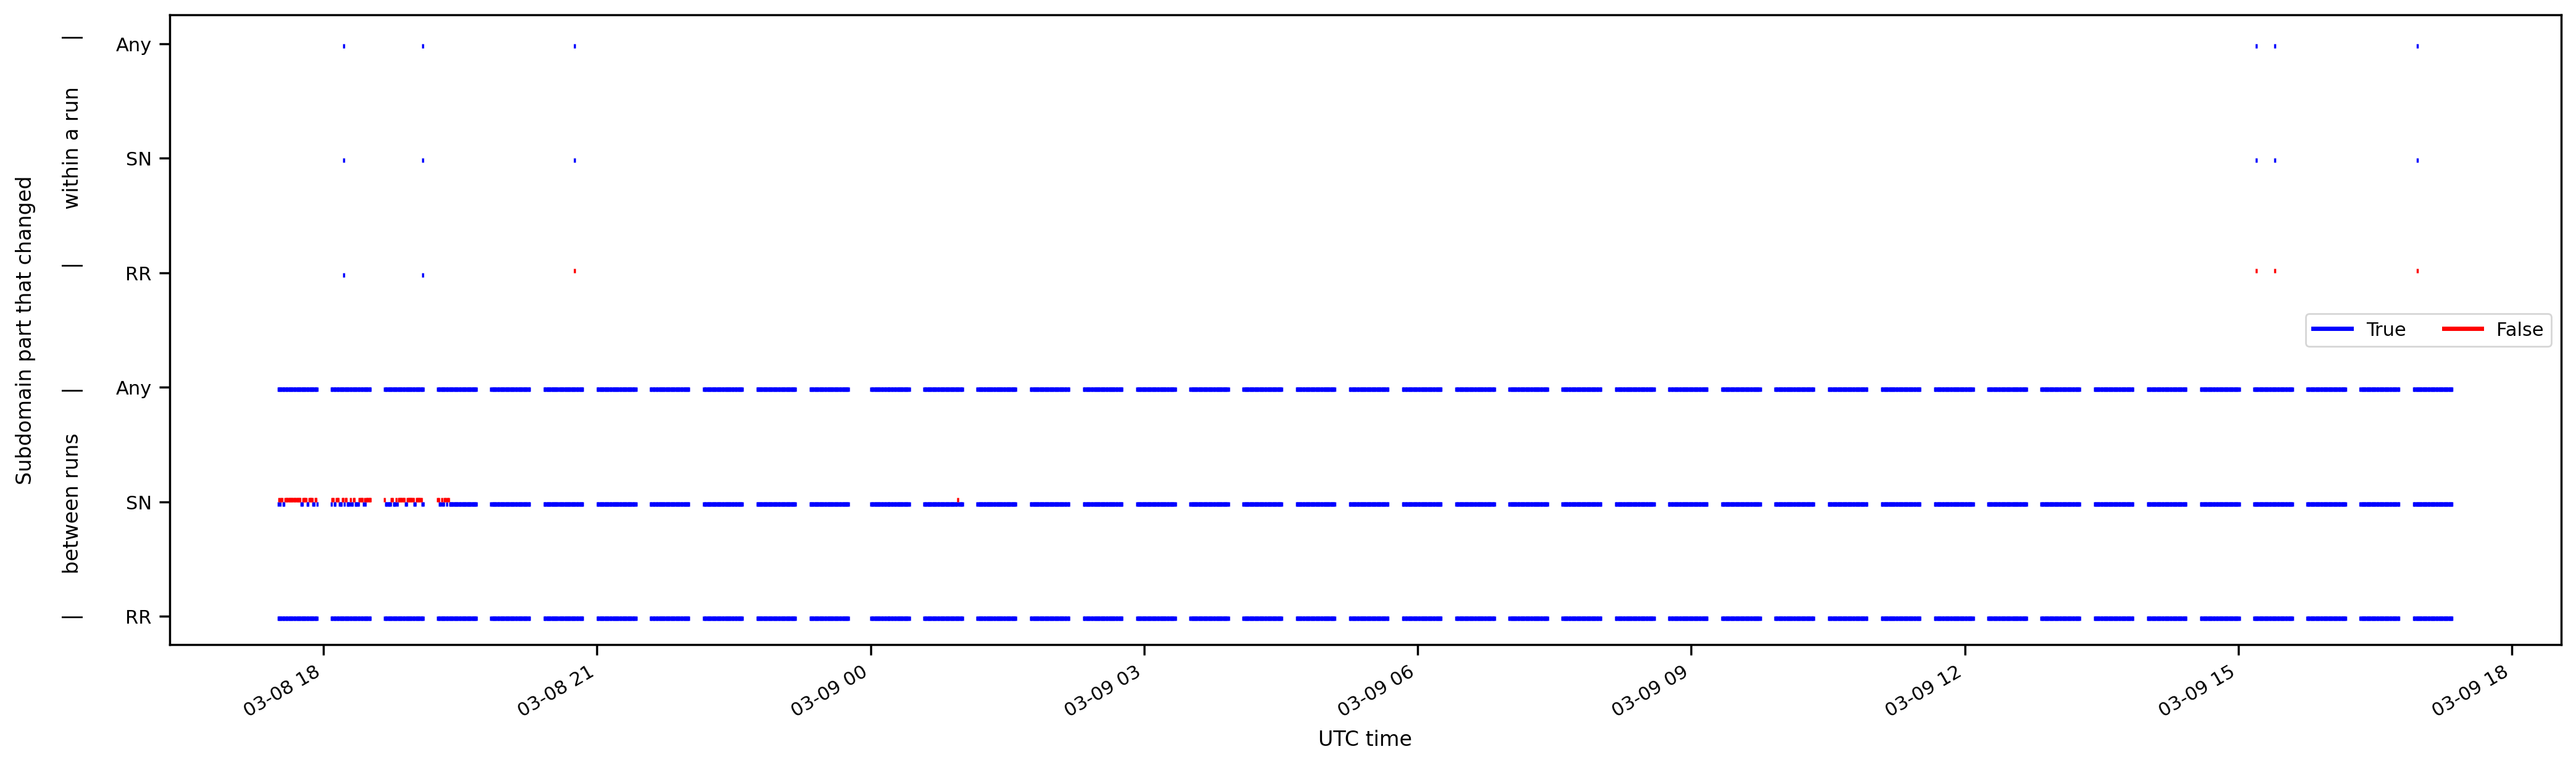

In [453]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu[(lookups_eu[label] == is_true) & (lookups_eu.first_time_seen < '2022-03-09 17:30') & (lookups_eu.first_time_seen > '2022-03-08 17:30')][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=2, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_xlabel("UTC time")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

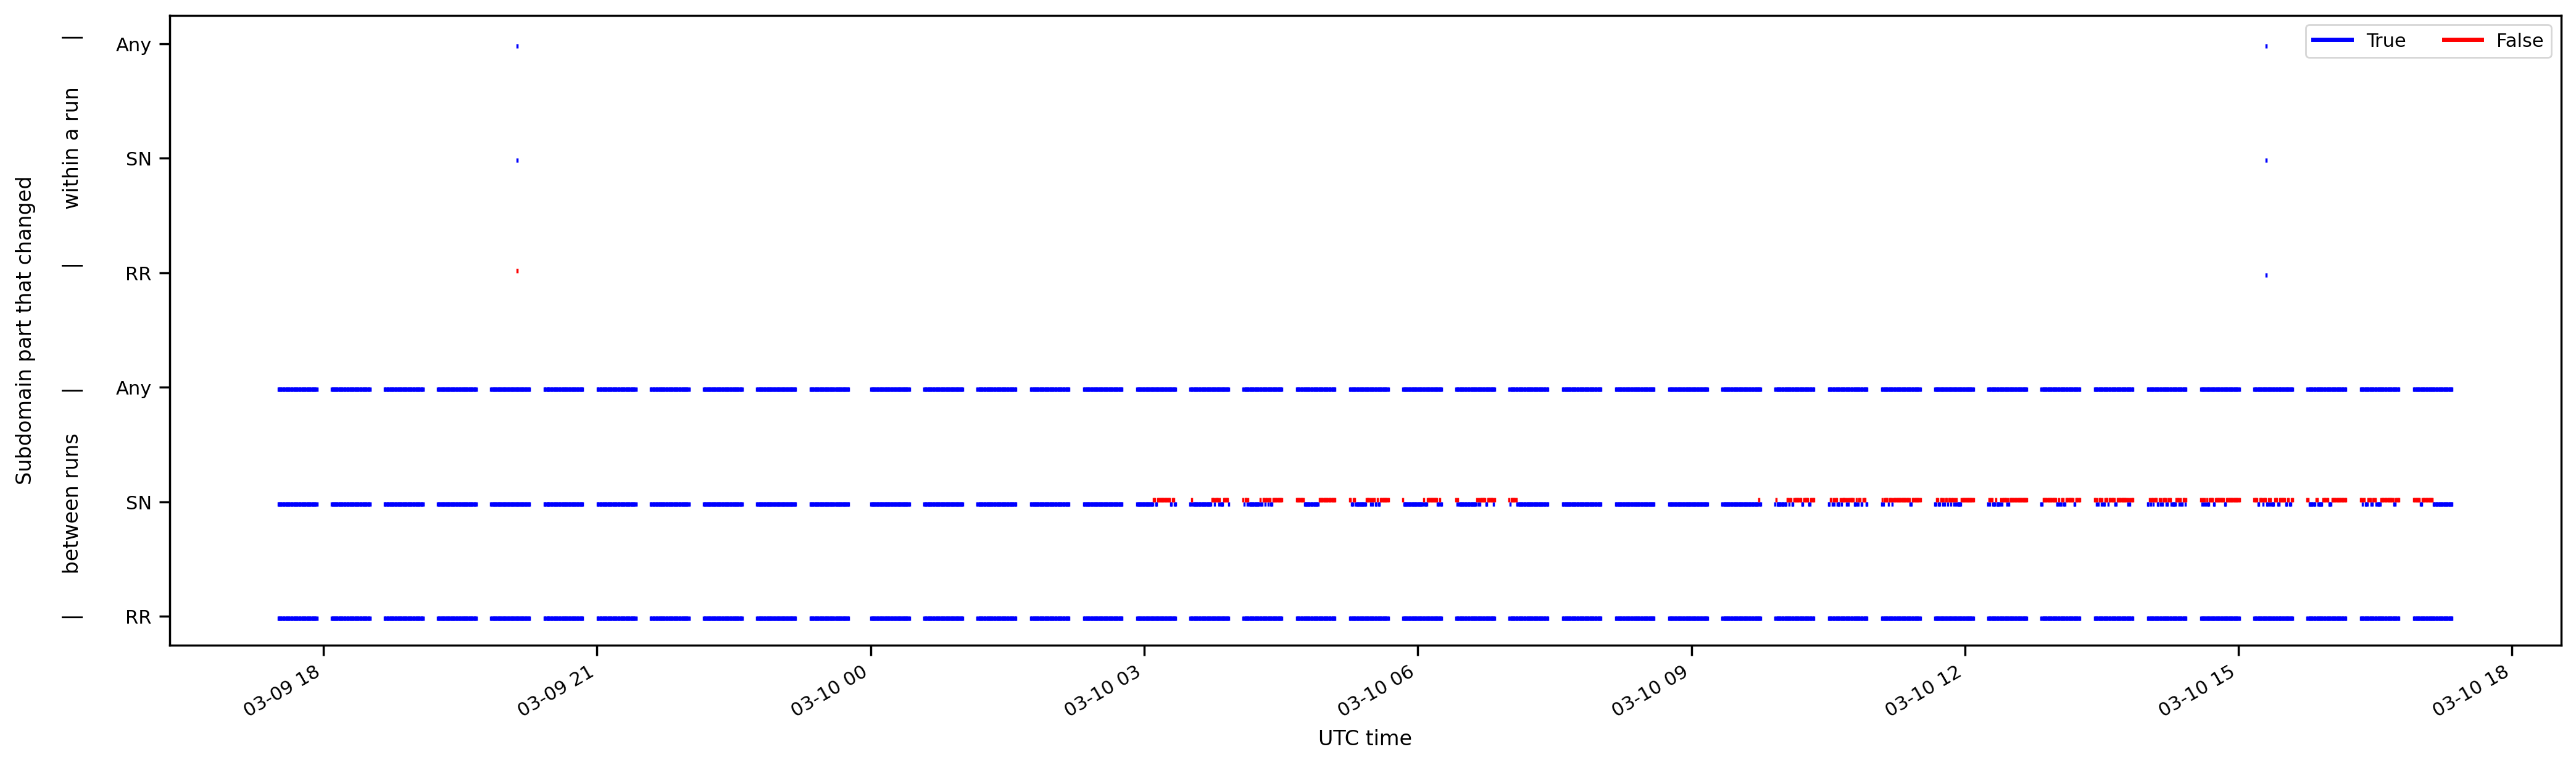

In [454]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu[(lookups_eu[label] == is_true) & (lookups_eu.first_time_seen < '2022-03-10 17:30') & (lookups_eu.first_time_seen > '2022-03-09 17:30')][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=2, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_xlabel("UTC time")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

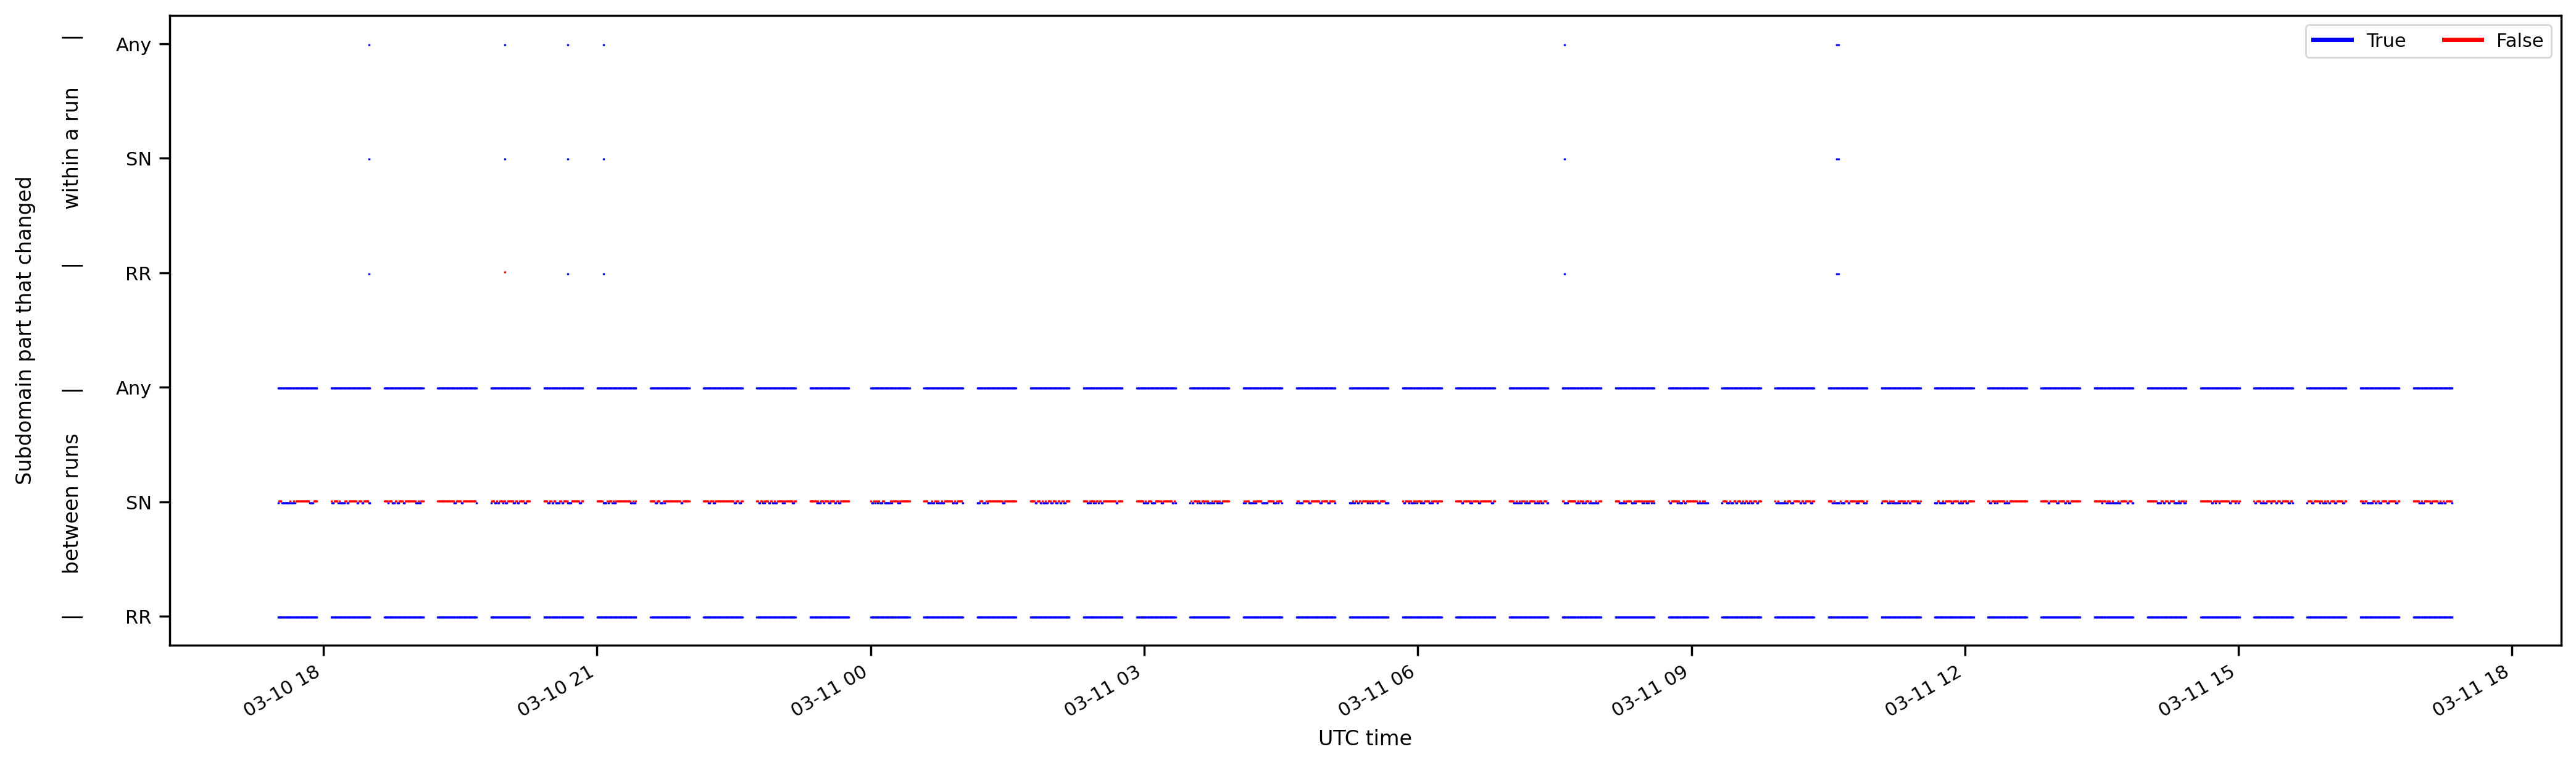

In [455]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu[(lookups_eu[label] == is_true) & (lookups_eu.first_time_seen < '2022-03-11 17:30') & (lookups_eu.first_time_seen > '2022-03-10 17:30')][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_xlabel("UTC time")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

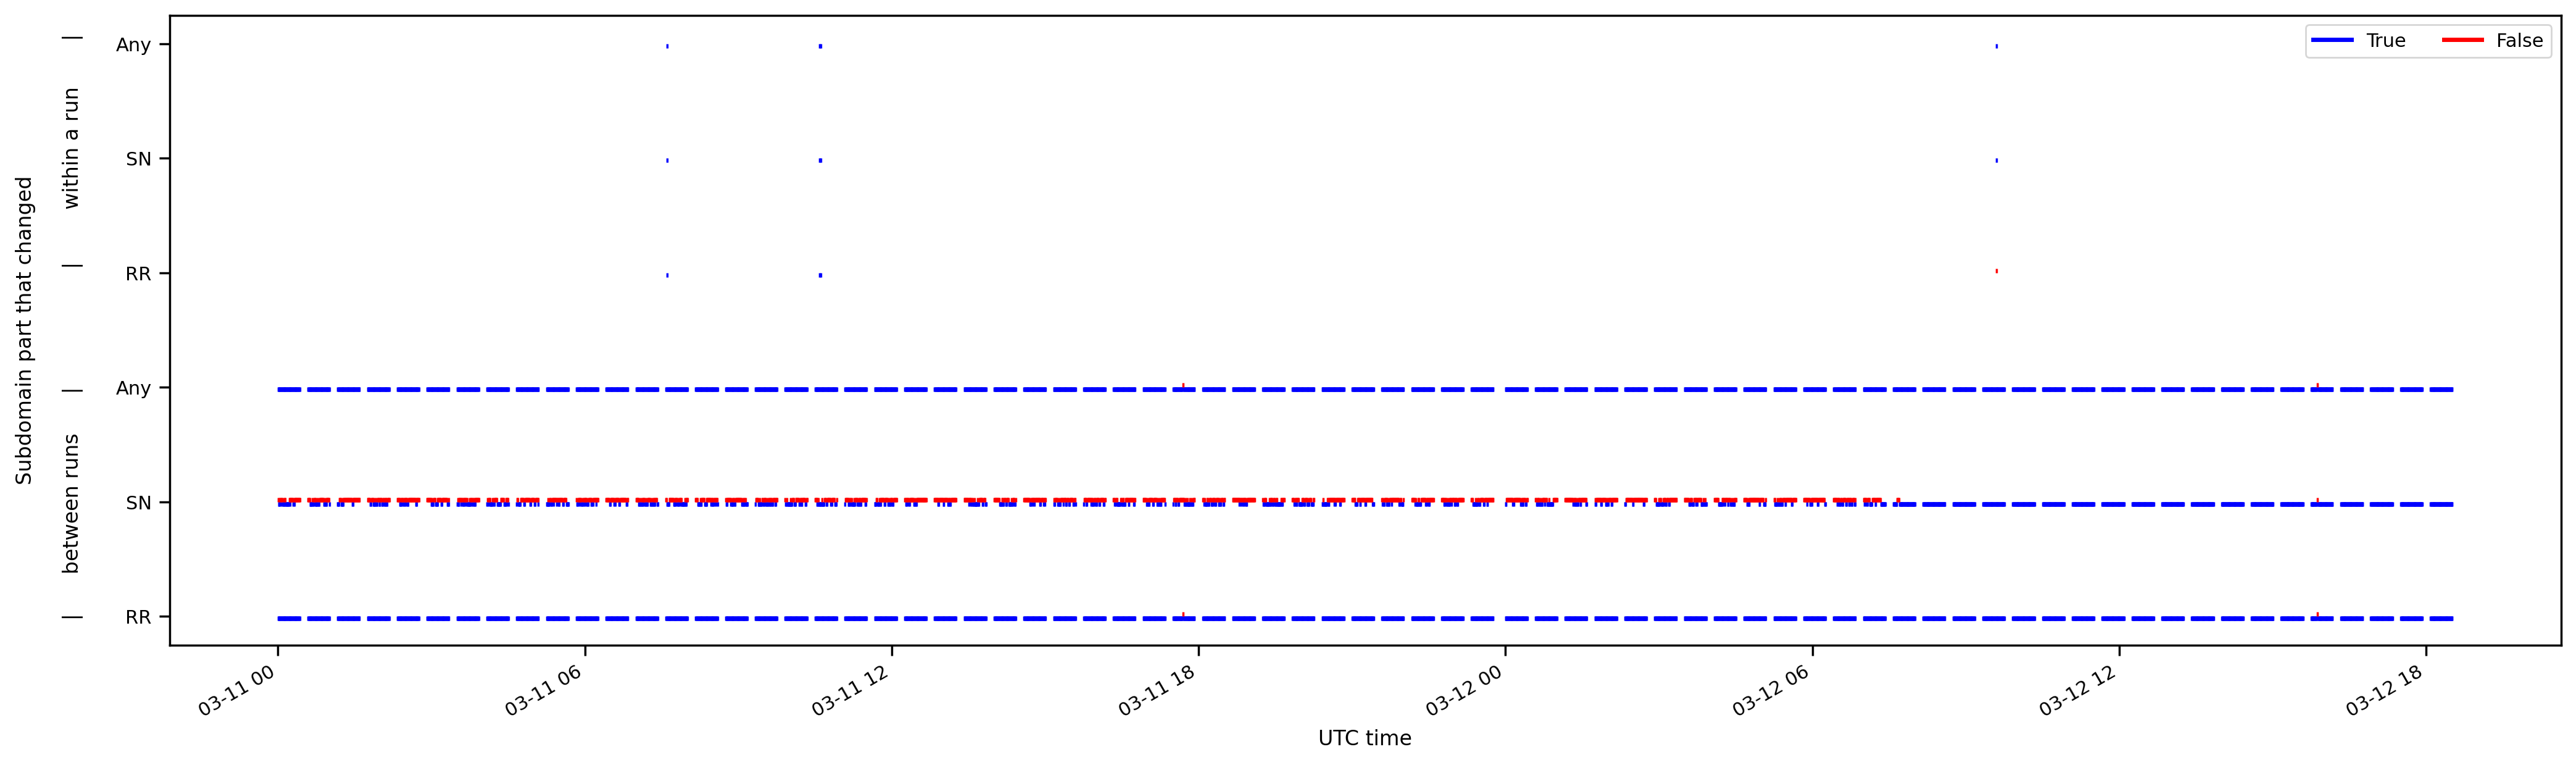

In [456]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu[(lookups_eu[label] == is_true) & (lookups_eu.first_time_seen < '2022-03-13 17:30') & (lookups_eu.first_time_seen > '2022-03-11 0:0')][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=2, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_xlabel("UTC time")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

## googlevideo subdomain changes pretty much every run and sometimes inbetween runs -- this is due to the measurement setup alternating between video IDs
# if we keep the video ID the same, the subdomain changes only 45% of the time

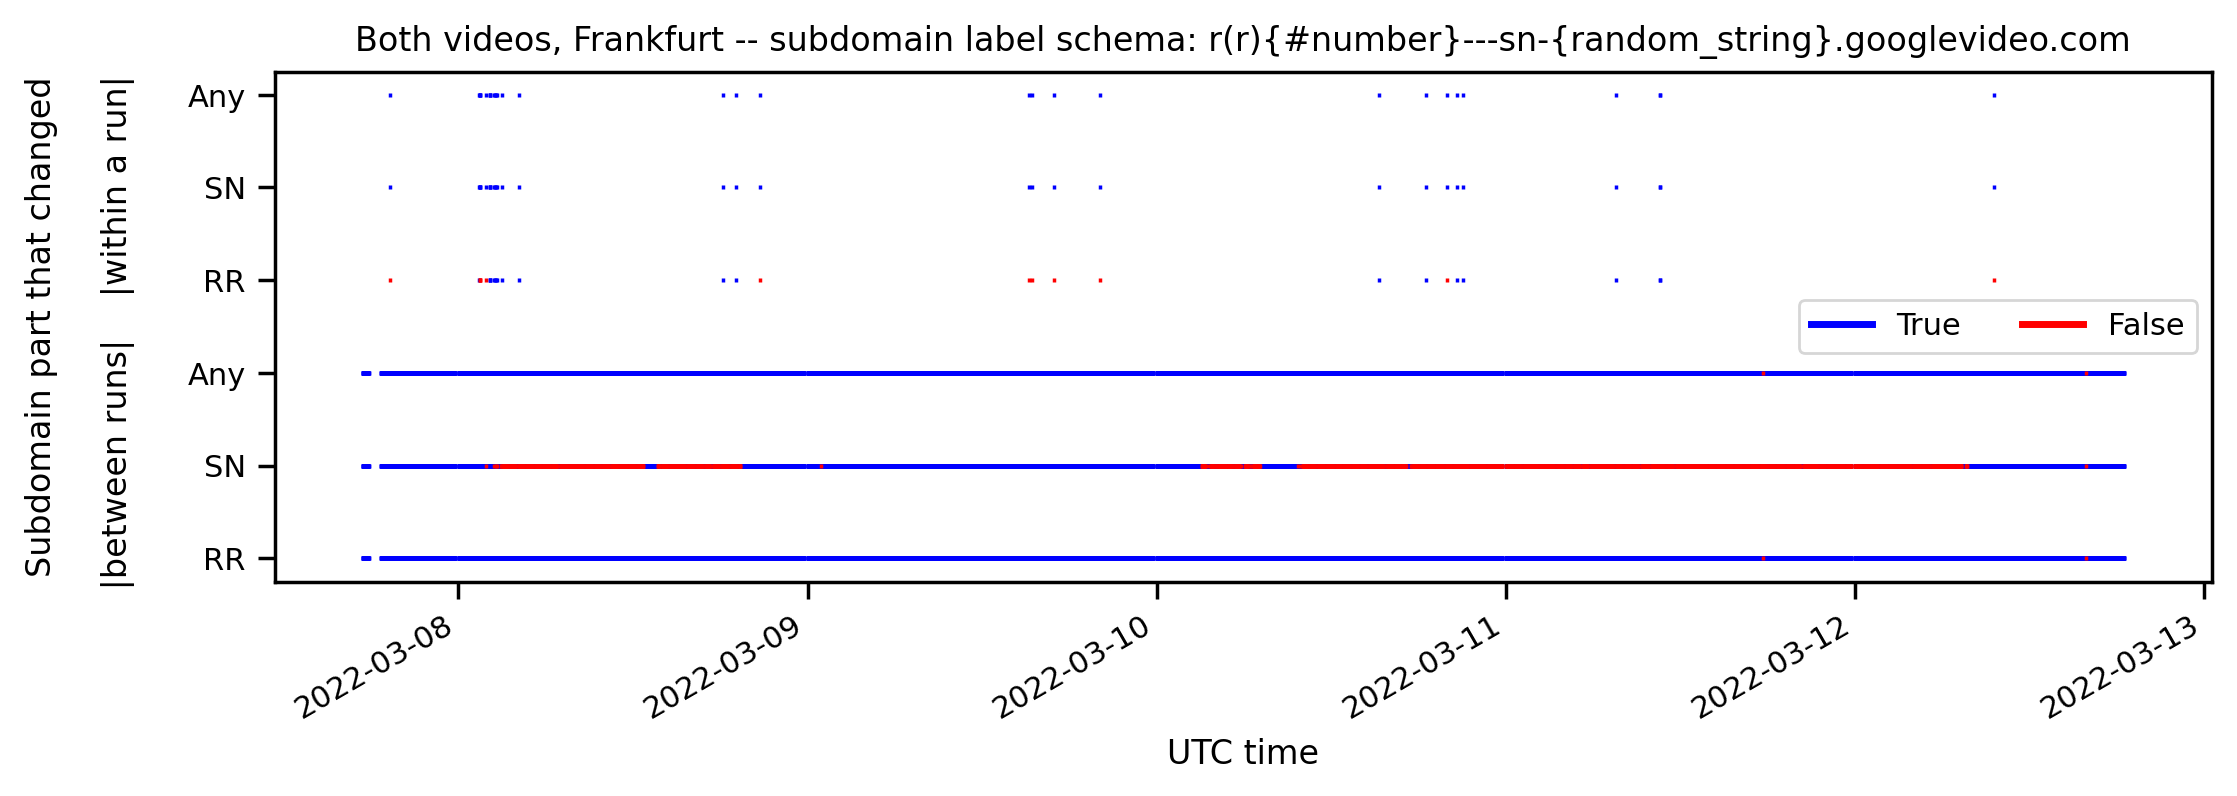

In [553]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu[(lookups_eu[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker="|", markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Both videos, Frankfurt -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

In [458]:
lookups_eu.video_id.unique()

array(['aqz-KE-bpKQ', 'lqiN98z6Dak'], dtype=object)

/tmp/ipykernel_17564/1293777772.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


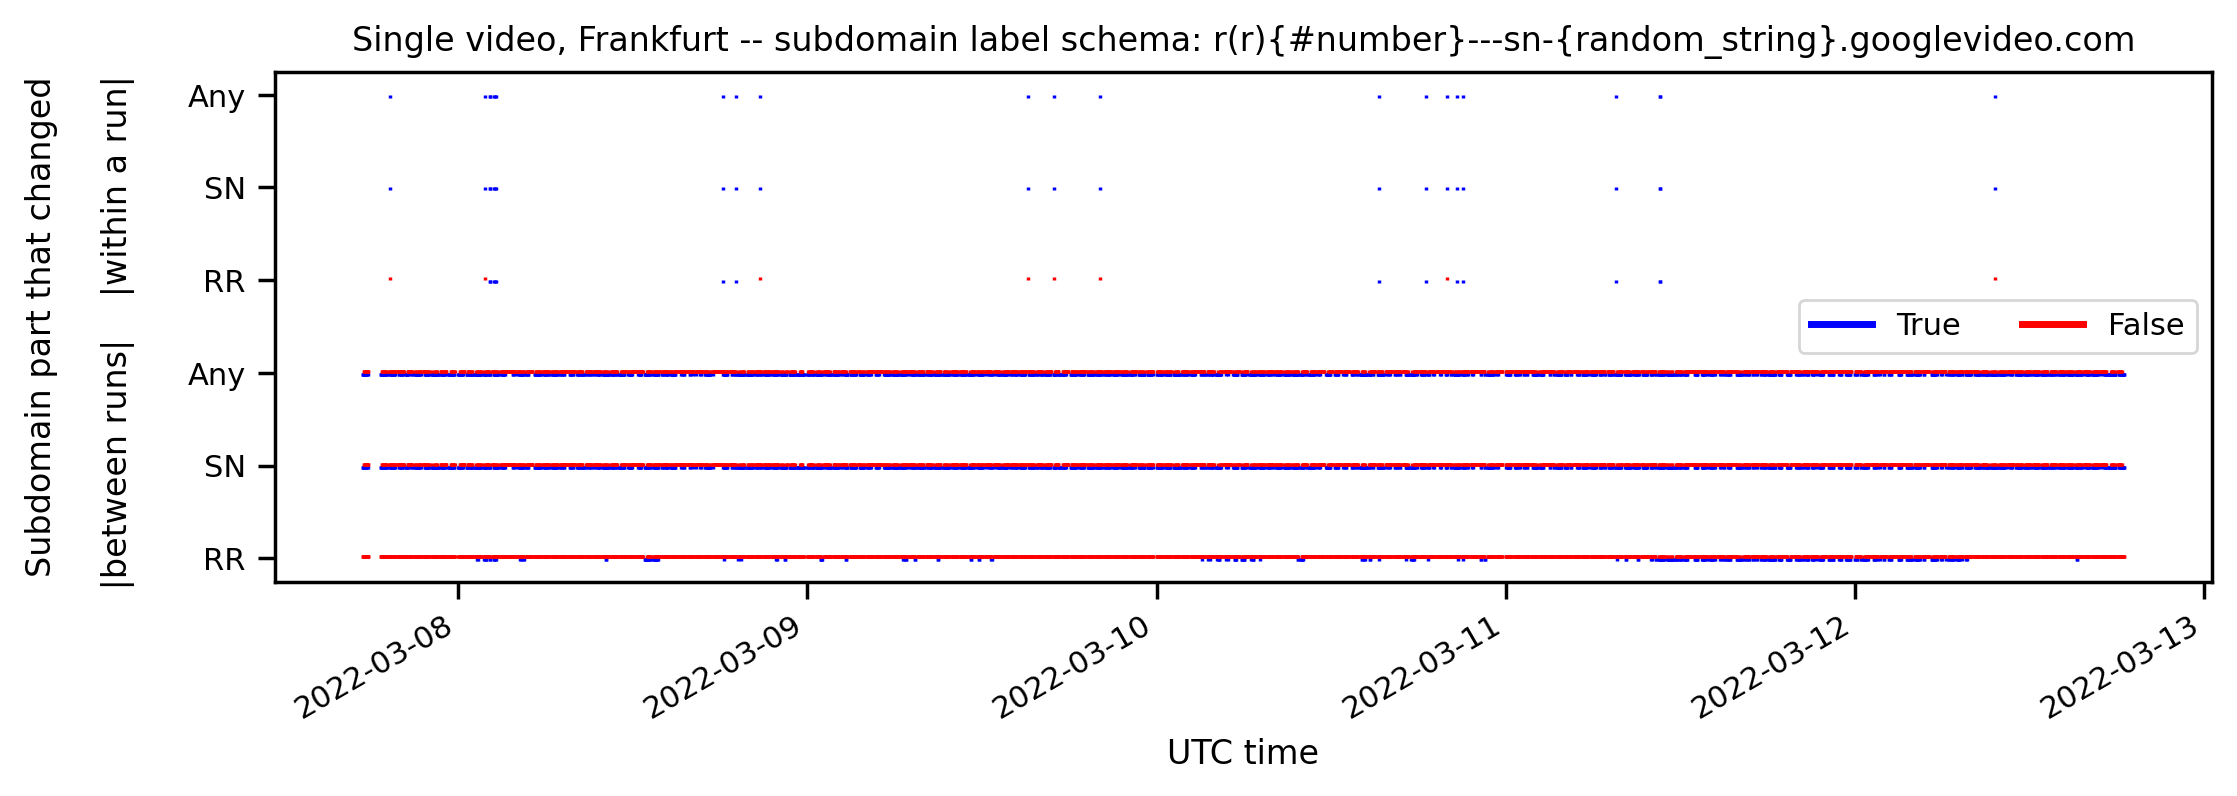

In [752]:
lookups_eu_single_video = lookups_eu[lookups_eu.video_id == 'aqz-KE-bpKQ'].copy()
lookups_eu_single_video.reset_index(drop=True, inplace=True)
lookups_eu_single_video['rr_changed_btw_msm'] = np.nan
lookups_eu_single_video['sn_changed_btw_msm'] = np.nan
lookups_eu_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_eu_single_video['rr_changed_in_msm'] = np.nan
lookups_eu_single_video['sn_changed_in_msm'] = np.nan
lookups_eu_single_video['subdomain_changed_in_msm'] = np.nan
lookups_eu_single_video = lookups_eu_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_eu_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_eu_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_eu_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_eu_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_eu_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_eu_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_eu_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu_single_video[(lookups_eu_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Frankfurt -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
plt.show()

In [753]:
lookups_eu_single_video.subdomain_changed_btw_msm.value_counts()

False    2343
True     1776
Name: subdomain_changed_btw_msm, dtype: int64

/tmp/ipykernel_17564/1827194580.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


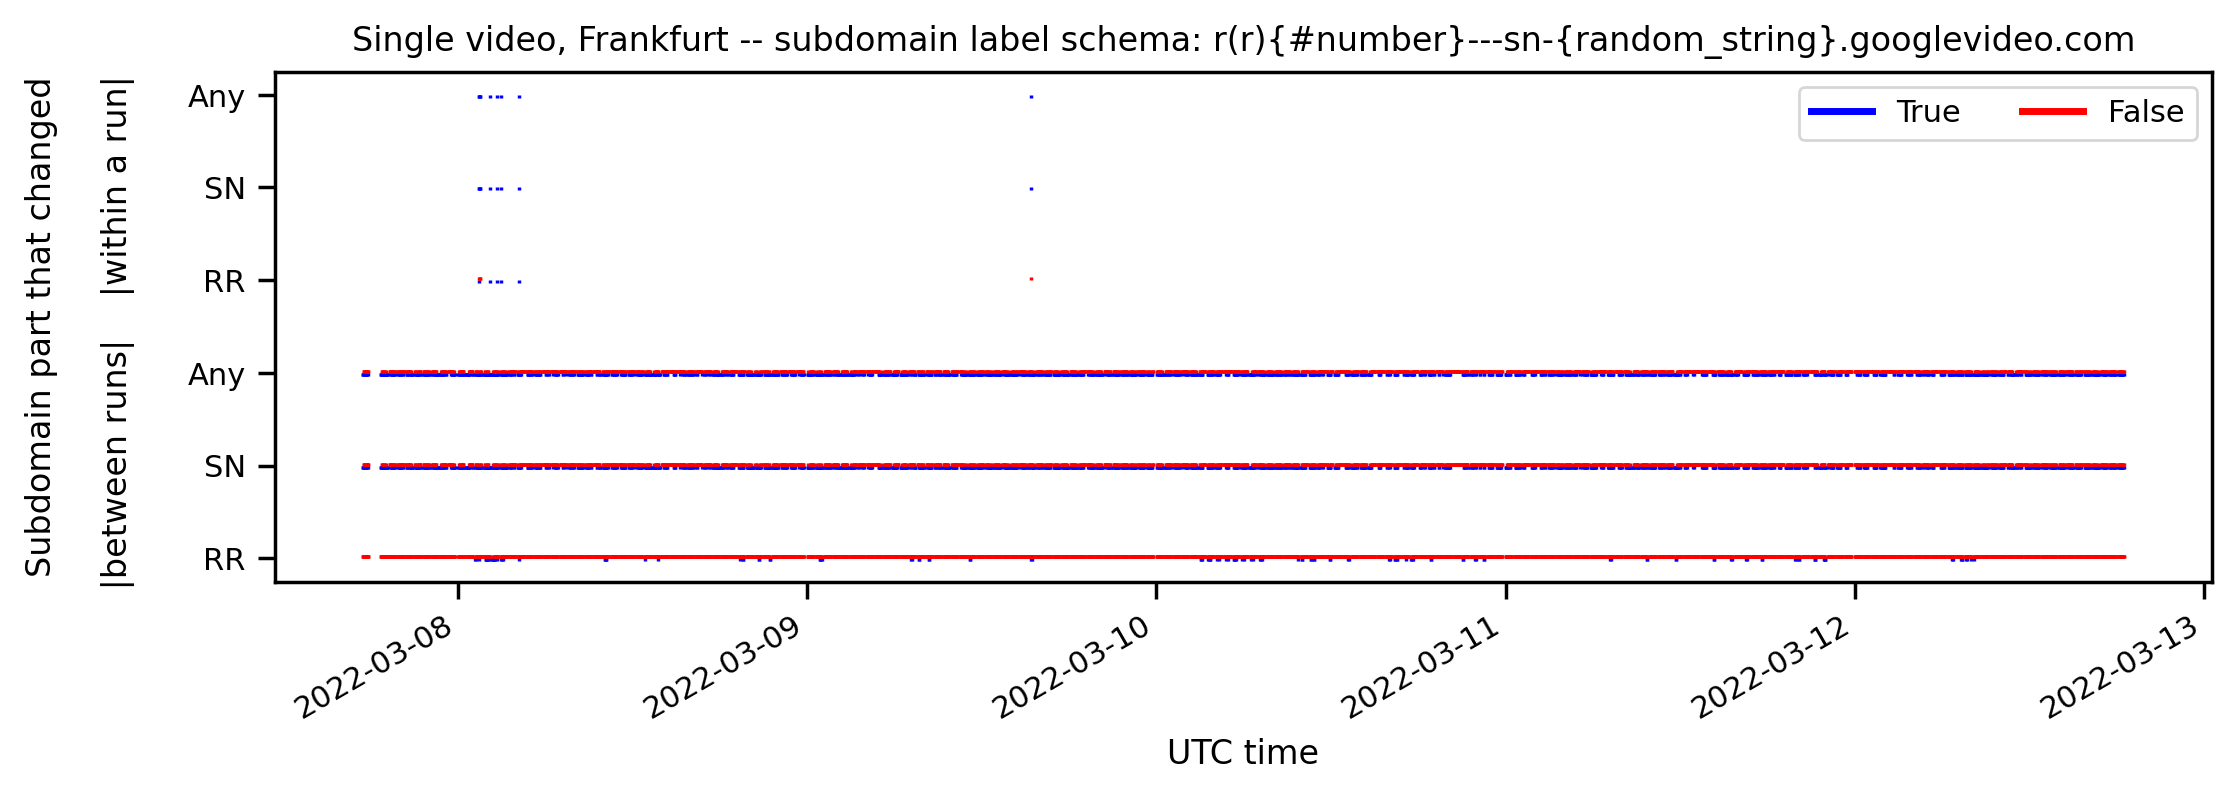

In [755]:
lookups_eu_single_video = lookups_eu[lookups_eu.video_id == 'lqiN98z6Dak'].copy()
lookups_eu_single_video.reset_index(drop=True, inplace=True)
lookups_eu_single_video['rr_changed_btw_msm'] = np.nan
lookups_eu_single_video['sn_changed_btw_msm'] = np.nan
lookups_eu_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_eu_single_video['rr_changed_in_msm'] = np.nan
lookups_eu_single_video['sn_changed_in_msm'] = np.nan
lookups_eu_single_video['subdomain_changed_in_msm'] = np.nan
lookups_eu_single_video = lookups_eu_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_eu_single_video.iterrows():
    if index != 0:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_eu_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_eu_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_eu_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_eu_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_eu_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_eu_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_eu_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
    last_row = row.copy(deep=False)
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu_single_video[(lookups_eu_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Frankfurt -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
plt.show()

In [466]:
lookups_eu_single_video.subdomain_changed_btw_msm.value_counts()

False    2337
True     1780
Name: subdomain_changed_btw_msm, dtype: int64

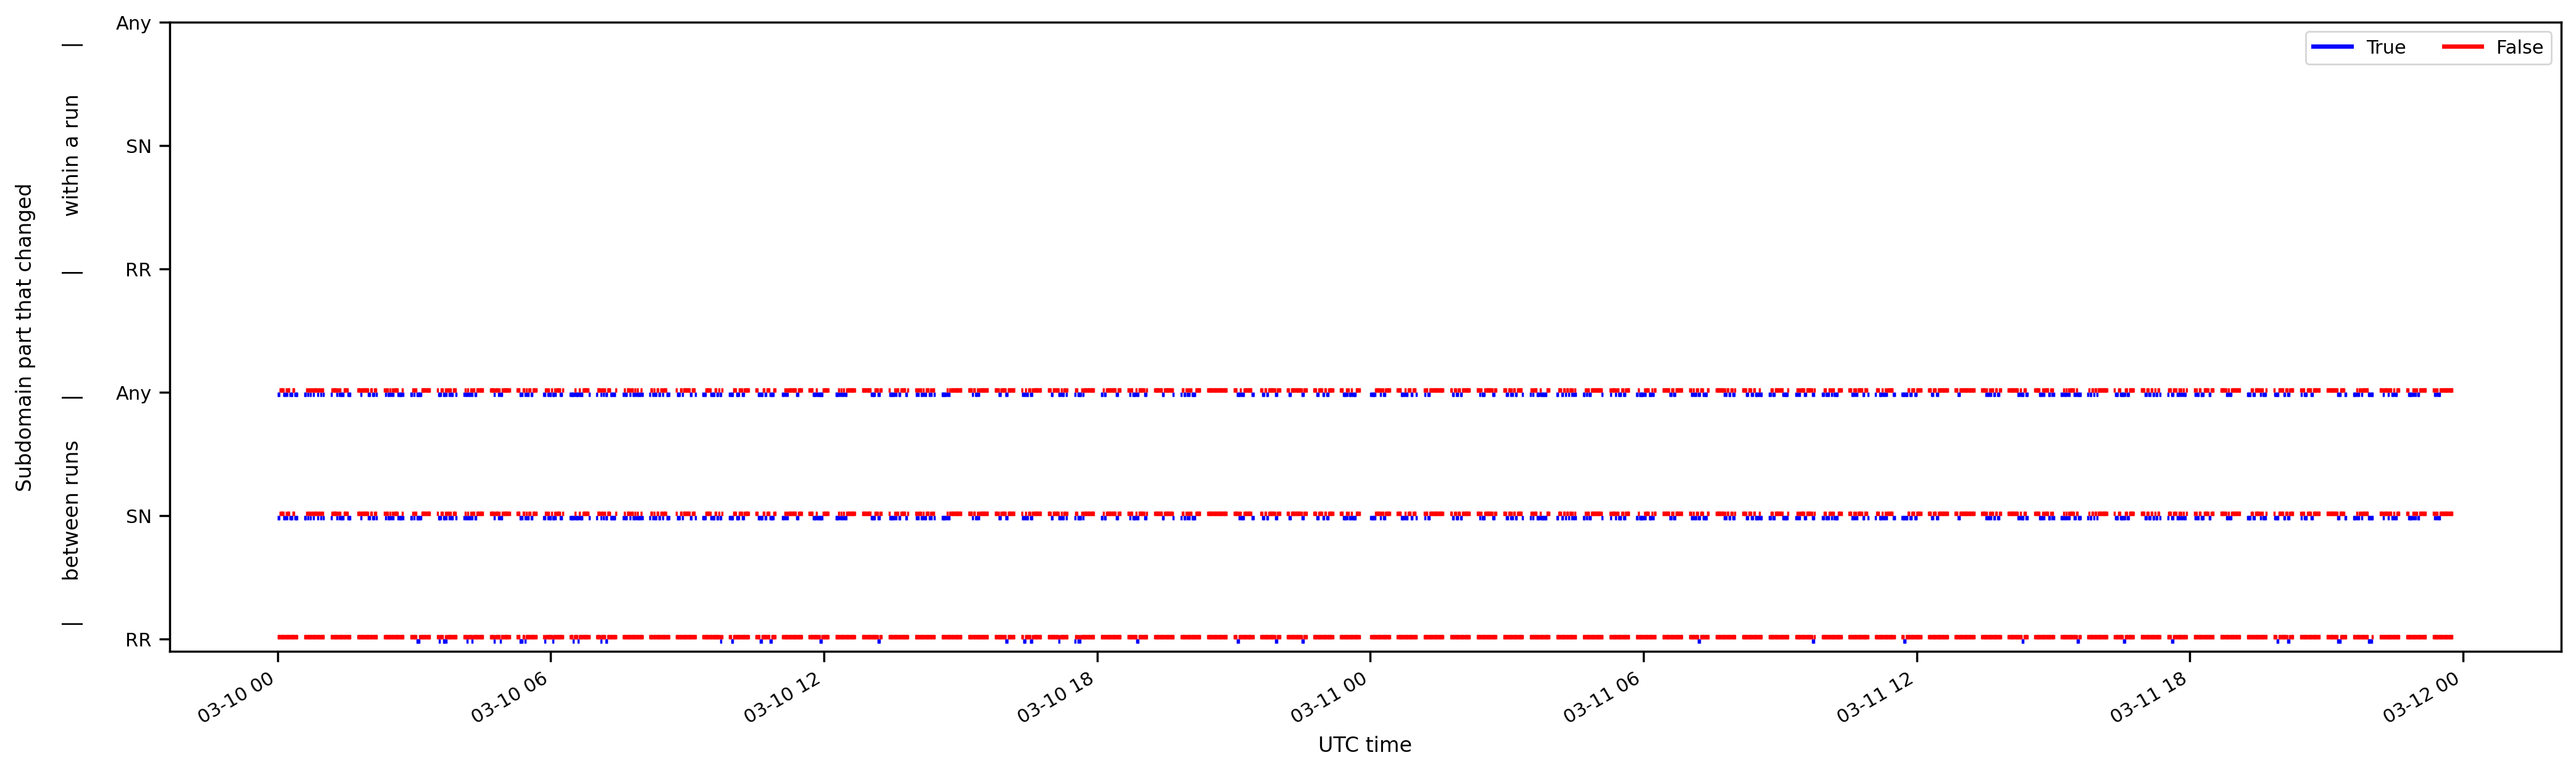

In [467]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_eu_single_video[(lookups_eu_single_video[label] == is_true) & (lookups_eu_single_video.first_time_seen < '2022-03-12 0:0') & (lookups_eu_single_video.first_time_seen > '2022-03-10 0:0')][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=2, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_xlabel("UTC time")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

In [407]:
measurements.vantagePoint.unique()

array(['Africa South', 'Asia Pacific Northeast', 'Asia Pacific Southeast',
       'Europe Central', 'South America East', 'US East', 'US West'],
      dtype=object)

## US West

In [532]:
measurements_usw = measurements[measurements.vantagePoint == 'US West'].copy()
lookups_usw = lookups[lookups.msm_id.isin(measurements_usw.msm_id.unique())].copy()
googlevideo_subdomains_usw = googlevideo_subdomains[googlevideo_subdomains.msm_id.isin(measurements_usw.msm_id.unique())].copy()
googlevideo_requests_usw = googlevideo_requests[googlevideo_requests.msm_id.isin(measurements_usw.msm_id.unique())].copy()


In [533]:
lookups_usw.status.unique()

array(['NOERROR'], dtype=object)

In [534]:
measurements_usw.reset_index(drop=True, inplace=True)

In [535]:
lookups_usw.reset_index(drop=True, inplace=True)

In [536]:
lookups_usw[lookups_usw.status == 'NOERROR'].groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r2---sn-n4v7sney,1,74.125.103.39
1,r4---sn-o097znse,1,74.125.166.41
4,rr2---sn-a5msen7z,1,74.125.103.167
7,rr4---sn-a5mekn6d,1,173.194.8.201
8,rr4---sn-a5mekn6l,1,173.194.8.105
9,rr4---sn-a5msen7z,1,74.125.103.169
10,rr4---sn-n4v7snl7,1,74.125.103.137
2,redirector,2,"[142.250.68.14, 142.250.68.78]"
3,rr2---sn-a5mekn6d,2,"[173.194.8.199, 142.250.68.65]"
5,rr2---sn-n4v7sney,2,"[74.125.103.39, 173.194.8.7]"


In [537]:
measurements_usw.error.unique()

array(['',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n'],
      dtype=object)

In [538]:
lookups_usw[lookups_usw.video_subdomain == 'redirector'].video_id.value_counts()

aqz-KE-bpKQ    2
Name: video_id, dtype: int64

In [584]:
lookups_usw[lookups_usw.status != 'NOERROR']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,...,video_id,player_dimensions,timestamp,rr_changed_btw_msm,sn_changed_btw_msm,subdomain_changed_btw_msm,rr_changed_in_msm,sn_changed_in_msm,subdomain_changed_in_msm,sn_length


#### less SN variety than EU

In [539]:
lookups_usw[lookups_usw.video_subdomain != 'redirector'].groupby('rand_sn_str').agg(rr_count=('round_robin_str', pd.Series.nunique)).sort_values('rr_count')

,rr_count
rand_sn_str,
sn-a5mekn6l,1
sn-n4v7snl7,1
sn-o097znsr,1
sn-a5mekn6d,2
sn-a5msen7z,2
sn-n4v7sney,2
sn-o097znse,2


In [540]:
lookups_usw[lookups_usw.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1).groupby('rand_sn_str', as_index=False).agg(rr_strs=('round_robin_str', pd.Series.unique))

,rand_sn_str,rr_strs
0,sn-a5mekn6d,"[rr2, rr4]"
1,sn-a5msen7z,"[rr2, rr4]"
2,sn-n4v7sney,"[rr2, r2]"
3,sn-o097znse,"[rr4, r4]"


In [541]:
lookups_usw = lookups_usw[lookups_usw.video_subdomain != 'redirector']
lookups_usw.reset_index(drop=True, inplace=True)
lookups_usw['rr_changed_btw_msm'] = np.nan
lookups_usw['sn_changed_btw_msm'] = np.nan
lookups_usw['subdomain_changed_btw_msm'] = np.nan
lookups_usw['rr_changed_in_msm'] = np.nan
lookups_usw['sn_changed_in_msm'] = np.nan
lookups_usw['subdomain_changed_in_msm'] = np.nan
lookups_usw = lookups_usw.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_usw.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_usw.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_usw.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_usw.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_usw.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_usw.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_usw.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_usw.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_usw.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_usw.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_usw.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_usw.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_usw.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row

/tmp/ipykernel_17564/4265782135.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


In [542]:
print(lookups_usw['ip_addr/24'].nunique())
print(lookups_usw['rand_sn_str'].nunique())

4
7


In [543]:
lookups_usw.groupby('rand_sn_str', as_index=False).agg(count24=('ip_addr/24', pd.Series.nunique), count16=('ip_addr/16', pd.Series.nunique)).sort_values('count16')

,rand_sn_str,count24,count16
1,sn-a5mekn6l,1,1
2,sn-a5msen7z,1,1
4,sn-n4v7snl7,1,1
6,sn-o097znsr,1,1
0,sn-a5mekn6d,2,2
3,sn-n4v7sney,2,2
5,sn-o097znse,2,2


In [544]:
lookups_usw.groupby('ip_addr/24', as_index=False).agg(count_sn=('rand_sn_str', pd.Series.unique))

,ip_addr/24,count_sn
0,142.250.68,sn-a5mekn6d
1,173.194.8,"[sn-o097znsr, sn-a5mekn6l, sn-a5mekn6d, sn-n4v..."
2,74.125.103,"[sn-n4v7sney, sn-n4v7snl7, sn-a5msen7z]"
3,74.125.166,sn-o097znse


In [545]:
lookups_usw['sn_length'] = lookups_usw['rand_sn_str'].str.len()
print(lookups_usw.sn_length.value_counts())

11    8316
Name: sn_length, dtype: int64


In [546]:
lookups_usw.groupby('ip_addr/24', as_index=False).agg(count_sn_overlap=('rand_sn_str', lambda x: count_largest_sn_overlap(pd.Series.unique(x).tolist())), sn_overlap=('rand_sn_str', lambda x: largest_sn_overlap(pd.Series.unique(x).tolist())))

,ip_addr/24,count_sn_overlap,sn_overlap
0,142.250.68,11,sn-a5mekn6d
1,173.194.8,3,sn-
2,74.125.103,3,sn-
3,74.125.166,11,sn-o097znse


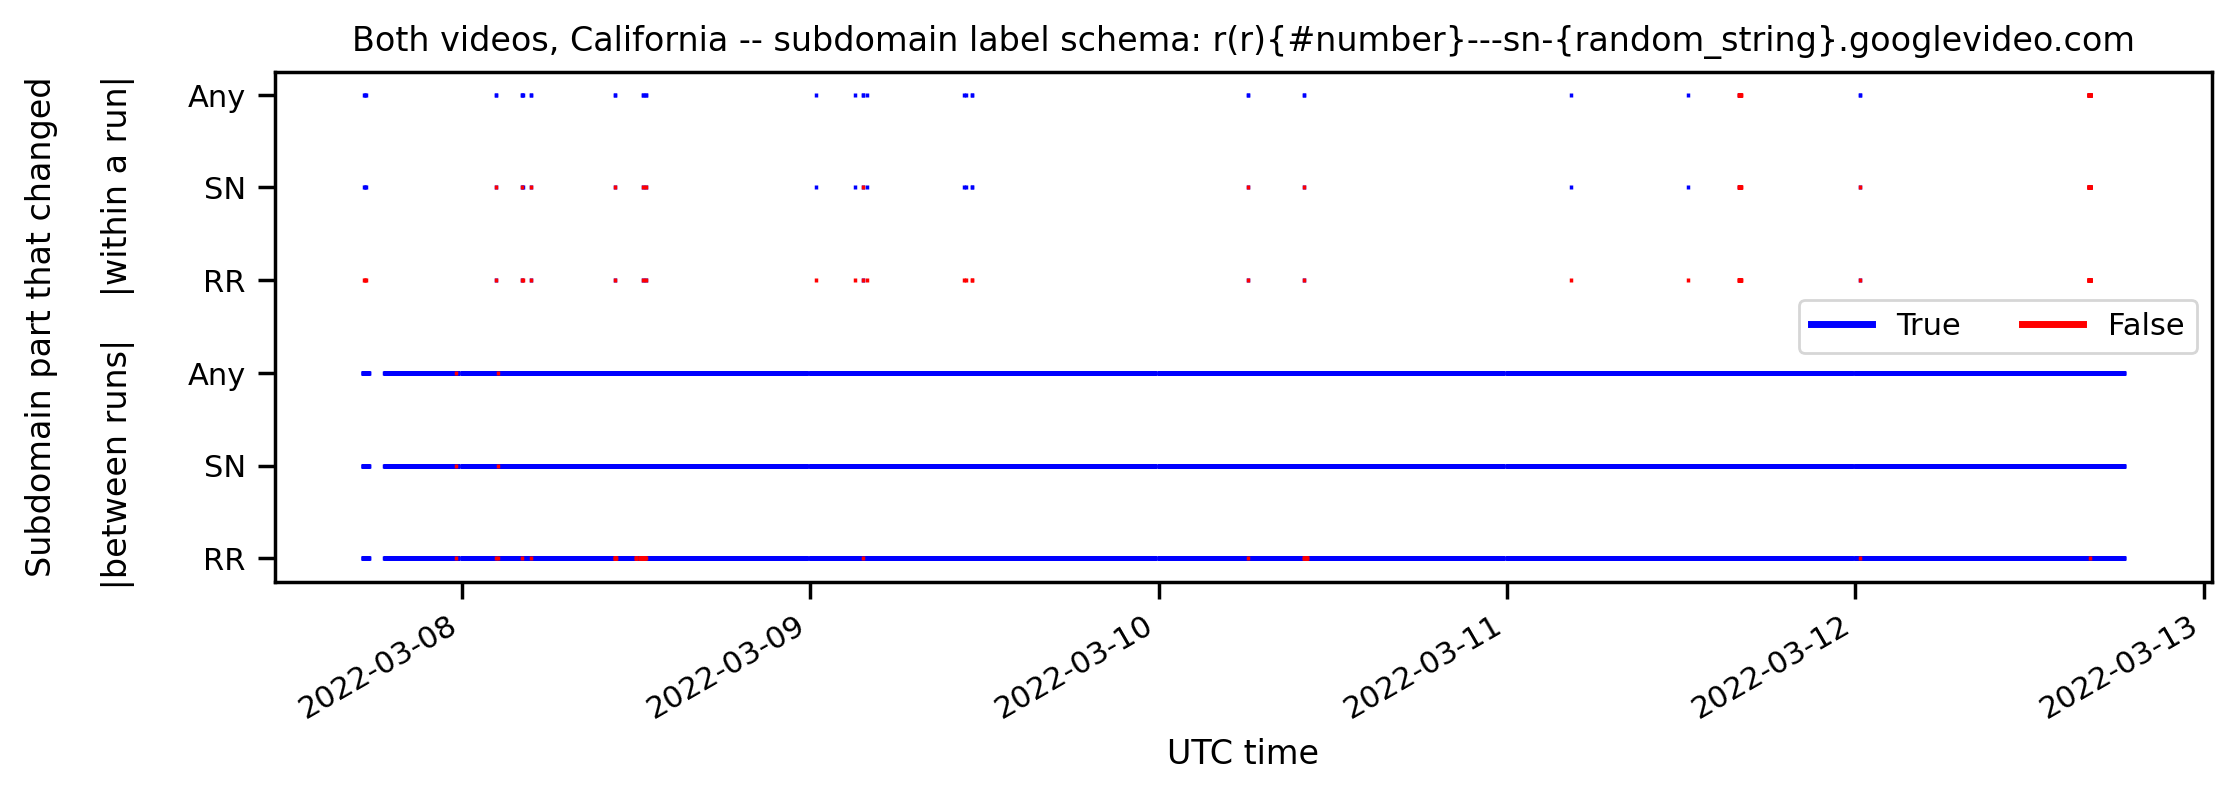

In [556]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_usw[(lookups_usw[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker="|", markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Both videos, California -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

/tmp/ipykernel_17564/2137313437.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2361
True     1757
Name: subdomain_changed_btw_msm, dtype: int64


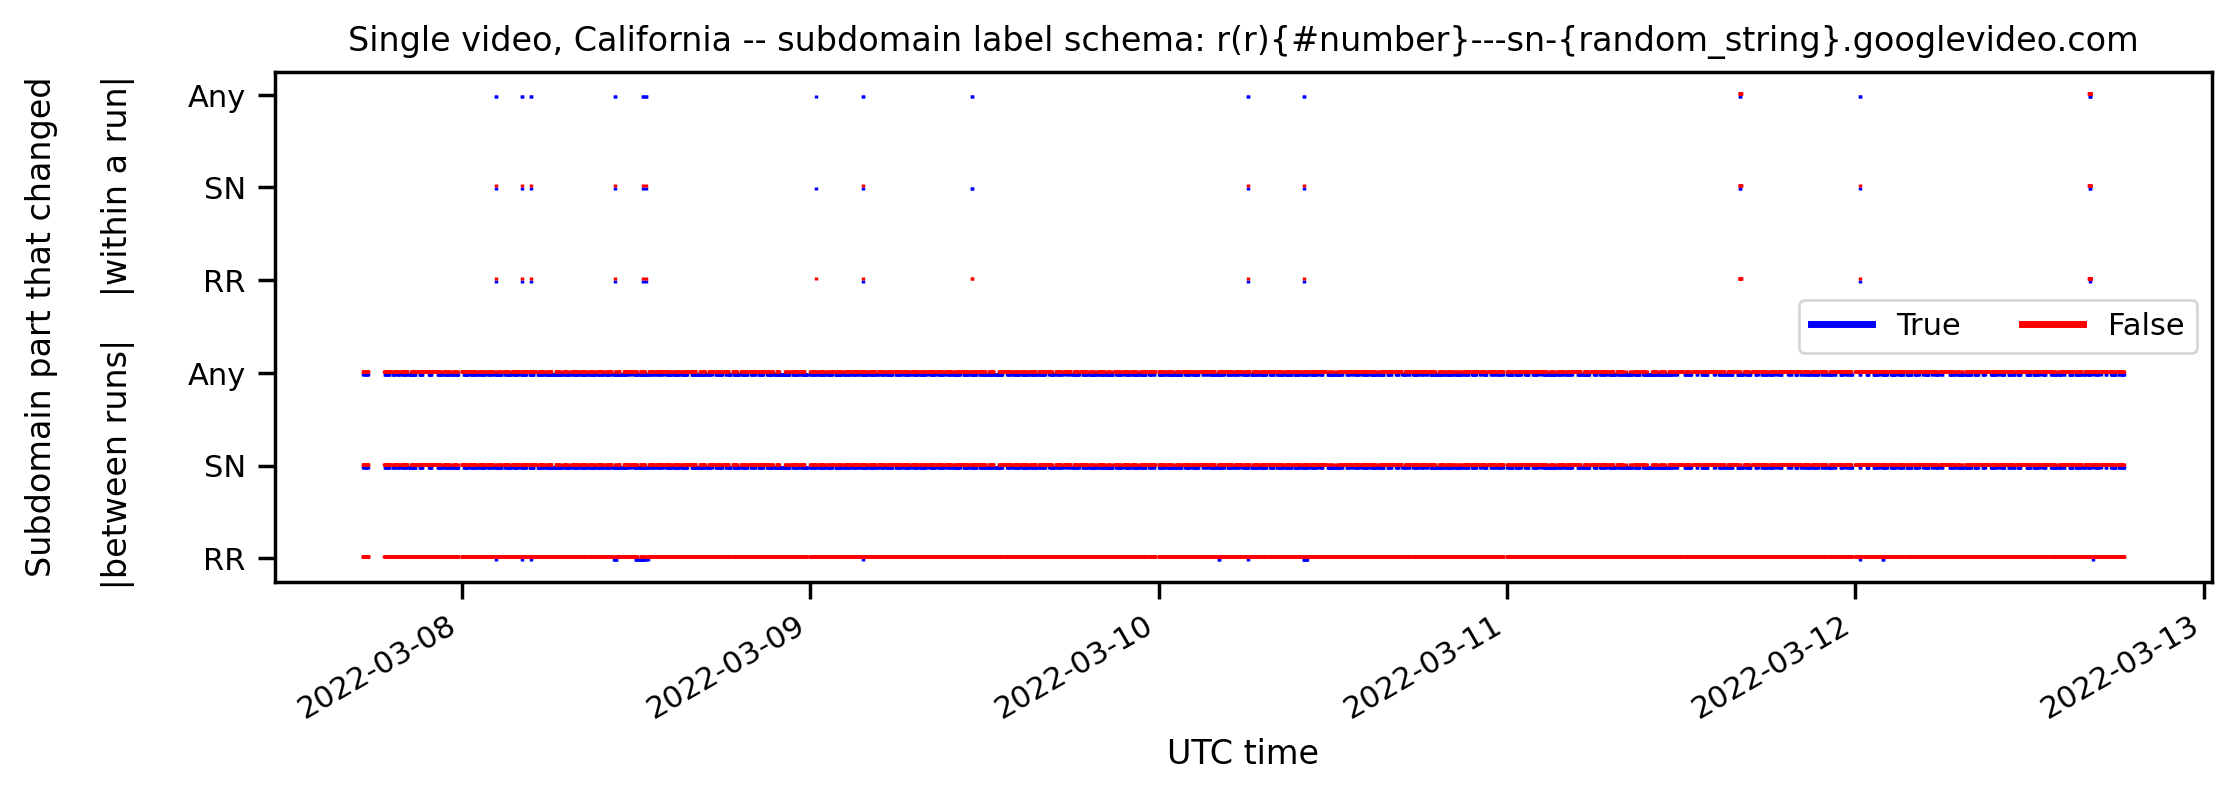

In [756]:
lookups_usw_single_video = lookups_usw[lookups_usw.video_id == 'aqz-KE-bpKQ'].copy()
lookups_usw_single_video.reset_index(drop=True, inplace=True)
lookups_usw_single_video['rr_changed_btw_msm'] = np.nan
lookups_usw_single_video['sn_changed_btw_msm'] = np.nan
lookups_usw_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_usw_single_video['rr_changed_in_msm'] = np.nan
lookups_usw_single_video['sn_changed_in_msm'] = np.nan
lookups_usw_single_video['subdomain_changed_in_msm'] = np.nan
lookups_usw_single_video = lookups_usw_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_usw_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_usw_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_usw_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_usw_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_usw_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_usw_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_usw_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_usw_single_video[(lookups_usw_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, California -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_usw_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

/tmp/ipykernel_17564/2656216123.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2329
True     1789
Name: subdomain_changed_btw_msm, dtype: int64


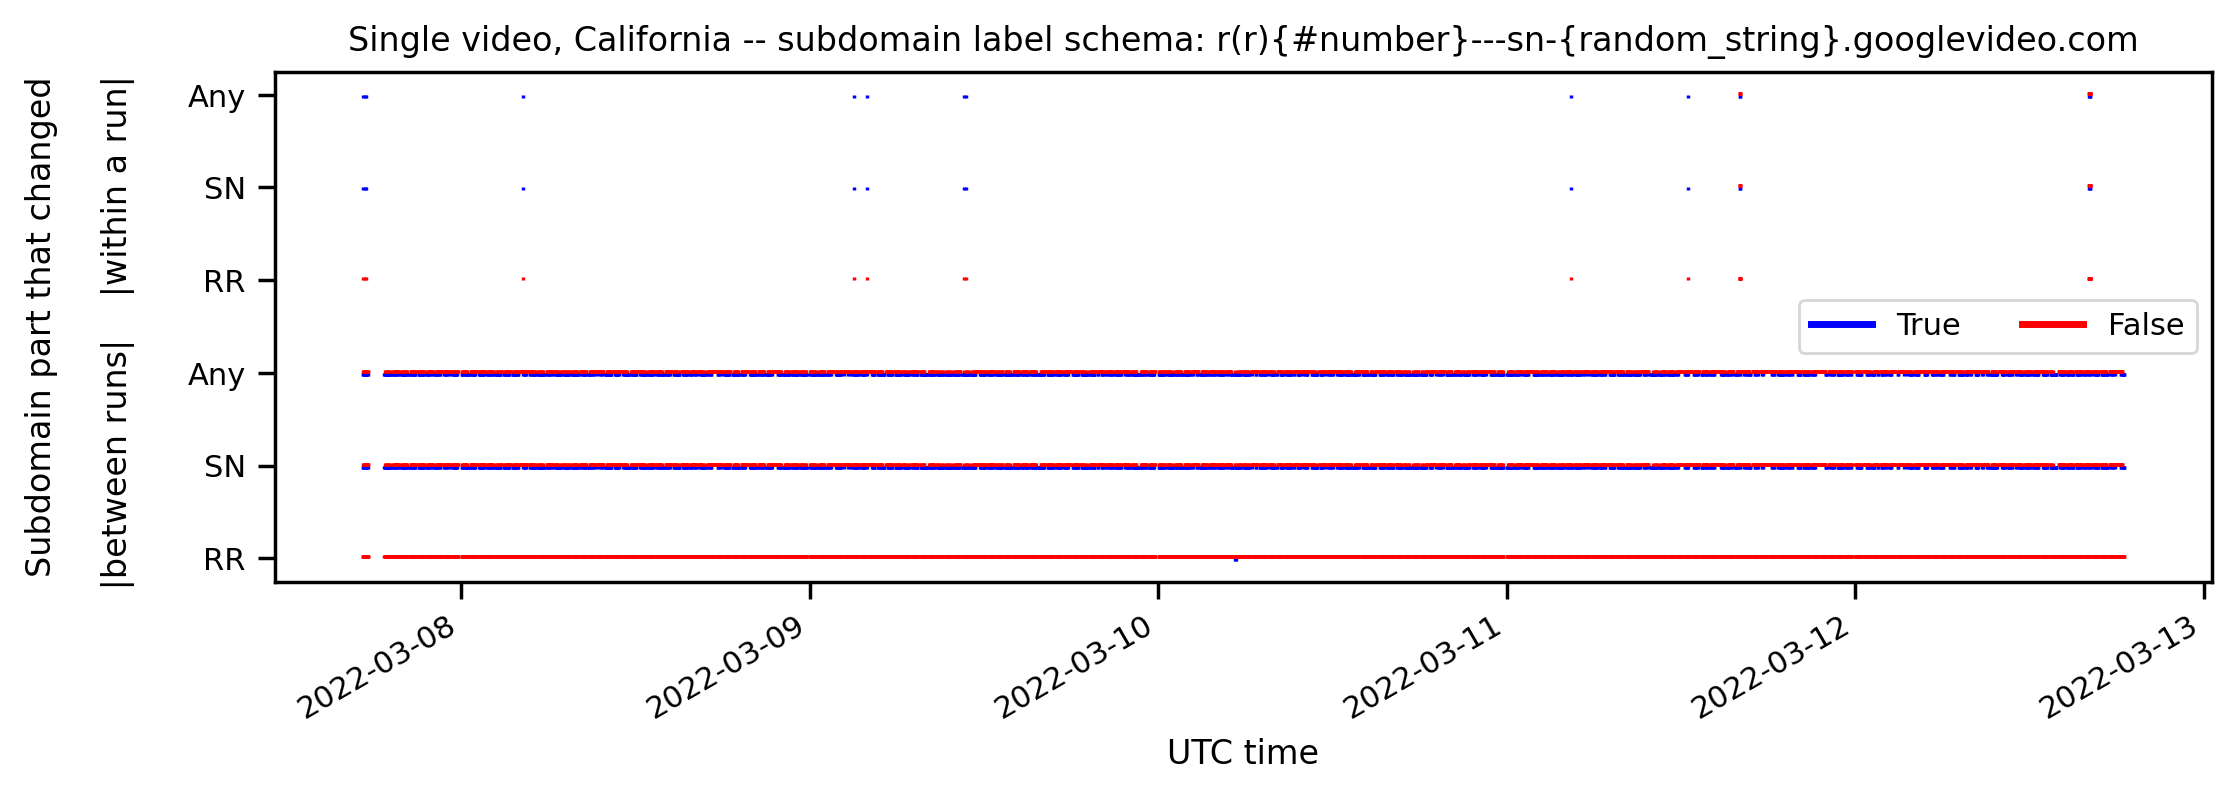

In [757]:
lookups_usw_single_video = lookups_usw[lookups_usw.video_id == 'lqiN98z6Dak'].copy()
lookups_usw_single_video.reset_index(drop=True, inplace=True)
lookups_usw_single_video['rr_changed_btw_msm'] = np.nan
lookups_usw_single_video['sn_changed_btw_msm'] = np.nan
lookups_usw_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_usw_single_video['rr_changed_in_msm'] = np.nan
lookups_usw_single_video['sn_changed_in_msm'] = np.nan
lookups_usw_single_video['subdomain_changed_in_msm'] = np.nan
lookups_usw_single_video = lookups_usw_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_usw_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_usw_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_usw_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_usw_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_usw_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_usw_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_usw_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_usw_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_usw_single_video[(lookups_usw_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, California -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_usw_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

### US East

In [564]:
measurements_use = measurements[measurements.vantagePoint == 'US East'].copy()
lookups_use = lookups[lookups.msm_id.isin(measurements_use.msm_id.unique())].copy()
googlevideo_subdomains_use = googlevideo_subdomains[googlevideo_subdomains.msm_id.isin(measurements_use.msm_id.unique())].copy()
googlevideo_requests_use = googlevideo_requests[googlevideo_requests.msm_id.isin(measurements_use.msm_id.unique())].copy()
measurements_use.reset_index(drop=True, inplace=True)
lookups_use.reset_index(drop=True, inplace=True)

In [566]:
lookups_use[lookups_use.status == 'NOERROR'].groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r2---sn-p5qddn7k,1,173.194.7.135
1,r4---sn-p5qlsn76,1,172.217.135.201
2,r4---sn-p5qs7n7d,1,74.125.155.234
3,redirector,1,142.250.81.238
4,rr2---sn-p5qddn7k,1,173.194.7.135
5,rr2---sn-p5qlsn7s,1,172.217.135.167
6,rr2---sn-q4fl6nsd,1,74.125.3.167
7,rr2---sn-vgqsknez,1,173.194.191.71
8,rr2---sn-vgqsrnlk,1,74.125.156.103
9,rr4---sn-p5qlsn76,1,172.217.135.201


In [567]:
measurements_use.error.unique()

array(['',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n',
       'failed loading player ### Message: javascript error: player.cueVideoById is not a function\n  (Session info: headless chrome=96.0.4664.45)\nStacktrace:\n#0 0x562f0eb18ee3 <unknown>\n#1 0x562f0e5e6608 <unknown>\n#2 0x562f0e5e948c <unknown>\n#3 0x562f0e5e9286 <unknown>\n#4 0x562f0e5e9e42 <unknown>\n#5 0x562f0e64e0a3 <unknown>\n#6 0x562f0e63a272 <unknown>\n#7 0x562f0e64d3bc <unknown>\n#8 0x562f0e63a163 <unknown>\n#9 0x562f0e60fbfc <unknown>\n#10 0x562f0e610c05 <unknown>\n#11 0x562f0eb4abaa <unknown>\n#12 0x562f0eb60651 <unknown>\n#13 0x562f0eb4bb05 <unknown>\n#14 0x562f0eb61a68 <unknown>\n#15 0x562f0eb4005f <unknown>\n#16 0x562f0eb7c818 <unknown>\n#17 0x562f0eb7c998 <unknown>\n#18 0x562f0eb97eed <unknown>\n#19 0x7fed7eaf2609 <unknown>\n'],
      dtype=object)

In [576]:
lookups_use[lookups_use.status != 'NOERROR']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,...,ip_addr/16,video_id,player_dimensions,timestamp,rr_changed_btw_msm,sn_changed_btw_msm,subdomain_changed_btw_msm,rr_changed_in_msm,sn_changed_in_msm,subdomain_changed_in_msm
78,87a5c79e-31ce-f699-c750-f61ccc7f44de,rr2---sn-p5qlsn7s.googlevideo.com.,10003.985578,SERVFAIL,read udp 172.31.18.219:34100->94.140.14.14:53:...,read udp 172.31.18.219:34100->94.140.14.14:53:...,rr2,sn-p5qlsn7s,rr2---sn-p5qlsn7s,rr2---sn-p5qlsn7s-read udp 172.31.18.219:34100...,...,read udp 172.31.18.219:34100->94.140,aqz-KE-bpKQ,2560x1440,2022-03-07 19:04:12.951920,NaN,NaN,NaN,False,False,False
680,f77df5ae-4133-19fb-7228-d2fbc038f145,rr4---sn-p5qlsn76.googlevideo.com.,10000.561572,SERVFAIL,read udp 172.31.18.219:52713->94.140.14.14:53:...,read udp 172.31.18.219:52713->94.140.14.14:53:...,rr4,sn-p5qlsn76,rr4---sn-p5qlsn76,rr4---sn-p5qlsn76-read udp 172.31.18.219:52713...,...,read udp 172.31.18.219:52713->94.140,lqiN98z6Dak,1920x1080,2022-03-08 03:53:30.190985,NaN,NaN,NaN,False,False,False
1535,4869a1c8-0944-93c6-b1d5-2bea196a0694,rr4---sn-p5qs7n7d.googlevideo.com.,10000.322132,SERVFAIL,read udp 172.31.18.219:54292->94.140.14.14:53:...,read udp 172.31.18.219:54292->94.140.14.14:53:...,rr4,sn-p5qs7n7d,rr4---sn-p5qs7n7d,rr4---sn-p5qs7n7d-read udp 172.31.18.219:54292...,...,read udp 172.31.18.219:54292->94.140,lqiN98z6Dak,2560x1440,2022-03-08 16:09:58.687791,True,True,True,NaN,NaN,NaN
2053,d2397719-b719-a8c7-0dec-53f19138f557,rr2---sn-p5qlsn7s.googlevideo.com.,10000.252311,SERVFAIL,read udp 172.31.18.219:59929->94.140.14.14:53:...,read udp 172.31.18.219:59929->94.140.14.14:53:...,rr2,sn-p5qlsn7s,rr2---sn-p5qlsn7s,rr2---sn-p5qlsn7s-read udp 172.31.18.219:59929...,...,read udp 172.31.18.219:59929->94.140,aqz-KE-bpKQ,1280x720,2022-03-08 23:41:34.477427,True,True,True,NaN,NaN,NaN
2296,d1985611-227f-fb4f-9426-3c90b9d5f8a0,rr4---sn-p5qs7n7d.googlevideo.com.,10001.338350,SERVFAIL,read udp 172.31.18.219:54722->94.140.14.14:53:...,read udp 172.31.18.219:54722->94.140.14.14:53:...,rr4,sn-p5qs7n7d,rr4---sn-p5qs7n7d,rr4---sn-p5qs7n7d-read udp 172.31.18.219:54722...,...,read udp 172.31.18.219:54722->94.140,lqiN98z6Dak,1280x720,2022-03-09 03:17:08.598504,True,True,True,NaN,NaN,NaN
2379,eb59715a-ab23-b8db-8e90-42da2f8adb18,rr2---sn-p5qddn7k.googlevideo.com.,10002.476275,SERVFAIL,read udp 172.31.18.219:53109->94.140.14.14:53:...,read udp 172.31.18.219:53109->94.140.14.14:53:...,rr2,sn-p5qddn7k,rr2---sn-p5qddn7k,rr2---sn-p5qddn7k-read udp 172.31.18.219:53109...,...,read udp 172.31.18.219:53109->94.140,aqz-KE-bpKQ,1920x1080,2022-03-09 04:27:49.903482,NaN,NaN,NaN,False,False,False
5144,3f656758-58d1-9d76-515f-8ac7025f7446,rr4---sn-p5qs7n7d.googlevideo.com.,10003.610092,SERVFAIL,read udp 172.31.18.219:50974->94.140.14.14:53:...,read udp 172.31.18.219:50974->94.140.14.14:53:...,rr4,sn-p5qs7n7d,rr4---sn-p5qs7n7d,rr4---sn-p5qs7n7d-read udp 172.31.18.219:50974...,...,read udp 172.31.18.219:50974->94.140,lqiN98z6Dak,1280x720,2022-03-10 20:47:16.360552,NaN,NaN,NaN,False,False,False
6590,b3963a27-ad32-8e81-5b72-a4312f4b4087,rr2---sn-p5qddn7k.googlevideo.com.,10002.689707,SERVFAIL,read udp 172.31.18.219:43342->94.140.14.14:53:...,read udp 172.31.18.219:43342->94.140.14.14:53:...,rr2,sn-p5qddn7k,rr2---sn-p5qddn7k,rr2---sn-p5qddn7k-read udp 172.31.18.219:43342...,...,read udp 172.31.18.219:43342->94.140,aqz-KE-bpKQ,3840x2160,2022-03-11 17:55:35.124959,NaN,NaN,NaN,False,False,False
6791,a43ca90d-4761-90cc-51c2-8c099e6027f7,rr4---sn-p5qs7n7d.googlevideo.com.,10003.956476,SERVFAIL,read udp 172.31.18.219:54076->94.140.14.14:53:...,read udp 172.31.18.219:54076->94.140.14.14:53:...,rr4,sn-p5qs7n7d,rr4---sn-p5qs7n7d,rr4---sn-p5qs7n7d-read udp 172.31.18.219:54076...,...,read udp 172.31.18.219:54076->94.140,lqiN98z6Dak,2560x1440,2022-03-11 20:49:51.975655,True,True,True,NaN,NaN,NaN
6954,1022d240-c617-98be-0090-4c2ae05312ae,rr4---sn-p5qlsn76.googlevideo.com.,10000.455655,SERVFAIL,read udp 

In [577]:
lookups_use = lookups_use[lookups_use.status == 'NOERROR']

In [578]:
lookups_use[lookups_use.video_subdomain == 'redirector'].video_id.value_counts()

Series([], Name: video_id, dtype: int64)

In [579]:
lookups_use[lookups_use.video_subdomain != 'redirector'].groupby('rand_sn_str').agg(rr_count=('round_robin_str', pd.Series.nunique)).sort_values('rr_count')

,rr_count
rand_sn_str,
sn-p5qlsn7s,1
sn-q4fl6nsd,1
sn-q4flrn7r,1
sn-vgqsknlr,1
sn-vgqsrnlk,1
sn-vgqsrnlz,1
sn-p5qddn7k,2
sn-p5qlsn76,2
sn-p5qs7n7d,2


In [580]:
lookups_use[lookups_use.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1).groupby('rand_sn_str', as_index=False).agg(rr_strs=('round_robin_str', pd.Series.unique))

,rand_sn_str,rr_strs
0,sn-p5qddn7k,"[rr2, r2]"
1,sn-p5qlsn76,"[rr4, r4]"
2,sn-p5qs7n7d,"[rr4, r4]"
3,sn-vgqsknez,"[rr2, rr4]"


In [581]:
lookups_use = lookups_use[lookups_use.video_subdomain != 'redirector']
lookups_use.reset_index(drop=True, inplace=True)
lookups_use['rr_changed_btw_msm'] = np.nan
lookups_use['sn_changed_btw_msm'] = np.nan
lookups_use['subdomain_changed_btw_msm'] = np.nan
lookups_use['rr_changed_in_msm'] = np.nan
lookups_use['sn_changed_in_msm'] = np.nan
lookups_use['subdomain_changed_in_msm'] = np.nan
lookups_use = lookups_use.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_use.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_use.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_use.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_use.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_use.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_use.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_use.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_use.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_use.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_use.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_use.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_use.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_use.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row

print(lookups_use['ip_addr/24'].nunique())
print(lookups_use['rand_sn_str'].nunique())

/tmp/ipykernel_17564/3776462401.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


8
10


In [582]:
lookups_use.groupby('rand_sn_str', as_index=False).agg(count24=('ip_addr/24', pd.Series.nunique), count16=('ip_addr/16', pd.Series.nunique)).sort_values('count16')

,rand_sn_str,count24,count16
0,sn-p5qddn7k,1,1
1,sn-p5qlsn76,1,1
2,sn-p5qlsn7s,1,1
3,sn-p5qs7n7d,1,1
4,sn-q4fl6nsd,1,1
5,sn-q4flrn7r,1,1
6,sn-vgqsknez,1,1
7,sn-vgqsknlr,1,1
8,sn-vgqsrnlk,1,1
9,sn-vgqsrnlz,1,1


In [583]:
lookups_use.groupby('ip_addr/24', as_index=False).agg(count_sn=('rand_sn_str', pd.Series.unique))

,ip_addr/24,count_sn
0,172.217.135,"[sn-p5qlsn7s, sn-p5qlsn76]"
1,173.194.191,sn-vgqsknez
2,173.194.7,sn-p5qddn7k
3,209.85.165,sn-q4flrn7r
4,74.125.155,sn-p5qs7n7d
5,74.125.156,"[sn-vgqsrnlk, sn-vgqsrnlz]"
6,74.125.3,sn-q4fl6nsd
7,74.125.9,sn-vgqsknlr


In [585]:
lookups_use['sn_length'] = lookups_use['rand_sn_str'].str.len()
print(lookups_use.sn_length.value_counts())

11    8267
Name: sn_length, dtype: int64


In [586]:
lookups_use.groupby('ip_addr/24', as_index=False).agg(count_sn_overlap=('rand_sn_str', lambda x: count_largest_sn_overlap(pd.Series.unique(x).tolist())), sn_overlap=('rand_sn_str', lambda x: largest_sn_overlap(pd.Series.unique(x).tolist())))

,ip_addr/24,count_sn_overlap,sn_overlap
0,172.217.135,10,sn-p5qlsn7
1,173.194.191,11,sn-vgqsknez
2,173.194.7,11,sn-p5qddn7k
3,209.85.165,11,sn-q4flrn7r
4,74.125.155,11,sn-p5qs7n7d
5,74.125.156,10,sn-vgqsrnl
6,74.125.3,11,sn-q4fl6nsd
7,74.125.9,11,sn-vgqsknlr


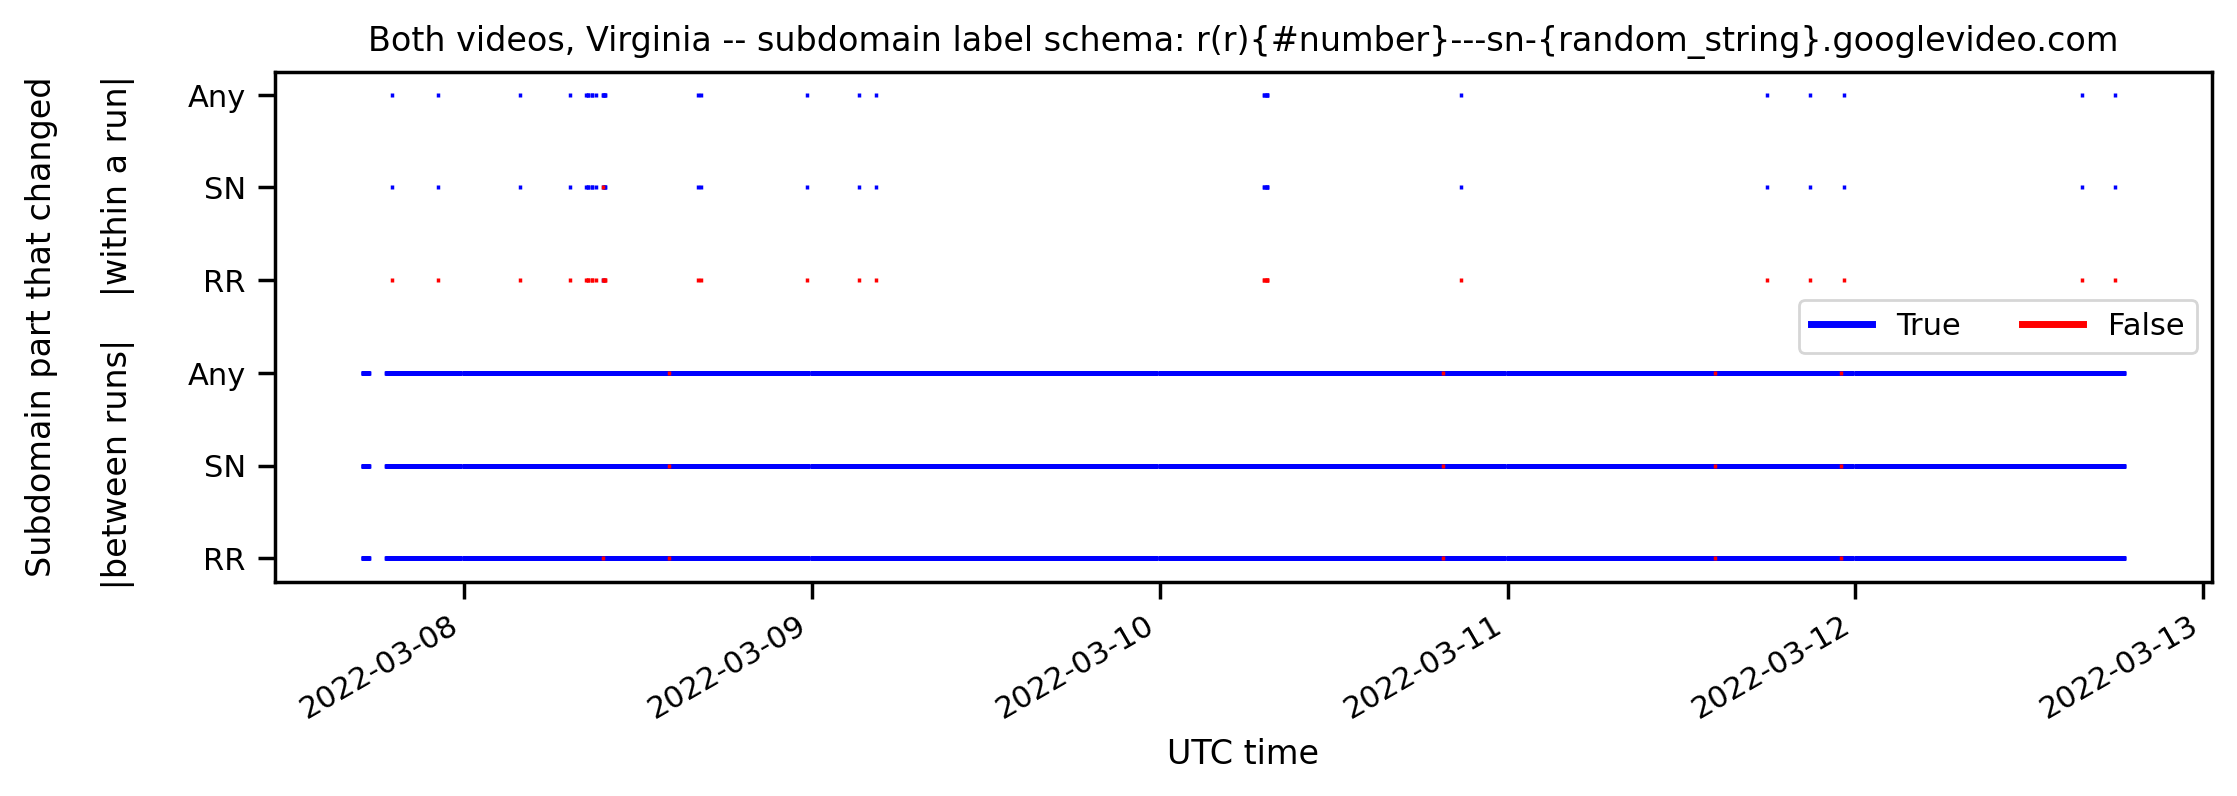

In [587]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_use[(lookups_use[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker="|", markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Both videos, Virginia -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

/tmp/ipykernel_17564/1577895619.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2078
True     2039
Name: subdomain_changed_btw_msm, dtype: int64


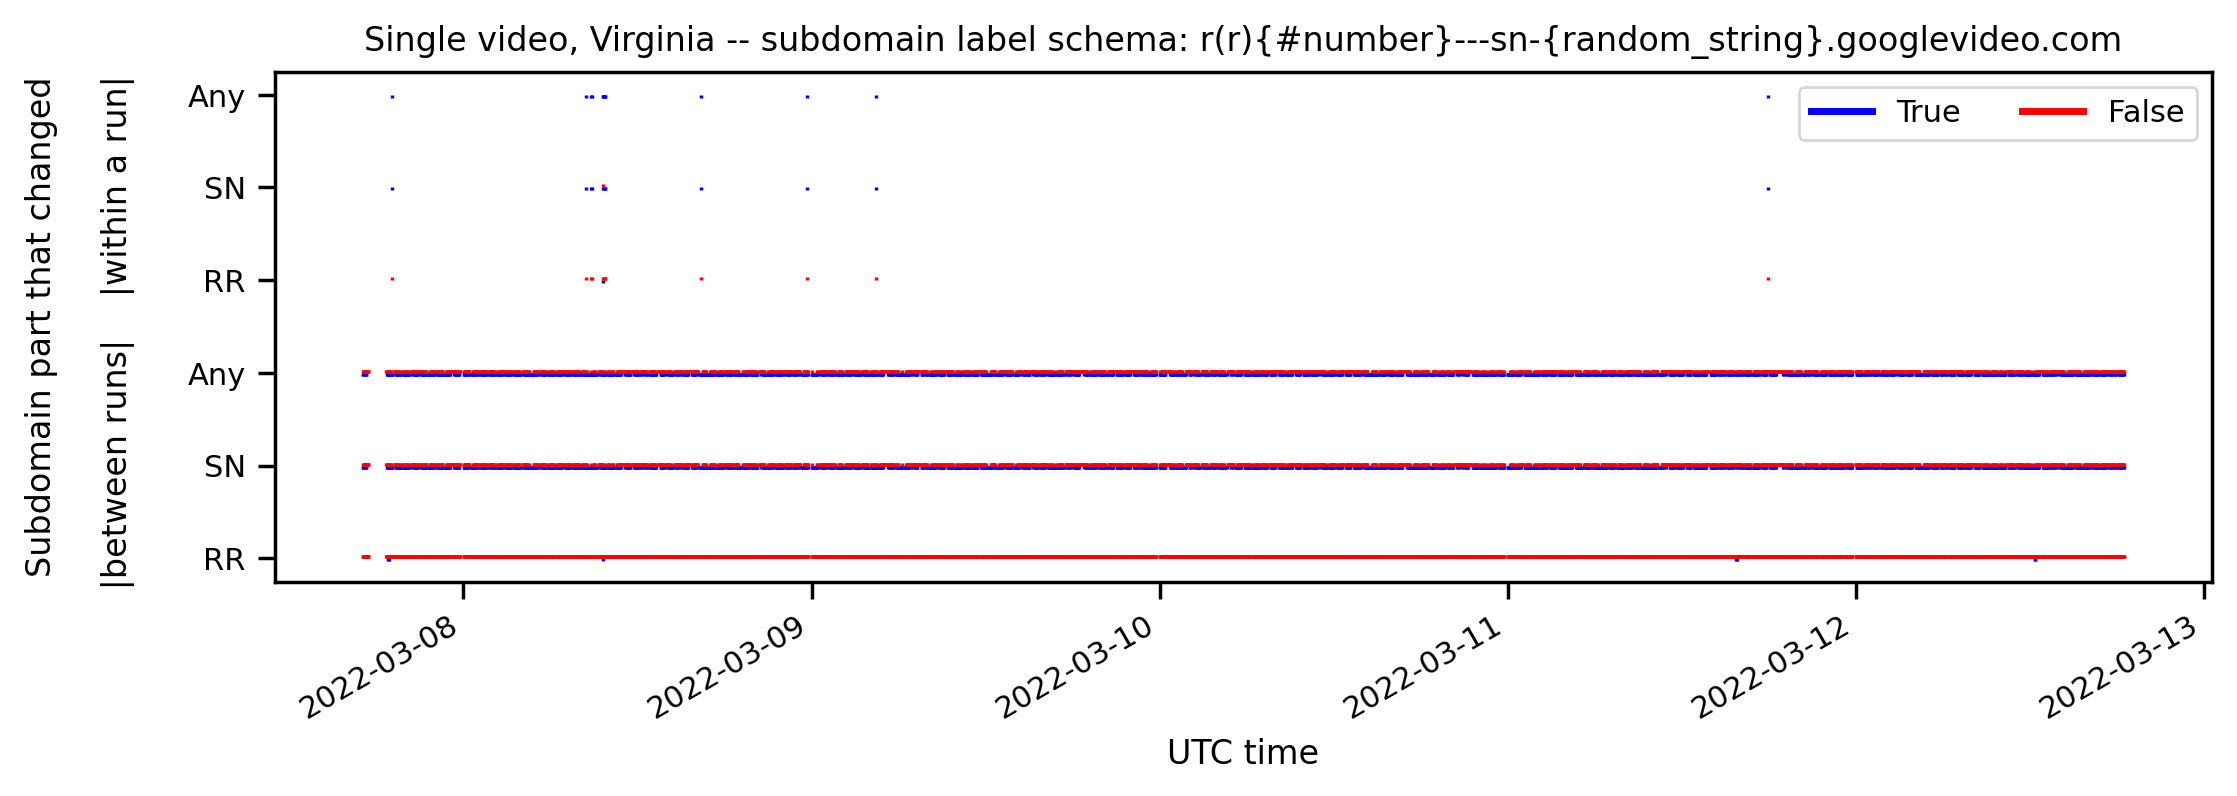

In [758]:
lookups_use_single_video = lookups_use[lookups_use.video_id == 'aqz-KE-bpKQ'].copy()
lookups_use_single_video.reset_index(drop=True, inplace=True)
lookups_use_single_video['rr_changed_btw_msm'] = np.nan
lookups_use_single_video['sn_changed_btw_msm'] = np.nan
lookups_use_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_use_single_video['rr_changed_in_msm'] = np.nan
lookups_use_single_video['sn_changed_in_msm'] = np.nan
lookups_use_single_video['subdomain_changed_in_msm'] = np.nan
lookups_use_single_video = lookups_use_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_use_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_use_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_use_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_use_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_use_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_use_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_use_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_use_single_video[(lookups_use_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Virginia -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_use_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

/tmp/ipykernel_17564/2208240698.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


True     2067
False    2050
Name: subdomain_changed_btw_msm, dtype: int64


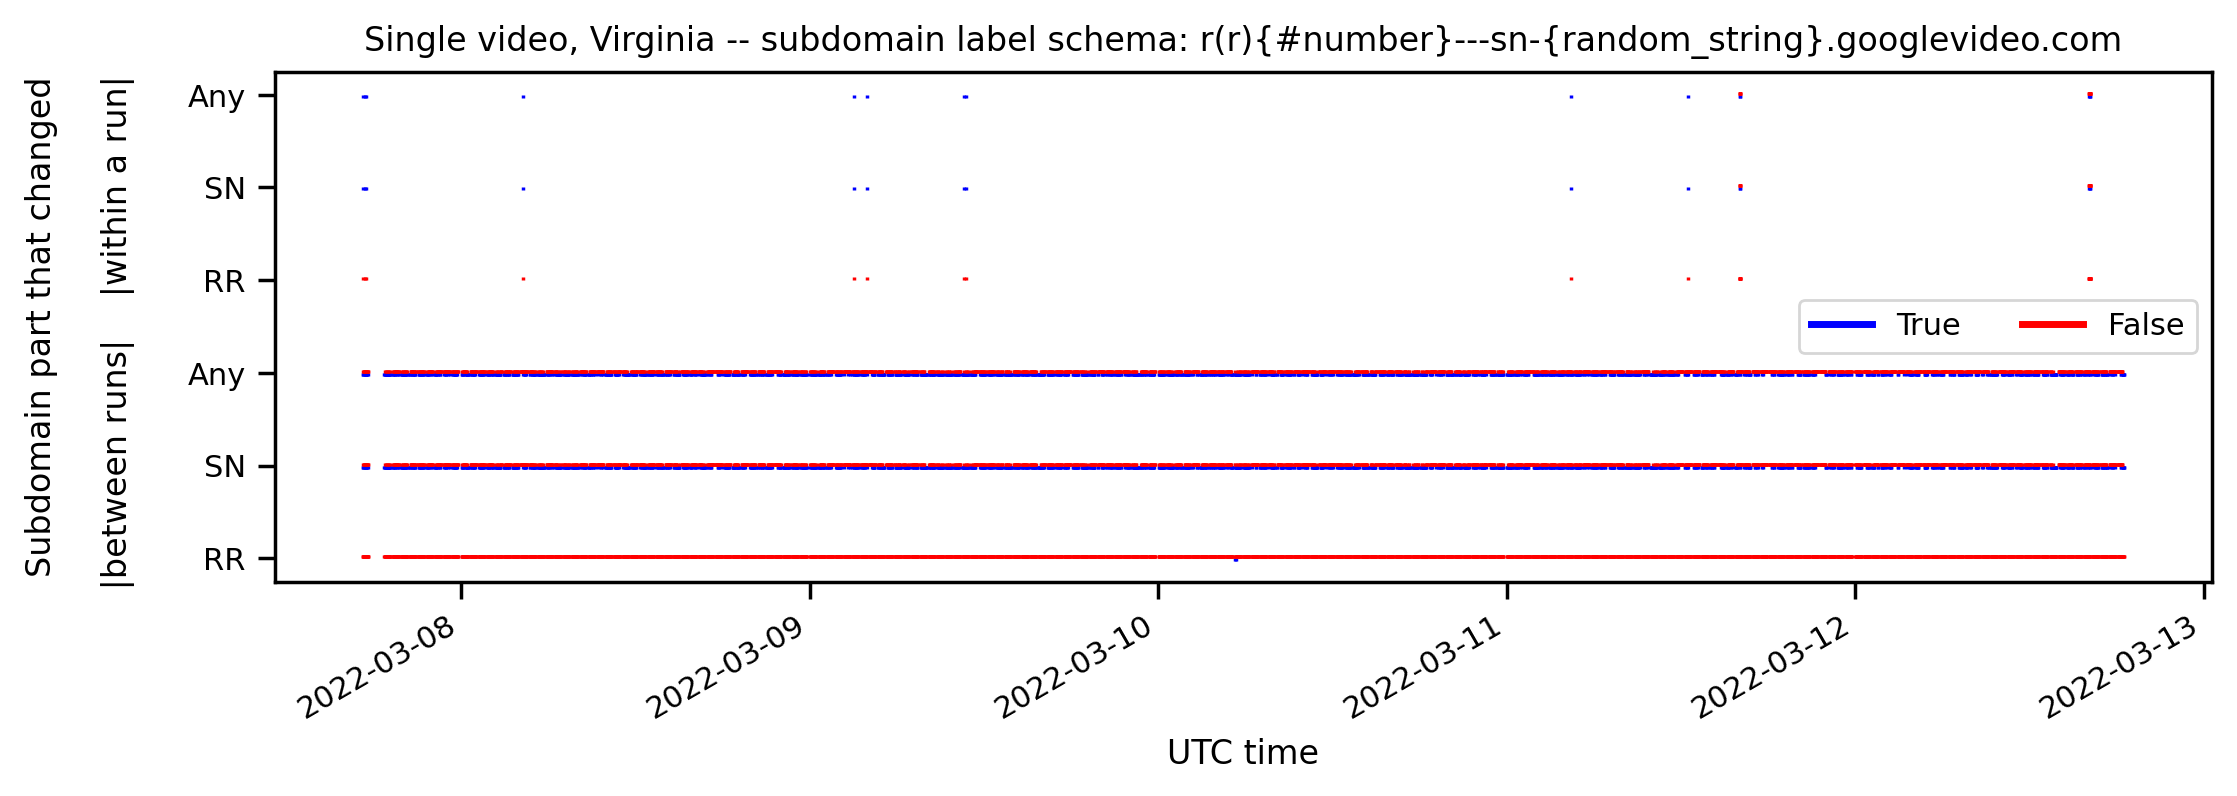

In [759]:
lookups_use_single_video = lookups_use[lookups_use.video_id == 'lqiN98z6Dak'].copy()
lookups_use_single_video.reset_index(drop=True, inplace=True)
lookups_use_single_video['rr_changed_btw_msm'] = np.nan
lookups_use_single_video['sn_changed_btw_msm'] = np.nan
lookups_use_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_use_single_video['rr_changed_in_msm'] = np.nan
lookups_use_single_video['sn_changed_in_msm'] = np.nan
lookups_use_single_video['subdomain_changed_in_msm'] = np.nan
lookups_use_single_video = lookups_use_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_use_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_use_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_use_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_use_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_use_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_use_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_use_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_use_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_usw_single_video[(lookups_usw_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Virginia -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_use_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

In [592]:
measurements.vantagePoint.unique()

array(['Africa South', 'Asia Pacific Northeast', 'Asia Pacific Southeast',
       'Europe Central', 'South America East', 'US East', 'US West'],
      dtype=object)

### South Africa

In [593]:
measurements_sa = measurements[measurements.vantagePoint == 'Africa South'].copy()
lookups_sa = lookups[lookups.msm_id.isin(measurements_sa.msm_id.unique())].copy()
googlevideo_subdomains_sa = googlevideo_subdomains[googlevideo_subdomains.msm_id.isin(measurements_sa.msm_id.unique())].copy()
googlevideo_requests_sa = googlevideo_requests[googlevideo_requests.msm_id.isin(measurements_sa.msm_id.unique())].copy()
measurements_sa.reset_index(drop=True, inplace=True)
lookups_sa.reset_index(drop=True, inplace=True)

In [594]:
lookups_sa[lookups_sa.status == 'NOERROR'].groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r2---sn-5hnekn7z,1,74.125.100.103
1,r2---sn-woc7ln7y,1,173.194.128.167
2,r4---sn-5hnekn7k,1,209.85.226.73
3,r4---sn-woc7ln7y,1,173.194.128.169
5,rr2---sn-4g5ednly,1,173.194.187.231
6,rr2---sn-5hne6nsr,1,172.217.132.71
7,rr2---sn-5hnekn7z,1,74.125.100.103
8,rr2---sn-woc7ln7y,1,173.194.128.167
9,rr4---sn-5hne6nz6,1,74.125.100.201
10,rr4---sn-5hnedn7e,1,74.125.100.138


In [595]:
measurements_sa.error.unique()

array(['',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: stale element reference: element is not attached to the page document\n  (Session info: headless chrome=96.0.4664.45)\nStacktrace:\n#0 0x5599148e7ee3 <unknown>\n#1 0x5599143b5608 <unknown>\n#2 0x5599143b848c <unknown>\n#3 0x5599143b8286 <unknown>\n#4 0x5599143b8e42 <unknown>\n#5 0x55991441d0a3 <unknown>\n#6 0x559914409272 <unknown>\n#7 0x55991441c3bc <unknown>\n#8 0x559914409163 <unknown>\n#9 0x5599143debfc <unknown>\n#10 0x5599143dfc05 <unknown>\n#11 0x559914919baa <unknown>\n#12 0x55991492f651 <unknown>\n#13 0x55991491ab05 <unknown>\n#14 0x559914930a68 <unknown>\n#15 0x55991490f05f <unknown>\n#16 0x55991494b818 <unknown>\n#17 0x55991494b998 <unknown>\n#18 0x559914966eed <unknown>\n#19 0x7f9aa94a4609 <unknown>\n',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n',
       'failed switching selenium focus to youtube iframe or monitoring loop ##

In [596]:
lookups_sa[lookups_sa.status != 'NOERROR']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
9656,8c063aa3-50a8-911d-f8d6-4d3dbbc1d359,rr2---sn-5hne6nsr.googlevideo.com.,10002.268395,SERVFAIL,read udp 172.31.27.22:39745->185.121.25.64:53:...,read udp 172.31.27.22:39745->185.121.25.64:53:...,rr2,sn-5hne6nsr,rr2---sn-5hne6nsr,rr2---sn-5hne6nsr-read udp 172.31.27.22:39745-...,rr2---sn-5hne6nsr.googlevideo.com,2022-03-12 00:25:59.724600064,read udp 172.31.27.22:39745->185.121.25,read udp 172.31.27.22:39745->185.121,aqz-KE-bpKQ,1920x1080,2022-03-12 00:25:41.031223


In [597]:
lookups_sa = lookups_sa[lookups_sa.status == 'NOERROR']

In [598]:
lookups_sa[lookups_sa.video_subdomain == 'redirector'].video_id.value_counts()

lqiN98z6Dak    4
aqz-KE-bpKQ    3
Name: video_id, dtype: int64

In [599]:
lookups_sa[lookups_sa.video_subdomain != 'redirector'].groupby('rand_sn_str').agg(rr_count=('round_robin_str', pd.Series.nunique)).sort_values('rr_count')

,rr_count
rand_sn_str,
sn-4g5ednly,1
sn-5hne6nsr,1
sn-5hne6nz6,1
sn-5hnedn7e,1
sn-5hnekn7k,2
sn-5hnekn7z,2
sn-woc7ln7y,4


In [600]:
lookups_sa[lookups_sa.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1).groupby('rand_sn_str', as_index=False).agg(rr_strs=('round_robin_str', pd.Series.unique))

,rand_sn_str,rr_strs
0,sn-5hnekn7k,"[rr4, r4]"
1,sn-5hnekn7z,"[rr2, r2]"
2,sn-woc7ln7y,"[rr2, rr4, r4, r2]"


In [601]:
lookups_sa = lookups_sa[lookups_sa.video_subdomain != 'redirector']
lookups_sa.reset_index(drop=True, inplace=True)
lookups_sa['rr_changed_btw_msm'] = np.nan
lookups_sa['sn_changed_btw_msm'] = np.nan
lookups_sa['subdomain_changed_btw_msm'] = np.nan
lookups_sa['rr_changed_in_msm'] = np.nan
lookups_sa['sn_changed_in_msm'] = np.nan
lookups_sa['subdomain_changed_in_msm'] = np.nan
lookups_sa = lookups_sa.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_sa.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_sa.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_sa.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_sa.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_sa.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_sa.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_sa.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_sa.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_sa.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_sa.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_sa.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_sa.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_sa.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row

print(lookups_sa['ip_addr/24'].nunique())
print(lookups_sa['rand_sn_str'].nunique())

/tmp/ipykernel_17564/3772483349.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


5
7


In [602]:
lookups_sa.groupby('rand_sn_str', as_index=False).agg(count24=('ip_addr/24', pd.Series.nunique), count16=('ip_addr/16', pd.Series.nunique)).sort_values('count16')

,rand_sn_str,count24,count16
0,sn-4g5ednly,1,1
1,sn-5hne6nsr,1,1
2,sn-5hne6nz6,1,1
3,sn-5hnedn7e,1,1
4,sn-5hnekn7k,1,1
5,sn-5hnekn7z,1,1
6,sn-woc7ln7y,1,1


In [603]:
lookups_sa.groupby('ip_addr/24', as_index=False).agg(count_sn=('rand_sn_str', pd.Series.unique))

,ip_addr/24,count_sn
0,172.217.132,sn-5hne6nsr
1,173.194.128,sn-woc7ln7y
2,173.194.187,sn-4g5ednly
3,209.85.226,sn-5hnekn7k
4,74.125.100,"[sn-5hnekn7z, sn-5hne6nz6, sn-5hnedn7e]"


In [604]:
lookups_sa['sn_length'] = lookups_sa['rand_sn_str'].str.len()
print(lookups_sa.sn_length.value_counts())

11    11206
Name: sn_length, dtype: int64


In [605]:
lookups_sa.groupby('ip_addr/24', as_index=False).agg(count_sn_overlap=('rand_sn_str', lambda x: count_largest_sn_overlap(pd.Series.unique(x).tolist())), sn_overlap=('rand_sn_str', lambda x: largest_sn_overlap(pd.Series.unique(x).tolist())))

,ip_addr/24,count_sn_overlap,sn_overlap
0,172.217.132,11,sn-5hne6nsr
1,173.194.128,11,sn-woc7ln7y
2,173.194.187,11,sn-4g5ednly
3,209.85.226,11,sn-5hnekn7k
4,74.125.100,7,sn-5hne


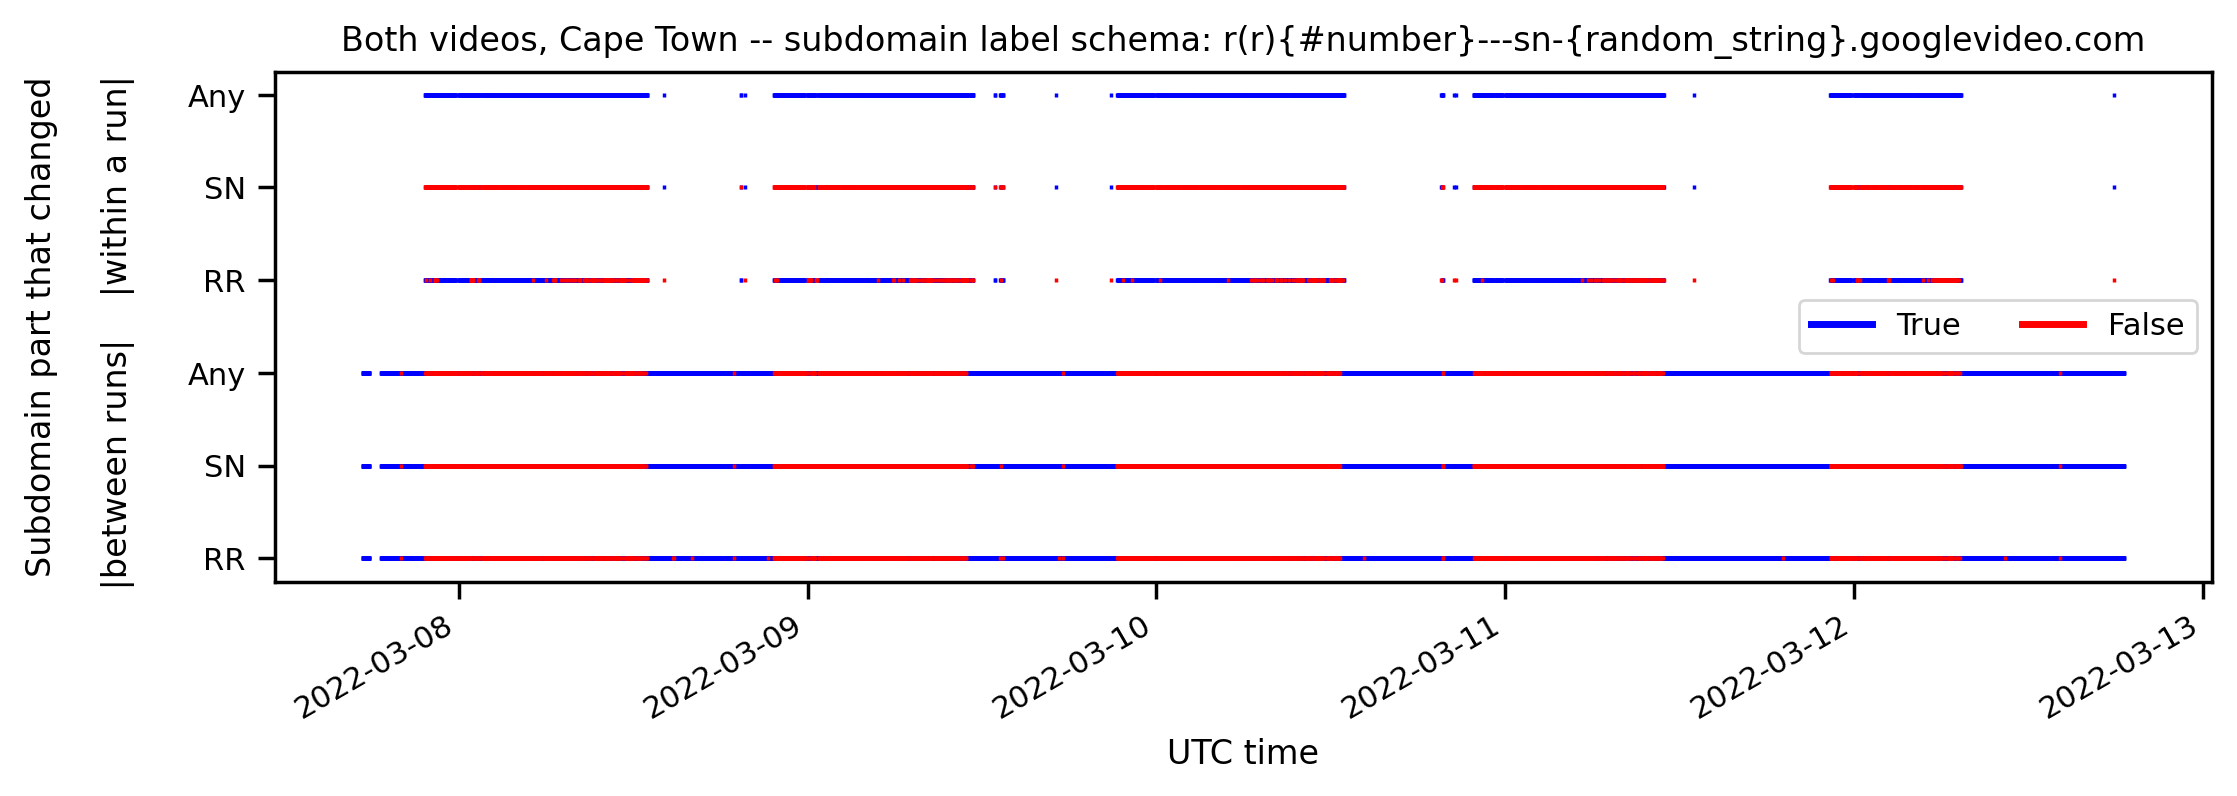

In [606]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_sa[(lookups_sa[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker="|", markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Both videos, Cape Town -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

/tmp/ipykernel_17564/1782338029.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


True     3056
False    1042
Name: subdomain_changed_btw_msm, dtype: int64


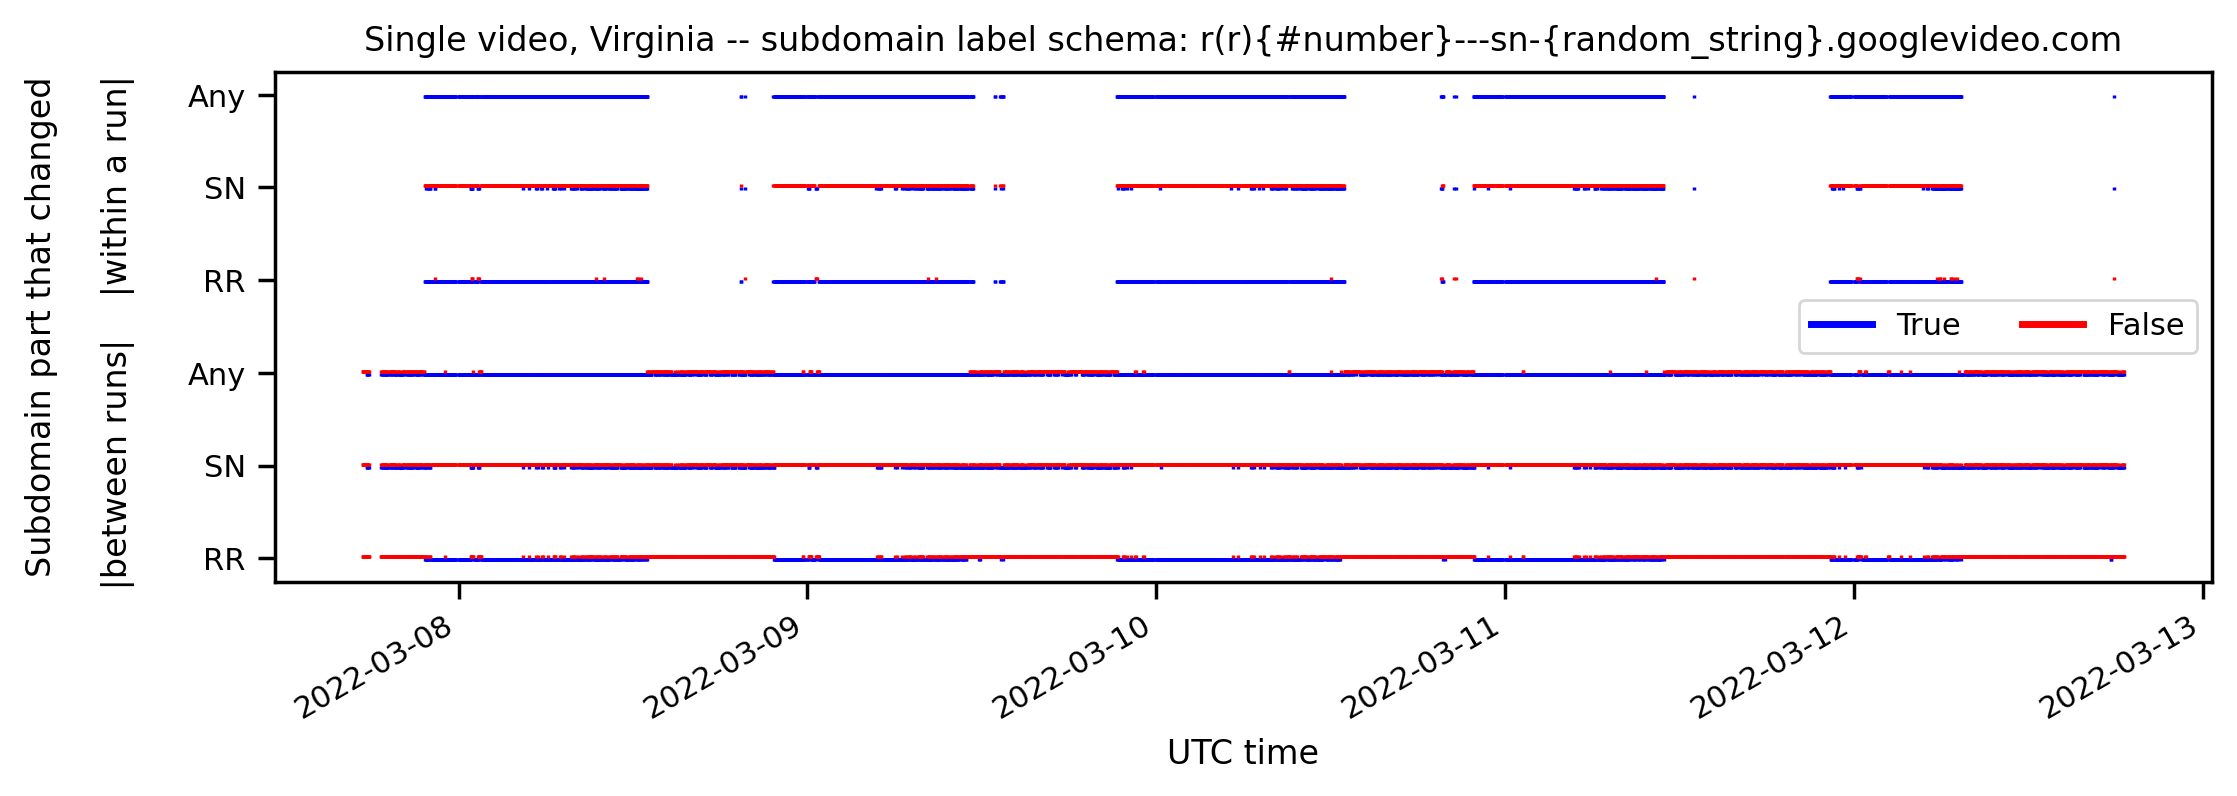

In [760]:
lookups_sa_single_video = lookups_sa[lookups_sa.video_id == 'aqz-KE-bpKQ'].copy()
lookups_sa_single_video.reset_index(drop=True, inplace=True)
lookups_sa_single_video['rr_changed_btw_msm'] = np.nan
lookups_sa_single_video['sn_changed_btw_msm'] = np.nan
lookups_sa_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_sa_single_video['rr_changed_in_msm'] = np.nan
lookups_sa_single_video['sn_changed_in_msm'] = np.nan
lookups_sa_single_video['subdomain_changed_in_msm'] = np.nan
lookups_sa_single_video = lookups_sa_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_sa_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_sa_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_sa_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_sa_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_sa_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_sa_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_sa_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_sa_single_video[(lookups_sa_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Virginia -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_sa_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

/tmp/ipykernel_17564/561970849.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2946
True     1172
Name: subdomain_changed_btw_msm, dtype: int64


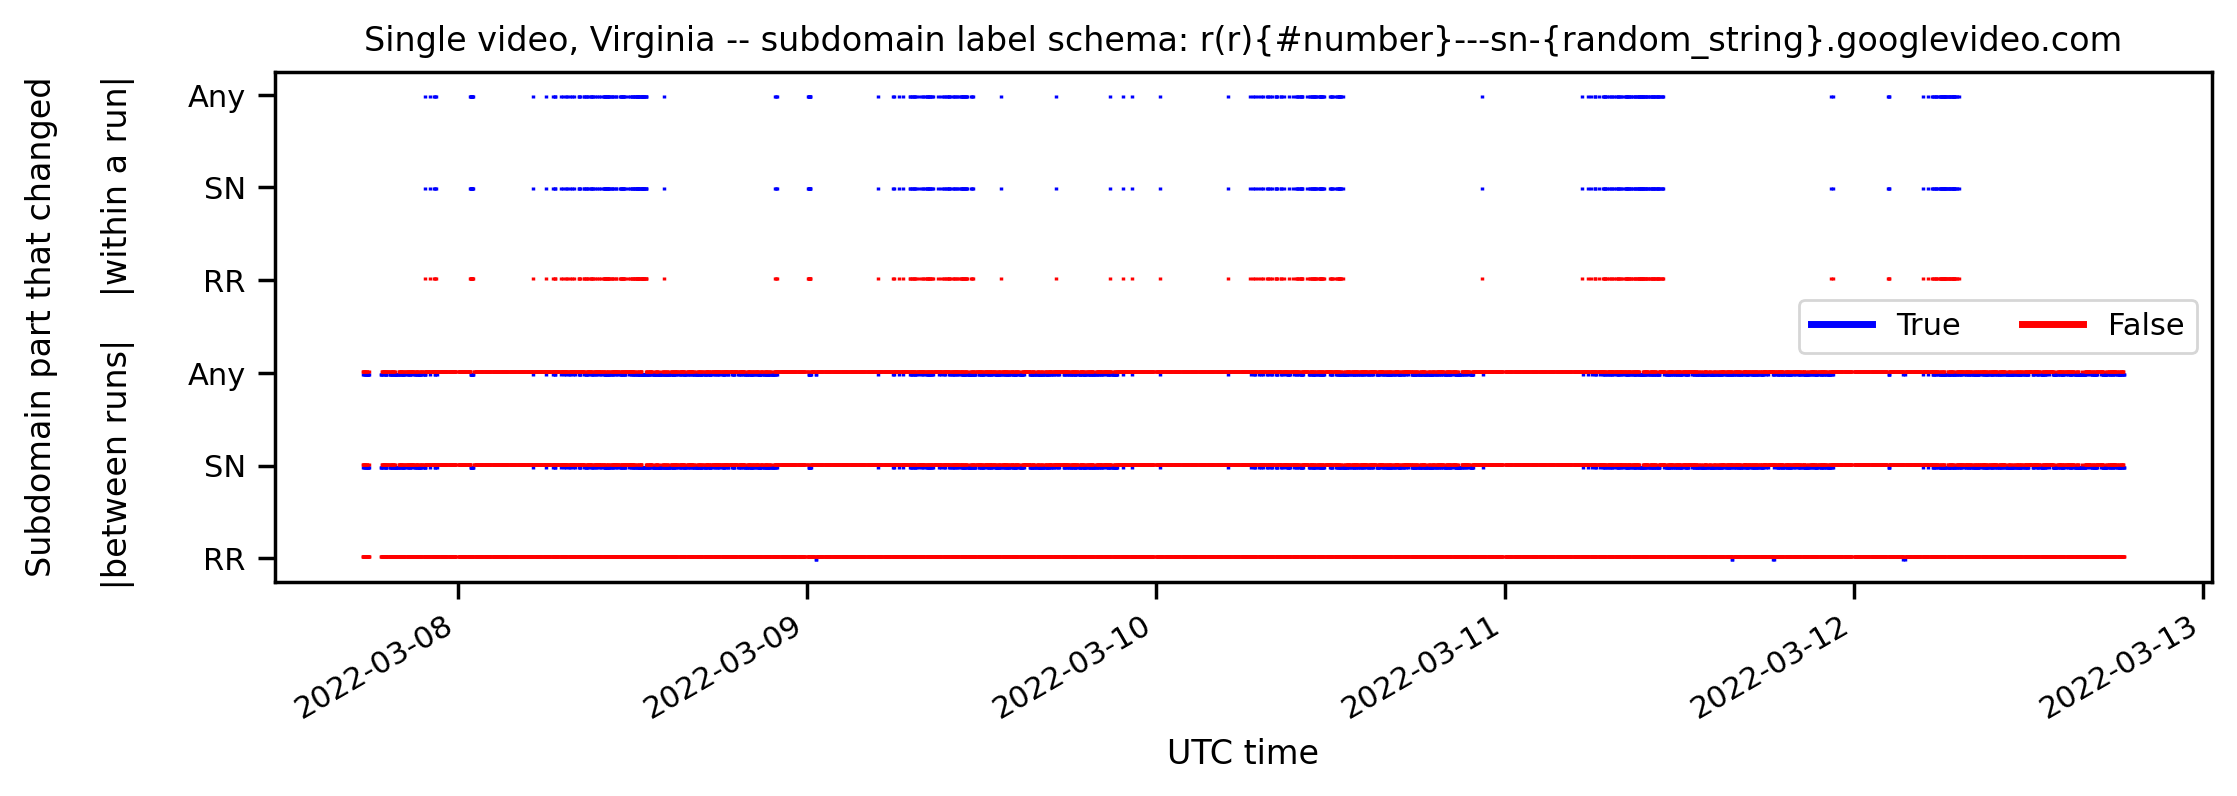

In [761]:
lookups_sa_single_video = lookups_sa[lookups_sa.video_id == 'lqiN98z6Dak'].copy()
lookups_sa_single_video.reset_index(drop=True, inplace=True)
lookups_sa_single_video['rr_changed_btw_msm'] = np.nan
lookups_sa_single_video['sn_changed_btw_msm'] = np.nan
lookups_sa_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_sa_single_video['rr_changed_in_msm'] = np.nan
lookups_sa_single_video['sn_changed_in_msm'] = np.nan
lookups_sa_single_video['subdomain_changed_in_msm'] = np.nan
lookups_sa_single_video = lookups_sa_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_sa_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_sa_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_sa_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_sa_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_sa_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_sa_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_sa_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_sa_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_sa_single_video[(lookups_sa_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Virginia -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_sa_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

### South America

In [609]:
measurements_br = measurements[measurements.vantagePoint == 'South America East'].copy()
lookups_br = lookups[lookups.msm_id.isin(measurements_br.msm_id.unique())].copy()
googlevideo_subdomains_br = googlevideo_subdomains[googlevideo_subdomains.msm_id.isin(measurements_br.msm_id.unique())].copy()
googlevideo_requests_br = googlevideo_requests[googlevideo_requests.msm_id.isin(measurements_br.msm_id.unique())].copy()
measurements_br.reset_index(drop=True, inplace=True)
lookups_br.reset_index(drop=True, inplace=True)

In [610]:
lookups_br[lookups_br.status == 'NOERROR'].groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r2---sn-bg07dn6r,1,173.194.136.39
15,rr4---sn-p5qs7n7d,1,74.125.155.234
14,rr4---sn-p5qlsn76,1,172.217.135.201
13,rr4---sn-bg0ezn7l,1,173.194.155.137
12,rr4---sn-bg07dnsl,1,173.194.161.42
11,rr2---sn-vgqsrnlk,1,74.125.156.103
10,rr2---sn-vgqsknez,1,173.194.191.71
9,rr2---sn-q4flrnss,1,173.194.57.103
8,rr2---sn-p5qlsn7s,1,172.217.135.167
7,rr2---sn-p5qddn7k,1,173.194.7.135


In [611]:
measurements_br.error.unique()

array(['',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n'],
      dtype=object)

In [613]:
lookups_br[lookups_br.status != 'NOERROR']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
236,40de5e49-5182-26a6-bbbf-f6fdc6065ca4,rr2---sn-bg07dn6r.googlevideo.com.,10002.889890,SERVFAIL,read udp 172.31.14.247:37841->94.140.14.14:53:...,read udp 172.31.14.247:37841->94.140.14.14:53:...,rr2,sn-bg07dn6r,rr2---sn-bg07dn6r,rr2---sn-bg07dn6r-read udp 172.31.14.247:37841...,rr2---sn-bg07dn6r.googlevideo.com,2022-03-07 21:23:32.631899904,read udp 172.31.14.247:37841->94.140.14,read udp 172.31.14.247:37841->94.140,aqz-KE-bpKQ,1280x720,2022-03-07 21:23:28.256389
242,5576cfe8-98c8-1734-6cb0-3fb7e850390d,rr2---sn-bg07dn6r.googlevideo.com.,10000.427241,SERVFAIL,read udp 172.31.14.247:53445->94.140.14.14:53:...,read udp 172.31.14.247:53445->94.140.14.14:53:...,rr2,sn-bg07dn6r,rr2---sn-bg07dn6r,rr2---sn-bg07dn6r-read udp 172.31.14.247:53445...,rr2---sn-bg07dn6r.googlevideo.com,2022-03-07 21:26:24.746200320,read udp 172.31.14.247:53445->94.140.14,read udp 172.31.14.247:53445->94.140,aqz-KE-bpKQ,2560x1440,2022-03-07 21:26:20.395562
288,d992d1df-643b-a26c-869e-d0429764b667,rr4---sn-bg07dnsl.googlevideo.com.,10002.191658,SERVFAIL,read udp 172.31.14.247:58414->94.140.14.14:53:...,read udp 172.31.14.247:58414->94.140.14.14:53:...,rr4,sn-bg07dnsl,rr4---sn-bg07dnsl,rr4---sn-bg07dnsl-read udp 172.31.14.247:58414...,rr4---sn-bg07dnsl.googlevideo.com,2022-03-07 22:03:46.516699904,read udp 172.31.14.247:58414->94.140.14,read udp 172.31.14.247:58414->94.140,lqiN98z6Dak,3840x2160,2022-03-07 22:03:42.007723
329,23e7f2fb-4354-6105-0500-48be31f8cb5f,rr2---sn-bg07dn6r.googlevideo.com.,10003.840722,SERVFAIL,read udp 172.31.14.247:58680->94.140.14.14:53:...,read udp 172.31.14.247:58680->94.140.14.14:53:...,rr2,sn-bg07dn6r,rr2---sn-bg07dn6r,rr2---sn-bg07dn6r-read udp 172.31.14.247:58680...,rr2---sn-bg07dn6r.googlevideo.com,2022-03-07 22:37:55.665899776,read udp 172.31.14.247:58680->94.140.14,read udp 172.31.14.247:58680->94.140,aqz-KE-bpKQ,3840x2160,2022-03-07 22:37:51.314072
405,847adfbd-4c13-0b91-b0fb-15c4b1eefd5e,rr2---sn-bg07dn6r.googlevideo.com.,10001.539309,SERVFAIL,read udp 172.31.14.247:60318->94.140.14.14:53:...,read udp 172.31.14.247:60318->94.140.14.14:53:...,rr2,sn-bg07dn6r,rr2---sn-bg07dn6r,rr2---sn-bg07dn6r-read udp 172.31.14.247:60318...,rr2---sn-bg07dn6r.googlevideo.com,2022-03-07 23:43:31.530900224,read udp 172.31.14.247:60318->94.140.14,read udp 172.31.14.247:60318->94.140,aqz-KE-bpKQ,1280x720,2022-03-07 23:43:27.152193
414,d806da72-8c97-671a-6db6-71b05337bd26,rr2---sn-bg0eznek.googlevideo.com.,10001.054882,SERVFAIL,read udp 172.31.14.247:43530->94.140.14.14:53:...,read udp 172.31.14.247:43530->94.140.14.14:53:...,rr2,sn-bg0eznek,rr2---sn-bg0eznek,rr2---sn-bg0eznek-read udp 172.31.14.247:43530...,rr2---sn-bg0eznek.googlevideo.com,2022-03-07 23:47:50.320099840,read udp 172.31.14.247:43530->94.140.14,read udp 172.31.14.247:43530->94.140,aqz-KE-bpKQ,3840x2160,2022-03-07 23:47:45.939577
458,498bf81e-9dff-15a0-9bac-7fd29fe8cfa8,rr2---sn-bg07dn6r.googlevideo.com.,10000.910592,SERVFAIL,read udp 172.31.14.247:42041->94.140.14.14:53:...,read udp 172.31.14.247:42041->94.140.14.14:53:...,rr2,sn-bg07dn6r,rr2---sn-bg07dn6r,rr2---sn-bg07dn6r-read udp 172.31.14.247:42041...,rr2---sn-bg07dn6r.googlevideo.com,2022-03-08 00:28:06.710200320,read udp 172.31.14.247:42041->94.140.14,read udp 172.31.14.247:42041->94.140,aqz-KE-bpKQ,3840x2160,2022-03-08 00:28:02.366458
1798,4f162c58-4ec4-963e-0cc0-b99cc7345db0,rr2---sn-bg07dn6r.googlevideo.com.,10000.409937,SERVFAIL,read udp 172.31.14.247:34900->94.140.14.14:53:...,read udp 172.31.14.247:34900->94.140.14.14:53:...,rr2,sn-bg07dn6r,rr2---sn-bg07dn6r,rr2---sn-bg07dn6r-read udp 172.31.14.247:34900...,rr2---sn-bg07dn6r.googlevideo.com,2022-03-08 19:38:50.012499968,read udp 172.31.14.247:34900->94.140.14,read udp 172.31.14.247:34900->94.140,aqz-KE-bpKQ,1280x720,2022-03-08 19:38:45.570143
2129,a2348a32-197d-fd7b-ceb8-53ed

In [614]:
lookups_br = lookups_br[lookups_br.status == 'NOERROR']

In [615]:
lookups_br[lookups_br.video_subdomain == 'redirector'].video_id.value_counts()

aqz-KE-bpKQ    8
lqiN98z6Dak    2
Name: video_id, dtype: int64

In [616]:
lookups_br[lookups_br.video_subdomain != 'redirector'].groupby('rand_sn_str').agg(rr_count=('round_robin_str', pd.Series.nunique)).sort_values('rr_count')

,rr_count
rand_sn_str,
sn-p5qddn7k,1
sn-p5qlsn76,1
sn-p5qlsn7s,1
sn-p5qs7n7d,1
sn-q4flrn7r,1
sn-q4flrnss,1
sn-vgqsknez,1
sn-vgqsrnlk,1
sn-vgqsrnlz,1


In [617]:
lookups_br[lookups_br.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1).groupby('rand_sn_str', as_index=False).agg(rr_strs=('round_robin_str', pd.Series.unique))

,rand_sn_str,rr_strs
0,sn-bg07dn6r,"[rr2, r2]"
1,sn-bg07dnsl,"[rr4, r4]"
2,sn-bg0ezn7l,"[rr4, r4]"
3,sn-bg0eznek,"[rr2, r2]"


In [618]:
lookups_br = lookups_br[lookups_br.video_subdomain != 'redirector']
lookups_br.reset_index(drop=True, inplace=True)
lookups_br['rr_changed_btw_msm'] = np.nan
lookups_br['sn_changed_btw_msm'] = np.nan
lookups_br['subdomain_changed_btw_msm'] = np.nan
lookups_br['rr_changed_in_msm'] = np.nan
lookups_br['sn_changed_in_msm'] = np.nan
lookups_br['subdomain_changed_in_msm'] = np.nan
lookups_br = lookups_br.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_br.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_br.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_br.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_br.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_br.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_br.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_br.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_br.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_br.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_br.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_br.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_br.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_br.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row

print(lookups_br['ip_addr/24'].nunique())
print(lookups_br['rand_sn_str'].nunique())

/tmp/ipykernel_17564/1713325798.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


11
13


In [619]:
lookups_br.groupby('rand_sn_str', as_index=False).agg(count24=('ip_addr/24', pd.Series.nunique), count16=('ip_addr/16', pd.Series.nunique)).sort_values('count16')

,rand_sn_str,count24,count16
0,sn-bg07dn6r,1,1
1,sn-bg07dnsl,1,1
2,sn-bg0ezn7l,1,1
3,sn-bg0eznek,1,1
4,sn-p5qddn7k,1,1
5,sn-p5qlsn76,1,1
6,sn-p5qlsn7s,1,1
7,sn-p5qs7n7d,1,1
8,sn-q4flrn7r,1,1
9,sn-q4flrnss,1,1


In [620]:
lookups_br.groupby('ip_addr/24', as_index=False).agg(count_sn=('rand_sn_str', pd.Series.unique))

,ip_addr/24,count_sn
0,172.217.135,"[sn-p5qlsn7s, sn-p5qlsn76]"
1,173.194.136,sn-bg07dn6r
2,173.194.155,sn-bg0ezn7l
3,173.194.161,sn-bg07dnsl
4,173.194.191,sn-vgqsknez
5,173.194.57,sn-q4flrnss
6,173.194.7,sn-p5qddn7k
7,209.85.165,sn-q4flrn7r
8,74.125.107,sn-bg0eznek
9,74.125.155,sn-p5qs7n7d


In [621]:
lookups_br['sn_length'] = lookups_br['rand_sn_str'].str.len()
print(lookups_br.sn_length.value_counts())

11    8302
Name: sn_length, dtype: int64


In [622]:
lookups_br.groupby('ip_addr/24', as_index=False).agg(count_sn_overlap=('rand_sn_str', lambda x: count_largest_sn_overlap(pd.Series.unique(x).tolist())), sn_overlap=('rand_sn_str', lambda x: largest_sn_overlap(pd.Series.unique(x).tolist())))

,ip_addr/24,count_sn_overlap,sn_overlap
0,172.217.135,10,sn-p5qlsn7
1,173.194.136,11,sn-bg07dn6r
2,173.194.155,11,sn-bg0ezn7l
3,173.194.161,11,sn-bg07dnsl
4,173.194.191,11,sn-vgqsknez
5,173.194.57,11,sn-q4flrnss
6,173.194.7,11,sn-p5qddn7k
7,209.85.165,11,sn-q4flrn7r
8,74.125.107,11,sn-bg0eznek
9,74.125.155,11,sn-p5qs7n7d


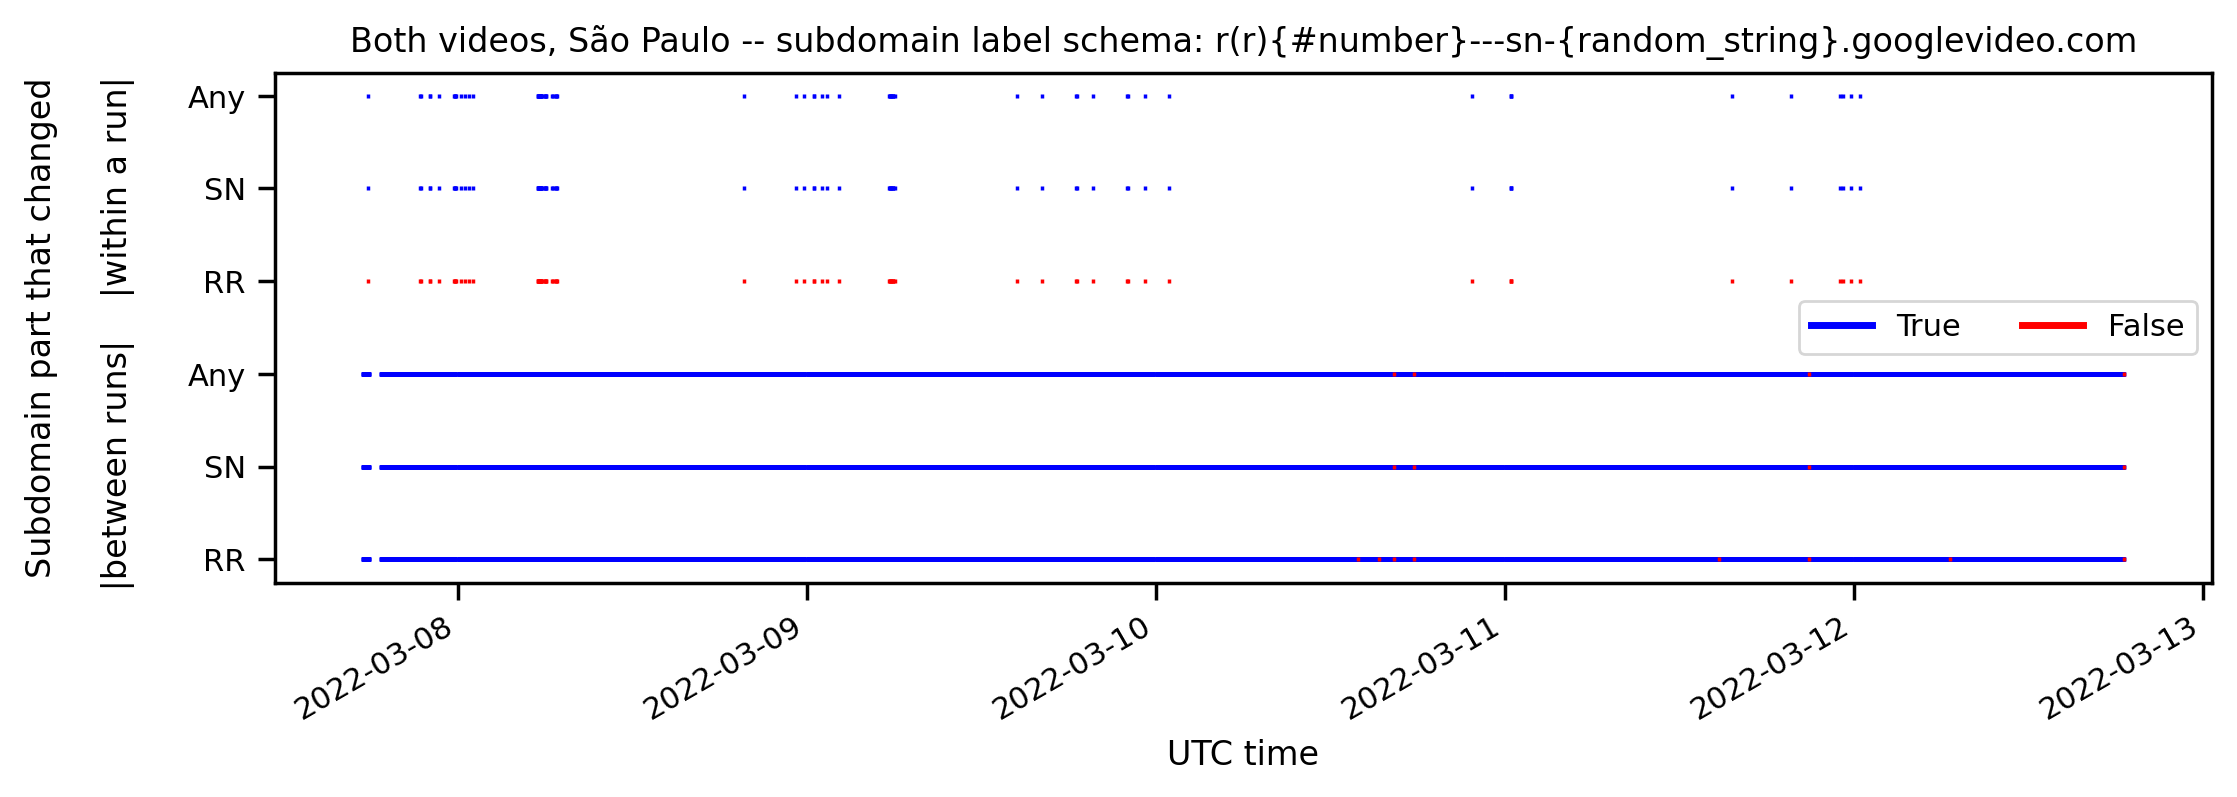

In [623]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_br[(lookups_br[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker="|", markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Both videos, São Paulo -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

/tmp/ipykernel_17564/1324926495.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2304
True     1807
Name: subdomain_changed_btw_msm, dtype: int64


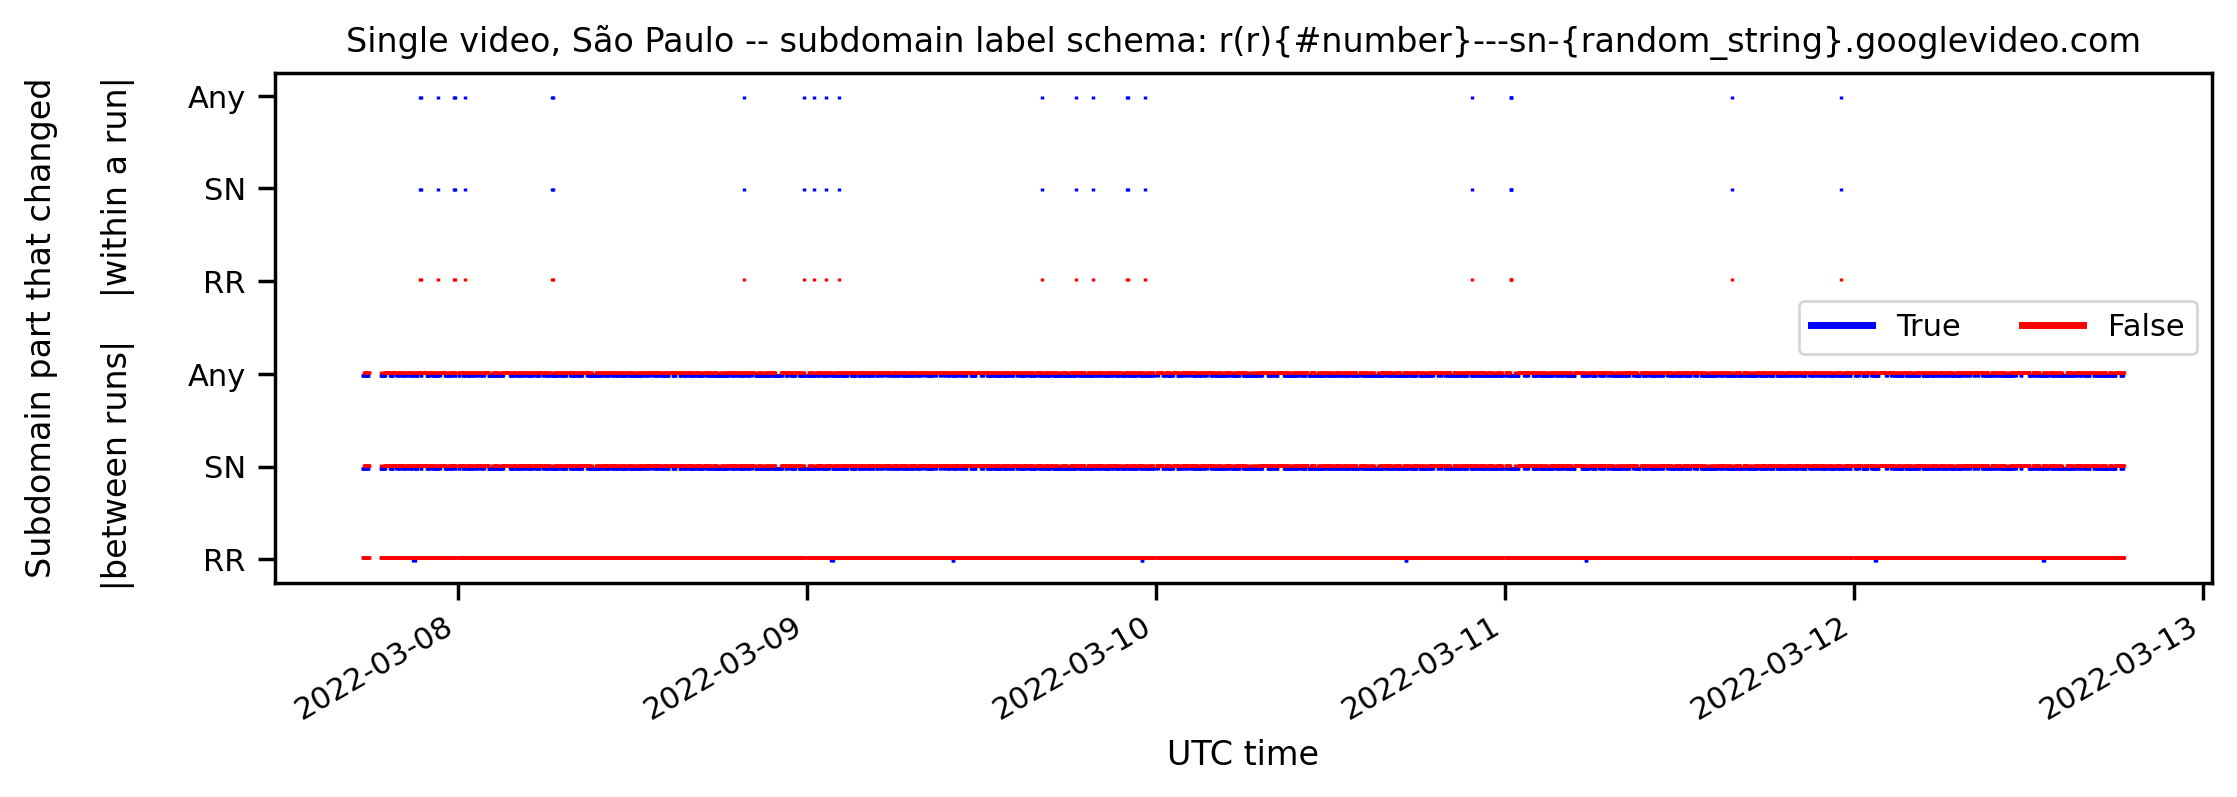

In [762]:
lookups_br_single_video = lookups_br[lookups_br.video_id == 'aqz-KE-bpKQ'].copy()
lookups_br_single_video.reset_index(drop=True, inplace=True)
lookups_br_single_video['rr_changed_btw_msm'] = np.nan
lookups_br_single_video['sn_changed_btw_msm'] = np.nan
lookups_br_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_br_single_video['rr_changed_in_msm'] = np.nan
lookups_br_single_video['sn_changed_in_msm'] = np.nan
lookups_br_single_video['subdomain_changed_in_msm'] = np.nan
lookups_br_single_video = lookups_br_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_br_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_br_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_br_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_br_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_br_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_br_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_br_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_br_single_video[(lookups_br_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, São Paulo -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_br_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

/tmp/ipykernel_17564/66507357.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2314
True     1805
Name: subdomain_changed_btw_msm, dtype: int64


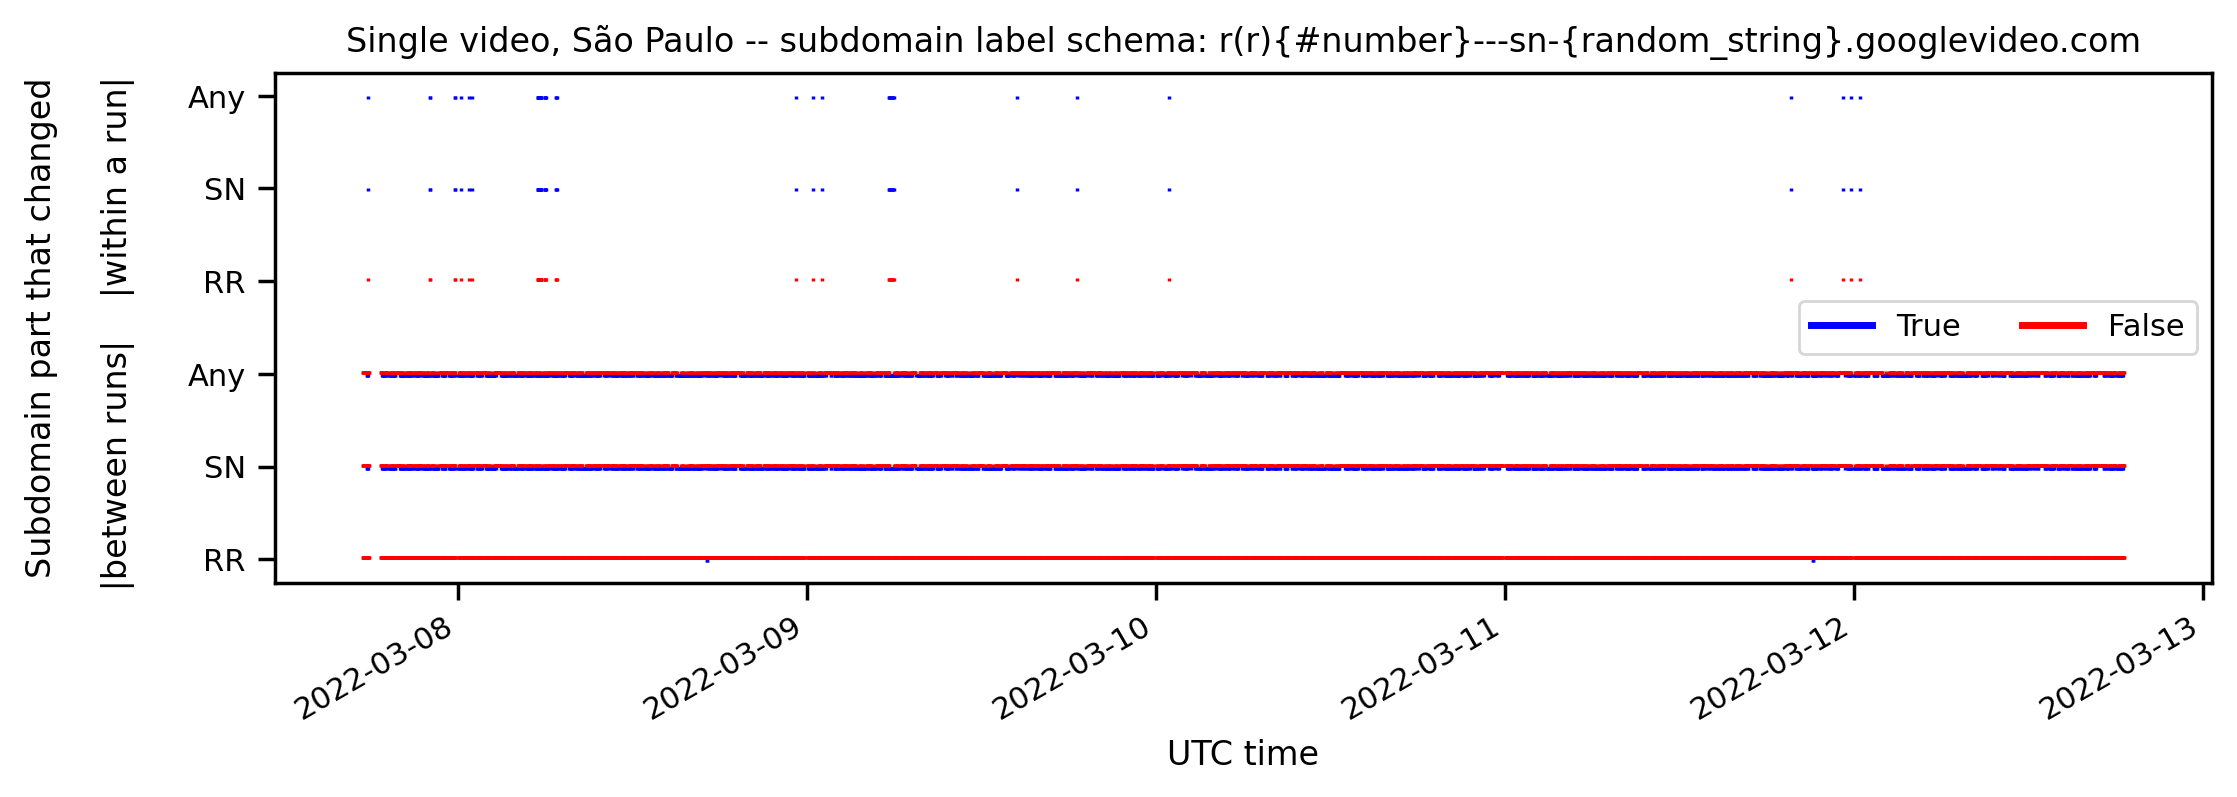

In [763]:
lookups_br_single_video = lookups_br[lookups_br.video_id == 'lqiN98z6Dak'].copy()
lookups_br_single_video.reset_index(drop=True, inplace=True)
lookups_br_single_video['rr_changed_btw_msm'] = np.nan
lookups_br_single_video['sn_changed_btw_msm'] = np.nan
lookups_br_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_br_single_video['rr_changed_in_msm'] = np.nan
lookups_br_single_video['sn_changed_in_msm'] = np.nan
lookups_br_single_video['subdomain_changed_in_msm'] = np.nan
lookups_br_single_video = lookups_br_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_br_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_br_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_br_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_br_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_br_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_br_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_br_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_br_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_br_single_video[(lookups_br_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, São Paulo -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_br_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

In [627]:
measurements.vantagePoint.unique()

array(['Africa South', 'Asia Pacific Northeast', 'Asia Pacific Southeast',
       'Europe Central', 'South America East', 'US East', 'US West'],
      dtype=object)

### Japan

In [628]:
measurements_jp = measurements[measurements.vantagePoint == 'Asia Pacific Northeast'].copy()
lookups_jp = lookups[lookups.msm_id.isin(measurements_jp.msm_id.unique())].copy()
googlevideo_subdomains_jp = googlevideo_subdomains[googlevideo_subdomains.msm_id.isin(measurements_jp.msm_id.unique())].copy()
googlevideo_requests_jp = googlevideo_requests[googlevideo_requests.msm_id.isin(measurements_jp.msm_id.unique())].copy()
measurements_jp.reset_index(drop=True, inplace=True)
lookups_jp.reset_index(drop=True, inplace=True)

In [629]:
lookups_jp[lookups_jp.status == 'NOERROR'].groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r6---sn-3pm76n7s,1,209.85.229.172
1,r6---sn-3pm7sn7y,1,74.125.171.172
2,redirector,1,216.58.220.142
3,rr2---sn-npoe7nsl,1,173.194.59.39
4,rr2---sn-oguelnss,1,173.194.51.39
5,rr3---sn-npoe7nsl,1,173.194.59.40
6,rr4---sn-3pm76n7d,1,173.194.22.154
7,rr4---sn-3pm7dn7k,1,74.125.102.169
8,rr4---sn-npoe7nss,1,173.194.59.73
9,rr4---sn-oguelnl7,1,173.194.49.41


In [630]:
measurements_jp.error.unique()

array(['',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n'],
      dtype=object)

In [631]:
lookups_jp[lookups_jp.status != 'NOERROR']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
6571,4e20dce8-f676-71f1-e2f0-0d25b506dbf1,rr6---sn-oguesnz6.googlevideo.com.,10001.679703,SERVFAIL,read udp 172.31.42.48:60092->202.218.2.19:53: ...,read udp 172.31.42.48:60092->202.218.2.19:53: ...,rr6,sn-oguesnz6,rr6---sn-oguesnz6,rr6---sn-oguesnz6-read udp 172.31.42.48:60092-...,rr6---sn-oguesnz6.googlevideo.com,2022-03-11 17:55:09.782400,read udp 172.31.42.48:60092->202.218.2,read udp 172.31.42.48:60092->202.218,aqz-KE-bpKQ,3840x2160,2022-03-11 17:55:07.344252


In [632]:
lookups_jp = lookups_jp[lookups_jp.status == 'NOERROR']

In [633]:
lookups_jp[lookups_jp.video_subdomain == 'redirector'].video_id.value_counts()

aqz-KE-bpKQ    1
Name: video_id, dtype: int64

In [634]:
lookups_jp[lookups_jp.video_subdomain != 'redirector'].groupby('rand_sn_str').agg(rr_count=('round_robin_str', pd.Series.nunique)).sort_values('rr_count')

,rr_count
rand_sn_str,
sn-3pm76n7d,1
sn-3pm7dn7k,1
sn-npoe7nss,1
sn-oguelnl7,1
sn-oguelnss,1
sn-oguesn6k,1
sn-oguesnz6,1
sn-3pm76n7s,2
sn-3pm7sn7y,2


In [635]:
lookups_jp[lookups_jp.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1).groupby('rand_sn_str', as_index=False).agg(rr_strs=('round_robin_str', pd.Series.unique))

,rand_sn_str,rr_strs
0,sn-3pm76n7s,"[rr6, r6]"
1,sn-3pm7sn7y,"[rr6, r6]"
2,sn-npoe7nsl,"[rr2, rr3]"


In [636]:
lookups_jp = lookups_jp[lookups_jp.video_subdomain != 'redirector']
lookups_jp.reset_index(drop=True, inplace=True)
lookups_jp['rr_changed_btw_msm'] = np.nan
lookups_jp['sn_changed_btw_msm'] = np.nan
lookups_jp['subdomain_changed_btw_msm'] = np.nan
lookups_jp['rr_changed_in_msm'] = np.nan
lookups_jp['sn_changed_in_msm'] = np.nan
lookups_jp['subdomain_changed_in_msm'] = np.nan
lookups_jp = lookups_jp.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_jp.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_jp.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_jp.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_jp.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_jp.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_jp.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_jp.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_jp.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_jp.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_jp.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_jp.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_jp.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_jp.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row

print(lookups_jp['ip_addr/24'].nunique())
print(lookups_jp['rand_sn_str'].nunique())

/tmp/ipykernel_17564/2898356520.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


7
10


In [637]:
lookups_jp.groupby('rand_sn_str', as_index=False).agg(count24=('ip_addr/24', pd.Series.nunique), count16=('ip_addr/16', pd.Series.nunique)).sort_values('count16')

,rand_sn_str,count24,count16
0,sn-3pm76n7d,1,1
1,sn-3pm76n7s,1,1
2,sn-3pm7dn7k,1,1
3,sn-3pm7sn7y,1,1
4,sn-npoe7nsl,1,1
5,sn-npoe7nss,1,1
6,sn-oguelnl7,1,1
7,sn-oguelnss,1,1
8,sn-oguesn6k,1,1
9,sn-oguesnz6,1,1


In [638]:
lookups_jp.groupby('ip_addr/24', as_index=False).agg(count_sn=('rand_sn_str', pd.Series.unique))

,ip_addr/24,count_sn
0,173.194.22,sn-3pm76n7d
1,173.194.49,sn-oguelnl7
2,173.194.51,sn-oguelnss
3,173.194.59,"[sn-npoe7nss, sn-npoe7nsl]"
4,209.85.229,"[sn-3pm76n7s, sn-oguesn6k]"
5,74.125.102,sn-3pm7dn7k
6,74.125.171,"[sn-3pm7sn7y, sn-oguesnz6]"


In [639]:
lookups_jp['sn_length'] = lookups_jp['rand_sn_str'].str.len()
print(lookups_jp.sn_length.value_counts())

11    8252
Name: sn_length, dtype: int64


In [640]:
lookups_jp.groupby('ip_addr/24', as_index=False).agg(count_sn_overlap=('rand_sn_str', lambda x: count_largest_sn_overlap(pd.Series.unique(x).tolist())), sn_overlap=('rand_sn_str', lambda x: largest_sn_overlap(pd.Series.unique(x).tolist())))

,ip_addr/24,count_sn_overlap,sn_overlap
0,173.194.22,11,sn-3pm76n7d
1,173.194.49,11,sn-oguelnl7
2,173.194.51,11,sn-oguelnss
3,173.194.59,10,sn-npoe7ns
4,209.85.229,3,sn-
5,74.125.102,11,sn-3pm7dn7k
6,74.125.171,3,sn-


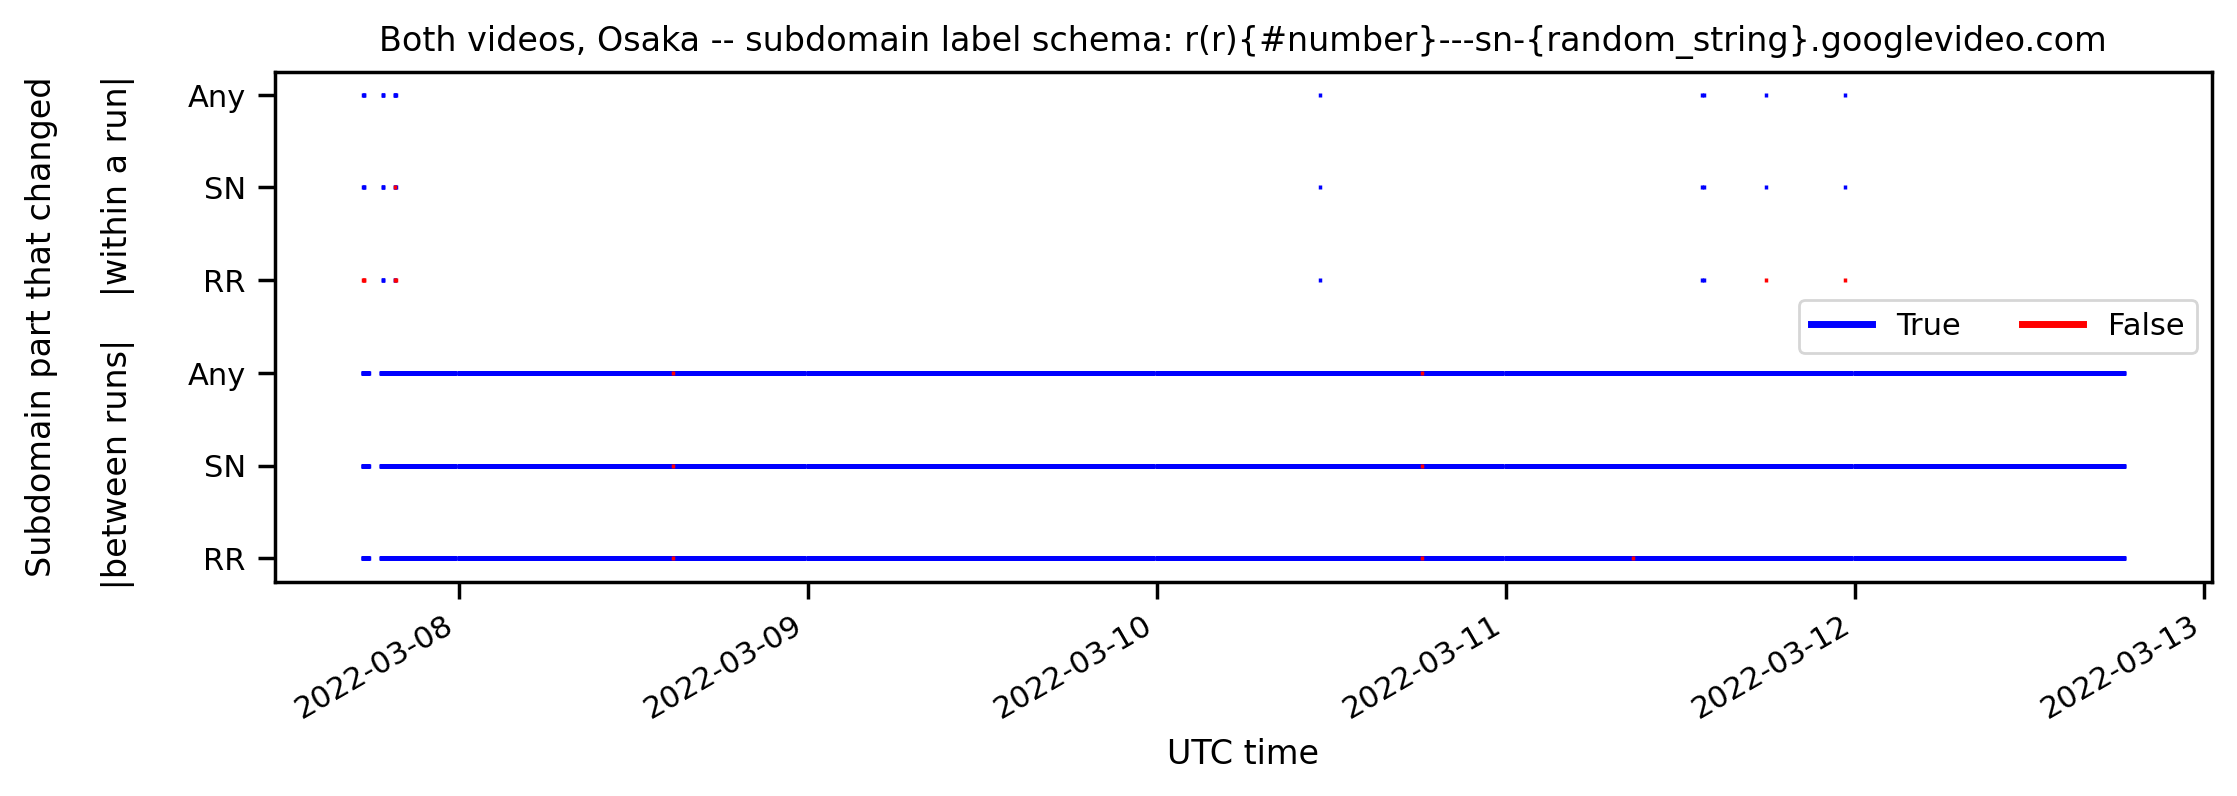

In [641]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_jp[(lookups_jp[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker="|", markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Both videos, Osaka -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

/tmp/ipykernel_17564/3126872286.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2476
True     1642
Name: subdomain_changed_btw_msm, dtype: int64


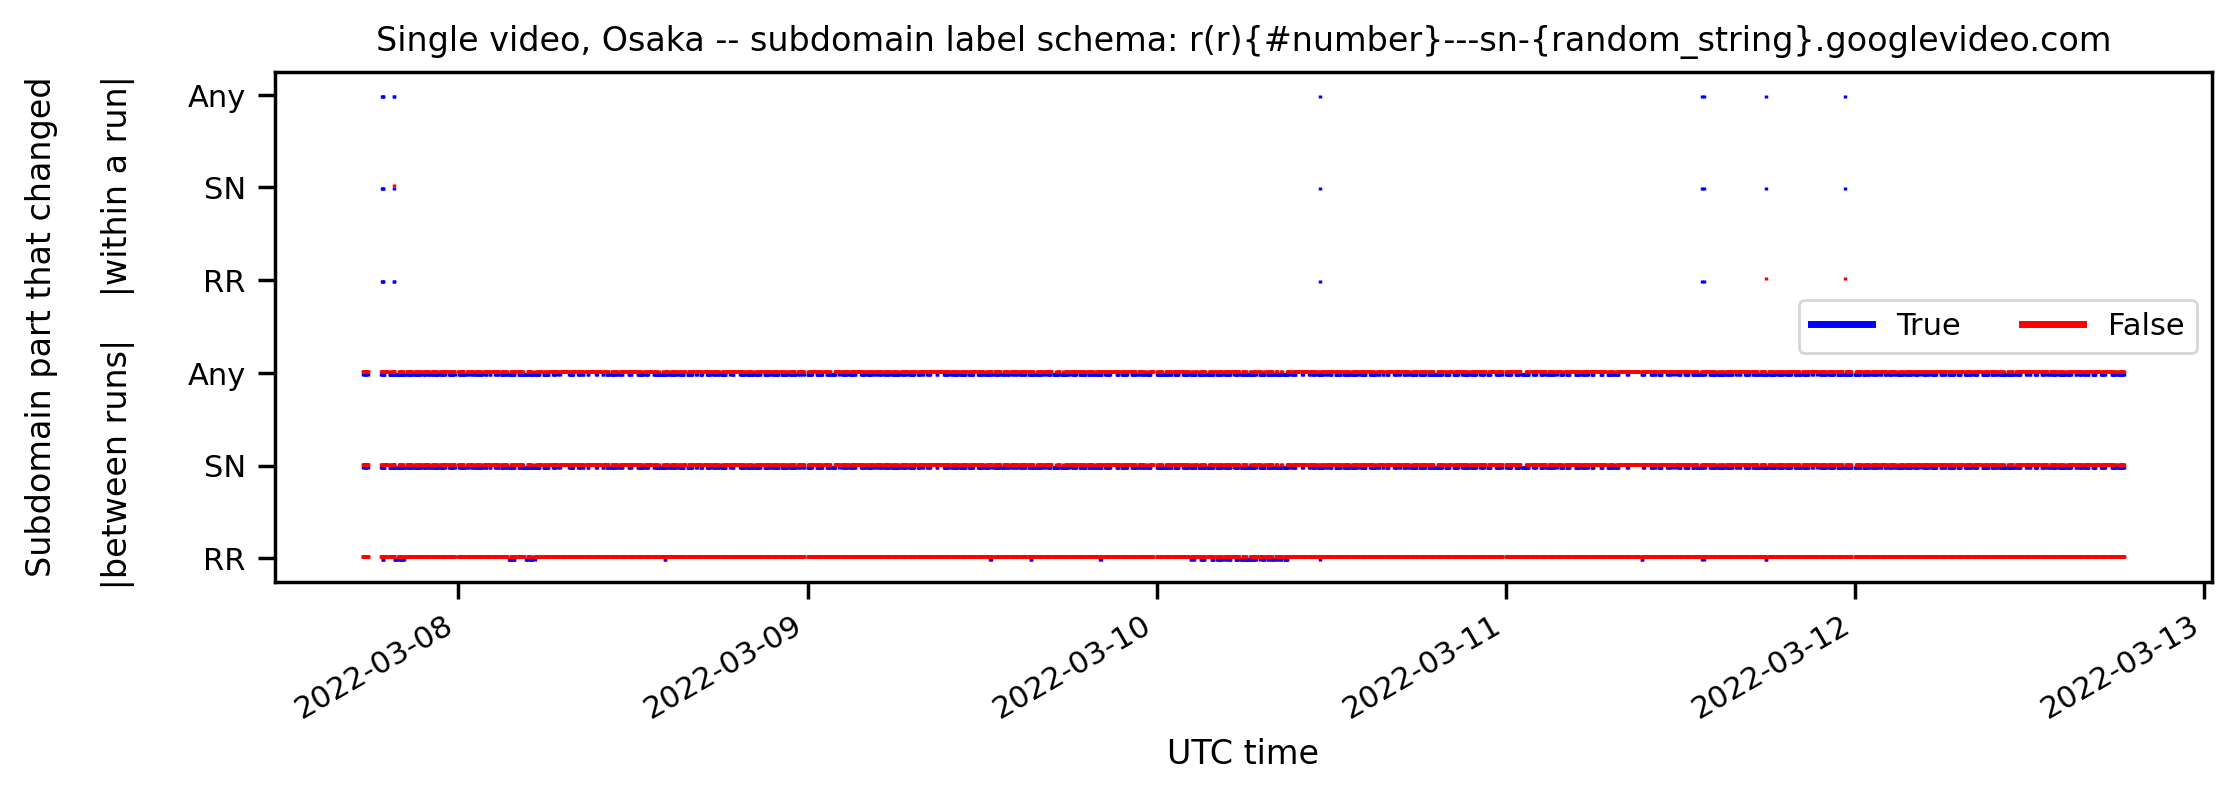

In [764]:
lookups_jp_single_video = lookups_jp[lookups_jp.video_id == 'aqz-KE-bpKQ'].copy()
lookups_jp_single_video.reset_index(drop=True, inplace=True)
lookups_jp_single_video['rr_changed_btw_msm'] = np.nan
lookups_jp_single_video['sn_changed_btw_msm'] = np.nan
lookups_jp_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_jp_single_video['rr_changed_in_msm'] = np.nan
lookups_jp_single_video['sn_changed_in_msm'] = np.nan
lookups_jp_single_video['subdomain_changed_in_msm'] = np.nan
lookups_jp_single_video = lookups_jp_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_jp_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_jp_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_jp_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_jp_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_jp_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_jp_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_jp_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_jp_single_video[(lookups_jp_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Osaka -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_jp_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

/tmp/ipykernel_17564/4047212799.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2536
True     1581
Name: subdomain_changed_btw_msm, dtype: int64


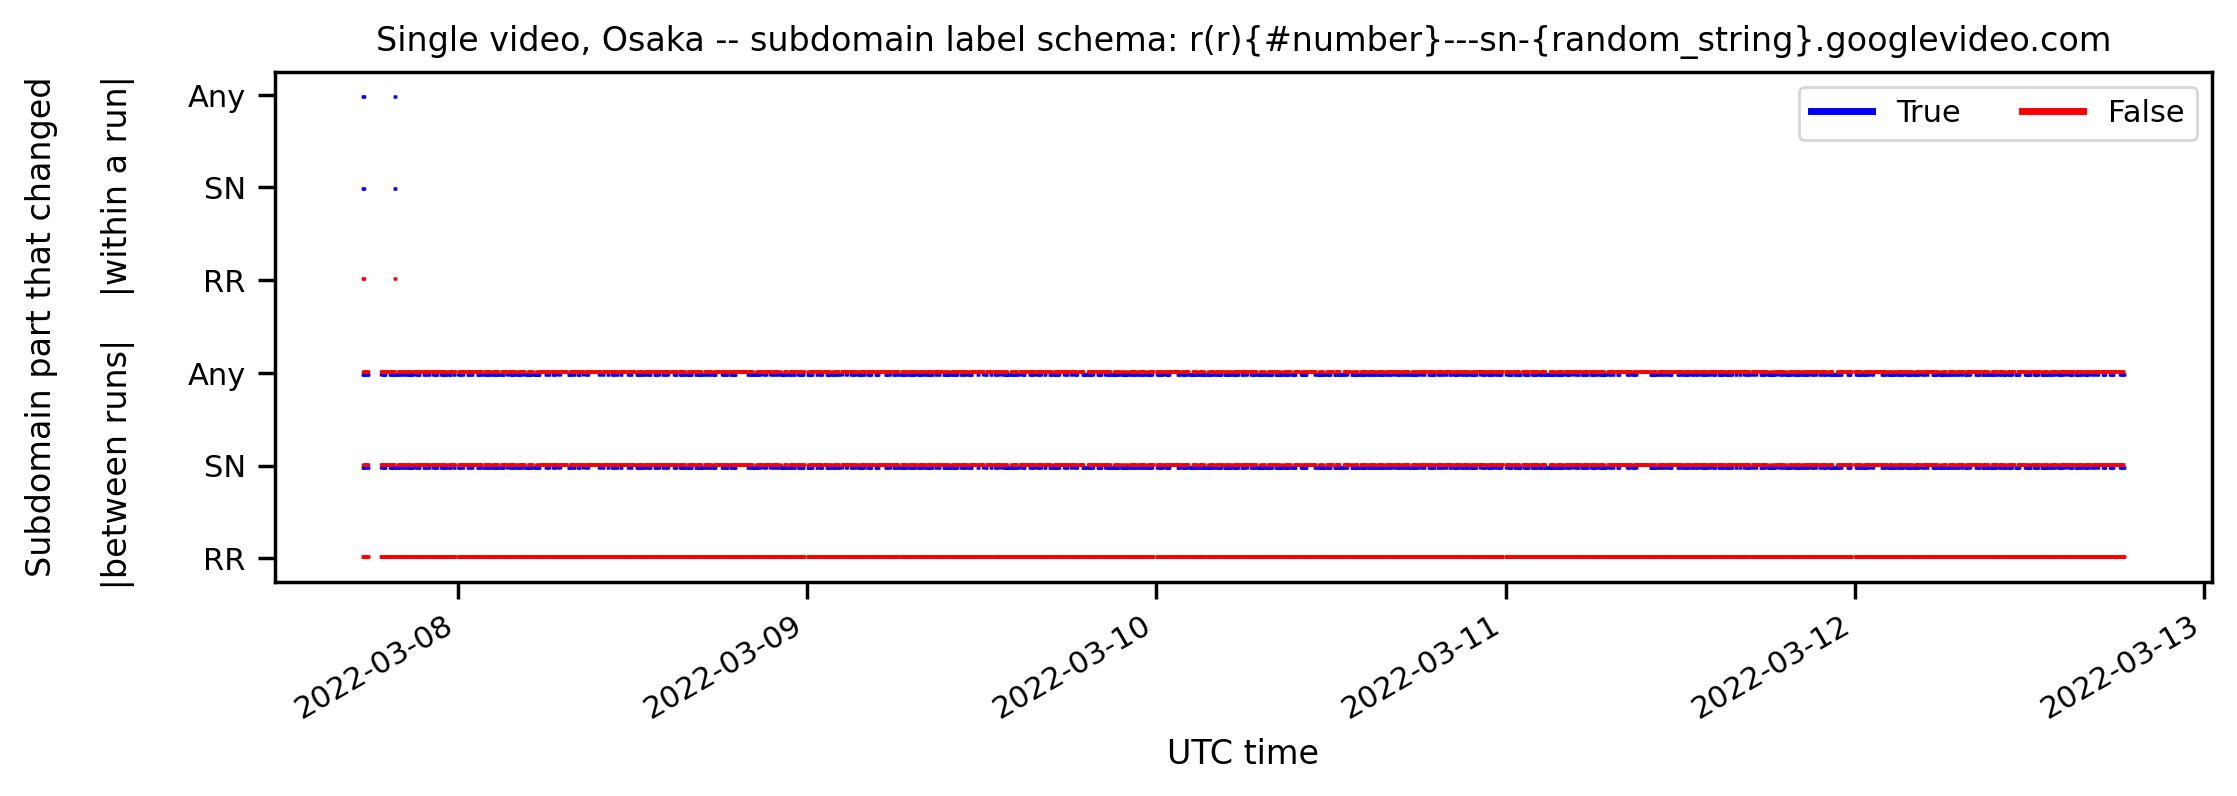

In [765]:
lookups_jp_single_video = lookups_jp[lookups_jp.video_id == 'lqiN98z6Dak'].copy()
lookups_jp_single_video.reset_index(drop=True, inplace=True)
lookups_jp_single_video['rr_changed_btw_msm'] = np.nan
lookups_jp_single_video['sn_changed_btw_msm'] = np.nan
lookups_jp_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_jp_single_video['rr_changed_in_msm'] = np.nan
lookups_jp_single_video['sn_changed_in_msm'] = np.nan
lookups_jp_single_video['subdomain_changed_in_msm'] = np.nan
lookups_jp_single_video = lookups_jp_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_jp_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_jp_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_jp_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_jp_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_jp_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_jp_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_jp_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_jp_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_jp_single_video[(lookups_jp_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Osaka -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_jp_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

### Australia

In [644]:
measurements_au = measurements[measurements.vantagePoint == 'Asia Pacific Southeast'].copy()
lookups_au = lookups[lookups.msm_id.isin(measurements_au.msm_id.unique())].copy()
googlevideo_subdomains_au = googlevideo_subdomains[googlevideo_subdomains.msm_id.isin(measurements_au.msm_id.unique())].copy()
googlevideo_requests_au = googlevideo_requests[googlevideo_requests.msm_id.isin(measurements_au.msm_id.unique())].copy()
measurements_au.reset_index(drop=True, inplace=True)
lookups_au.reset_index(drop=True, inplace=True)

In [645]:
lookups_au[lookups_au.status == 'NOERROR'].groupby('video_subdomain', as_index=False).agg(ip_addr_count=('ip_addr',pd.Series.nunique), ip_addrs=('ip_addr',pd.Series.unique)).sort_values('ip_addr_count')

,video_subdomain,ip_addr_count,ip_addrs
0,r2---sn-ntq7yned,1,173.194.28.39
1,r2---sn-ntqe6nez,1,74.125.152.39
2,r4---sn-ntq7ynle,1,74.125.109.233
3,r4---sn-ntqe6n76,1,173.194.28.9
5,rr2---sn-npoe7nsl,1,173.194.59.39
6,rr2---sn-ntq7yned,1,173.194.28.39
7,rr2---sn-ntqe6nez,1,74.125.152.39
8,rr3---sn-npoe7nsl,1,173.194.59.40
9,rr3---sn-npoeened,1,74.125.101.200
10,rr4---sn-npoe7nss,1,173.194.59.73


In [646]:
measurements_au.error.unique()

array(['',
       'failed switching selenium focus to youtube iframe or monitoring loop ### Message: \n',
       'failed loading player ### Message: \n'], dtype=object)

In [647]:
lookups_au[lookups_au.status != 'NOERROR']

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp
883,2a351d9b-71e7-e57b-6d6c-11367082ff97,rr2---sn-ntqe6nez.googlevideo.com.,10001.943156,SERVFAIL,read udp 172.31.32.114:57967->94.140.15.15:53:...,read udp 172.31.32.114:57967->94.140.15.15:53:...,rr2,sn-ntqe6nez,rr2---sn-ntqe6nez,rr2---sn-ntqe6nez-read udp 172.31.32.114:57967...,rr2---sn-ntqe6nez.googlevideo.com,2022-03-08 06:51:15.028899840,read udp 172.31.32.114:57967->94.140.15,read udp 172.31.32.114:57967->94.140,aqz-KE-bpKQ,2560x1440,2022-03-08 06:51:11.253370
1285,4b8d196d-d6d7-ccd2-af0d-37b028d793dc,rr4---sn-ntqe6n76.googlevideo.com.,10002.130893,SERVFAIL,read udp 172.31.32.114:38146->94.140.15.15:53:...,read udp 172.31.32.114:38146->94.140.15.15:53:...,rr4,sn-ntqe6n76,rr4---sn-ntqe6n76,rr4---sn-ntqe6n76-read udp 172.31.32.114:38146...,rr4---sn-ntqe6n76.googlevideo.com,2022-03-08 12:40:27.924499968,read udp 172.31.32.114:38146->94.140.15,read udp 172.31.32.114:38146->94.140,lqiN98z6Dak,1920x1080,2022-03-08 12:40:24.119728
2530,2a4f4d4d-29f5-700f-bc19-a5a526e50357,rr4---sn-ntq7ynle.googlevideo.com.,10004.395058,SERVFAIL,read udp 172.31.32.114:33468->94.140.15.15:53:...,read udp 172.31.32.114:33468->94.140.15.15:53:...,rr4,sn-ntq7ynle,rr4---sn-ntq7ynle,rr4---sn-ntq7ynle-read udp 172.31.32.114:33468...,rr4---sn-ntq7ynle.googlevideo.com,2022-03-09 06:49:02.111800064,read udp 172.31.32.114:33468->94.140.15,read udp 172.31.32.114:33468->94.140,lqiN98z6Dak,1280x720,2022-03-09 06:48:58.178237
2936,6ba9d8ef-e2d5-2a24-a350-57b5fbb454a7,rr4---sn-ntqe6n76.googlevideo.com.,10000.685011,SERVFAIL,read udp 172.31.32.114:44103->94.140.15.15:53:...,read udp 172.31.32.114:44103->94.140.15.15:53:...,rr4,sn-ntqe6n76,rr4---sn-ntqe6n76,rr4---sn-ntqe6n76-read udp 172.31.32.114:44103...,rr4---sn-ntqe6n76.googlevideo.com,2022-03-09 12:42:04.462200320,read udp 172.31.32.114:44103->94.140.15,read udp 172.31.32.114:44103->94.140,lqiN98z6Dak,2560x1440,2022-03-09 12:42:00.106580
3179,0fdddd03-7d48-d51a-d3bd-b2d4aad88fa3,rr2---sn-ntqe6nez.googlevideo.com.,10003.922966,SERVFAIL,read udp 172.31.32.114:43613->94.140.15.15:53:...,read udp 172.31.32.114:43613->94.140.15.15:53:...,rr2,sn-ntqe6nez,rr2---sn-ntqe6nez,rr2---sn-ntqe6nez-read udp 172.31.32.114:43613...,rr2---sn-ntqe6nez.googlevideo.com,2022-03-09 16:11:11.546700032,read udp 172.31.32.114:43613->94.140.15,read udp 172.31.32.114:43613->94.140,aqz-KE-bpKQ,2560x1440,2022-03-09 16:11:07.446033
4462,be154033-e67a-e62d-7a2f-3529c428724f,rr4---sn-ntqe6n76.googlevideo.com.,10002.480761,SERVFAIL,read udp 172.31.32.114:53034->94.140.15.15:53:...,read udp 172.31.32.114:53034->94.140.15.15:53:...,rr4,sn-ntqe6n76,rr4---sn-ntqe6n76,rr4---sn-ntqe6n76-read udp 172.31.32.114:53034...,rr4---sn-ntqe6n76.googlevideo.com,2022-03-10 10:53:56.040000000,read udp 172.31.32.114:53034->94.140.15,read udp 172.31.32.114:53034->94.140,lqiN98z6Dak,1280x720,2022-03-10 10:53:52.026835
4547,d12e2547-0d10-d765-c4de-ea50c6a98703,rr2---sn-ntqe6nez.googlevideo.com.,10002.483594,SERVFAIL,read udp 172.31.32.114:55190->94.140.15.15:53:...,read udp 172.31.32.114:55190->94.140.15.15:53:...,rr2,sn-ntqe6nez,rr2---sn-ntqe6nez,rr2---sn-ntqe6nez-read udp 172.31.32.114:55190...,rr2---sn-ntqe6nez.googlevideo.com,2022-03-10 12:06:13.832099840,read udp 172.31.32.114:55190->94.140.15,read udp 172.31.32.114:55190->94.140,aqz-KE-bpKQ,2560x1440,2022-03-10 12:06:10.086177
4876,a7662419-1d7f-a7cc-9b68-58167810ef54,rr2---sn-ntq7yned.googlevideo.com.,10003.289771,SERVFAIL,read udp 172.31.32.114:34535->94.140.15.15:53:...,read udp 172.31.32.114:34535->94.140.15.15:53:...,rr2,sn-ntq7yned,rr2---sn-ntq7yned,rr2---sn-ntq7yned-read udp 172.31.32.114:34535...,rr2---sn-ntq7yned.googlevideo.com,2022-03-10 16:47:31.875400192,read udp 172.31.32.114:34535->94.140.15,read udp 172.31.32.114:34535->94.140,aqz-KE-bpKQ,3840x2160,2022-03-10 16:47:28.027723
6437,09f35412-60bc-4578-d7

In [648]:
lookups_au = lookups_au[lookups_au.status == 'NOERROR']

In [649]:
lookups_au[lookups_au.video_subdomain == 'redirector'].video_id.value_counts()

aqz-KE-bpKQ    9
lqiN98z6Dak    6
Name: video_id, dtype: int64

In [650]:
lookups_au[lookups_au.video_subdomain != 'redirector'].groupby('rand_sn_str').agg(rr_count=('round_robin_str', pd.Series.nunique)).sort_values('rr_count')

,rr_count
rand_sn_str,
sn-npoe7nss,1
sn-npoeened,1
sn-npoldn7s,1
sn-npoe7nsl,2
sn-ntq7yned,2
sn-ntq7ynle,2
sn-ntqe6n76,2
sn-ntqe6nez,2


In [651]:
lookups_au[lookups_au.video_subdomain != 'redirector'].groupby('rand_sn_str').filter(lambda x: pd.Series.nunique(x['round_robin_str']) > 1).groupby('rand_sn_str', as_index=False).agg(rr_strs=('round_robin_str', pd.Series.unique))

,rand_sn_str,rr_strs
0,sn-npoe7nsl,"[rr2, rr3]"
1,sn-ntq7yned,"[rr2, r2]"
2,sn-ntq7ynle,"[rr4, r4]"
3,sn-ntqe6n76,"[rr4, r4]"
4,sn-ntqe6nez,"[rr2, r2]"


In [652]:
lookups_au = lookups_au[lookups_au.video_subdomain != 'redirector']
lookups_au.reset_index(drop=True, inplace=True)
lookups_au['rr_changed_btw_msm'] = np.nan
lookups_au['sn_changed_btw_msm'] = np.nan
lookups_au['subdomain_changed_btw_msm'] = np.nan
lookups_au['rr_changed_in_msm'] = np.nan
lookups_au['sn_changed_in_msm'] = np.nan
lookups_au['subdomain_changed_in_msm'] = np.nan
lookups_au = lookups_au.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_au.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_au.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_au.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_au.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_au.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_au.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_au.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_au.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_au.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_au.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_au.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_au.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_au.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row

print(lookups_au['ip_addr/24'].nunique())
print(lookups_au['rand_sn_str'].nunique())

/tmp/ipykernel_17564/3769661092.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


6
8


In [653]:
lookups_au.groupby('rand_sn_str', as_index=False).agg(count24=('ip_addr/24', pd.Series.nunique), count16=('ip_addr/16', pd.Series.nunique)).sort_values('count16')

,rand_sn_str,count24,count16
0,sn-npoe7nsl,1,1
1,sn-npoe7nss,1,1
2,sn-npoeened,1,1
3,sn-npoldn7s,1,1
4,sn-ntq7yned,1,1
5,sn-ntq7ynle,1,1
6,sn-ntqe6n76,1,1
7,sn-ntqe6nez,1,1


In [654]:
lookups_au.groupby('ip_addr/24', as_index=False).agg(count_sn=('rand_sn_str', pd.Series.unique))

,ip_addr/24,count_sn
0,142.251.85,sn-npoldn7s
1,173.194.28,"[sn-ntq7yned, sn-ntqe6n76]"
2,173.194.59,"[sn-npoe7nss, sn-npoe7nsl]"
3,74.125.101,sn-npoeened
4,74.125.109,sn-ntq7ynle
5,74.125.152,sn-ntqe6nez


In [655]:
lookups_au['sn_length'] = lookups_au['rand_sn_str'].str.len()
print(lookups_au.sn_length.value_counts())

11    8262
Name: sn_length, dtype: int64


In [656]:
lookups_au.groupby('ip_addr/24', as_index=False).agg(count_sn_overlap=('rand_sn_str', lambda x: count_largest_sn_overlap(pd.Series.unique(x).tolist())), sn_overlap=('rand_sn_str', lambda x: largest_sn_overlap(pd.Series.unique(x).tolist())))

,ip_addr/24,count_sn_overlap,sn_overlap
0,142.251.85,11,sn-npoldn7s
1,173.194.28,6,sn-ntq
2,173.194.59,10,sn-npoe7ns
3,74.125.101,11,sn-npoeened
4,74.125.109,11,sn-ntq7ynle
5,74.125.152,11,sn-ntqe6nez


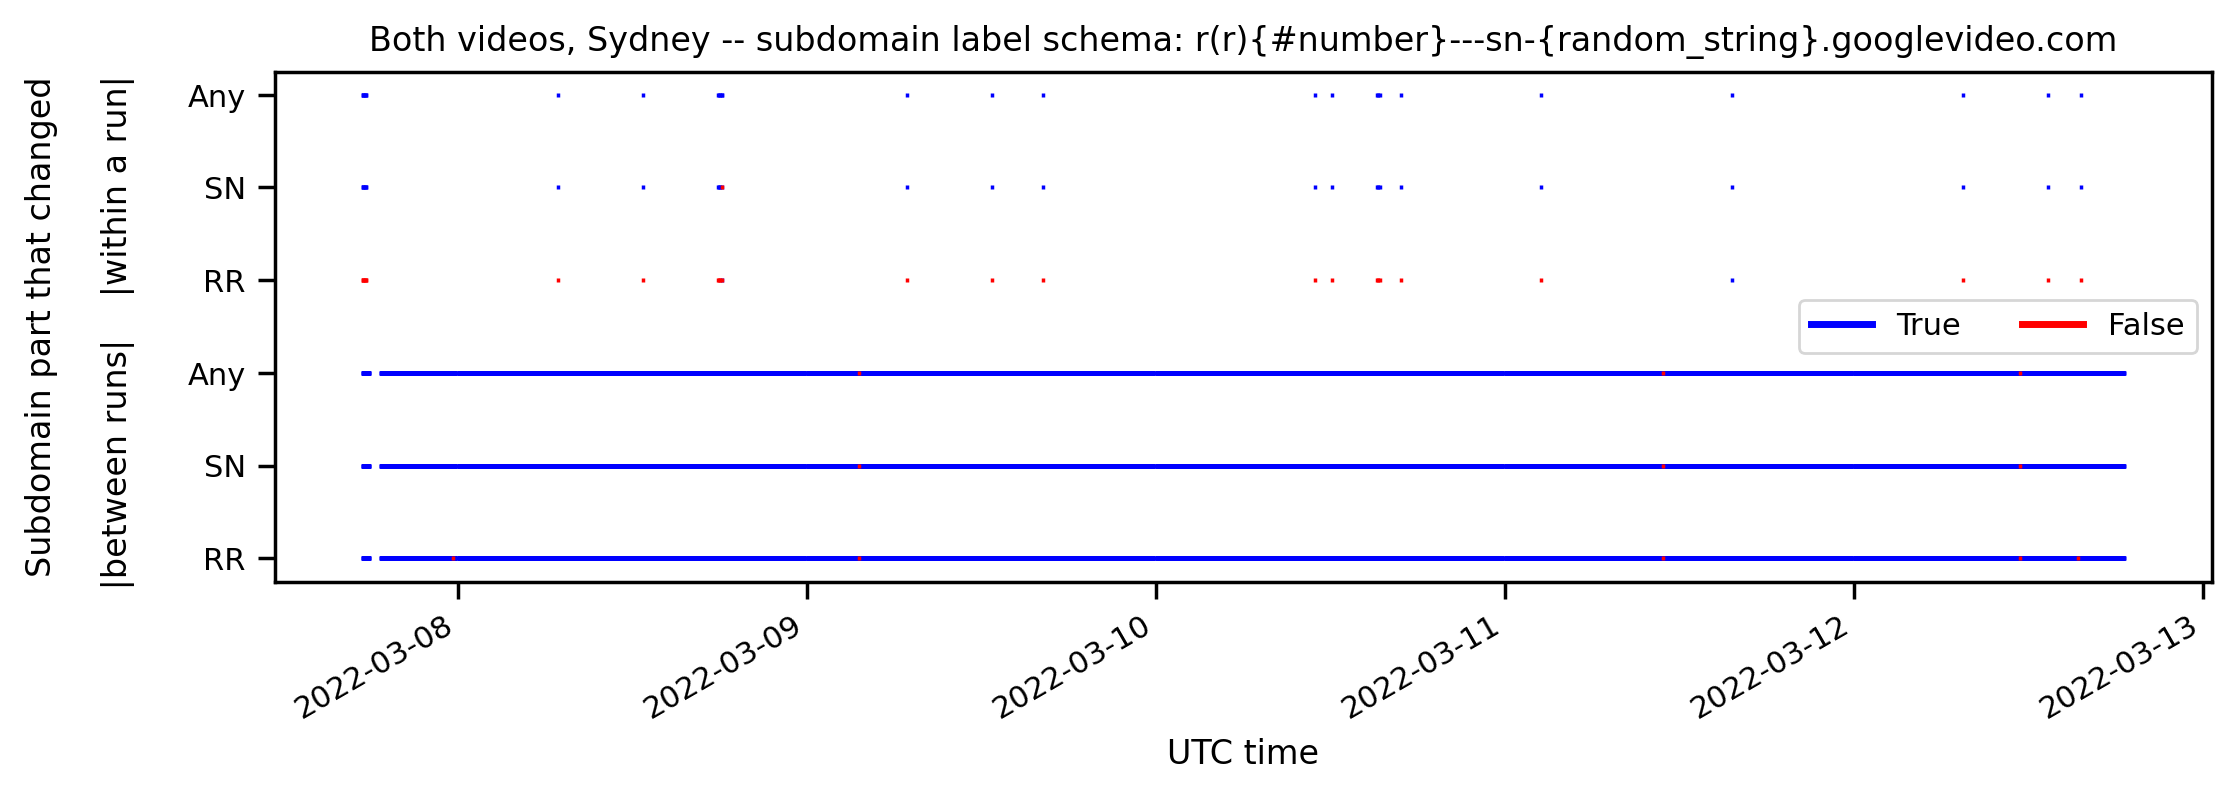

In [657]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_au[(lookups_au[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = idx+1.
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker="|", markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Both videos, Sydney -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([1.,2.,3.,4.,5.,6.])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))

/tmp/ipykernel_17564/549990609.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2124
True     1993
Name: subdomain_changed_btw_msm, dtype: int64


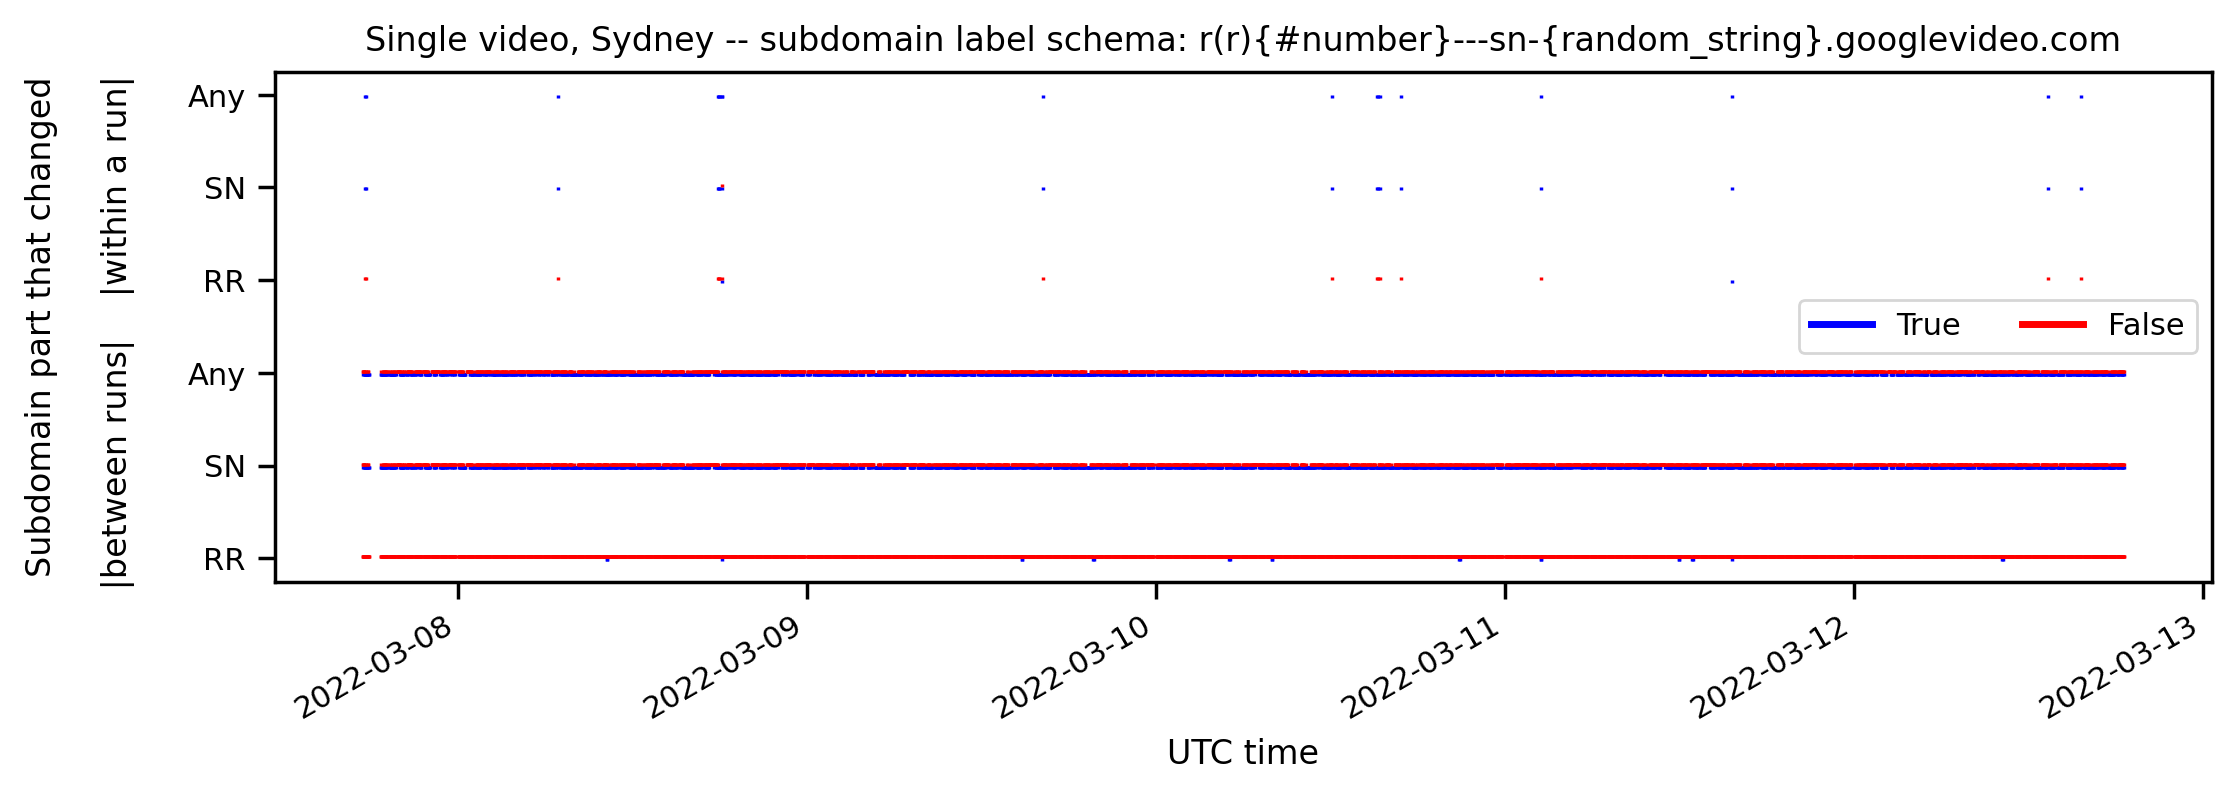

In [766]:
lookups_au_single_video = lookups_au[lookups_au.video_id == 'aqz-KE-bpKQ'].copy()
lookups_au_single_video.reset_index(drop=True, inplace=True)
lookups_au_single_video['rr_changed_btw_msm'] = np.nan
lookups_au_single_video['sn_changed_btw_msm'] = np.nan
lookups_au_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_au_single_video['rr_changed_in_msm'] = np.nan
lookups_au_single_video['sn_changed_in_msm'] = np.nan
lookups_au_single_video['subdomain_changed_in_msm'] = np.nan
lookups_au_single_video = lookups_au_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_au_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_au_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_au_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_au_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_au_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_au_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_au_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_au_single_video[(lookups_au_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Sydney -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_au_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

/tmp/ipykernel_17564/229522847.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  last_row = pd.Series()


False    2195
True     1921
Name: subdomain_changed_btw_msm, dtype: int64


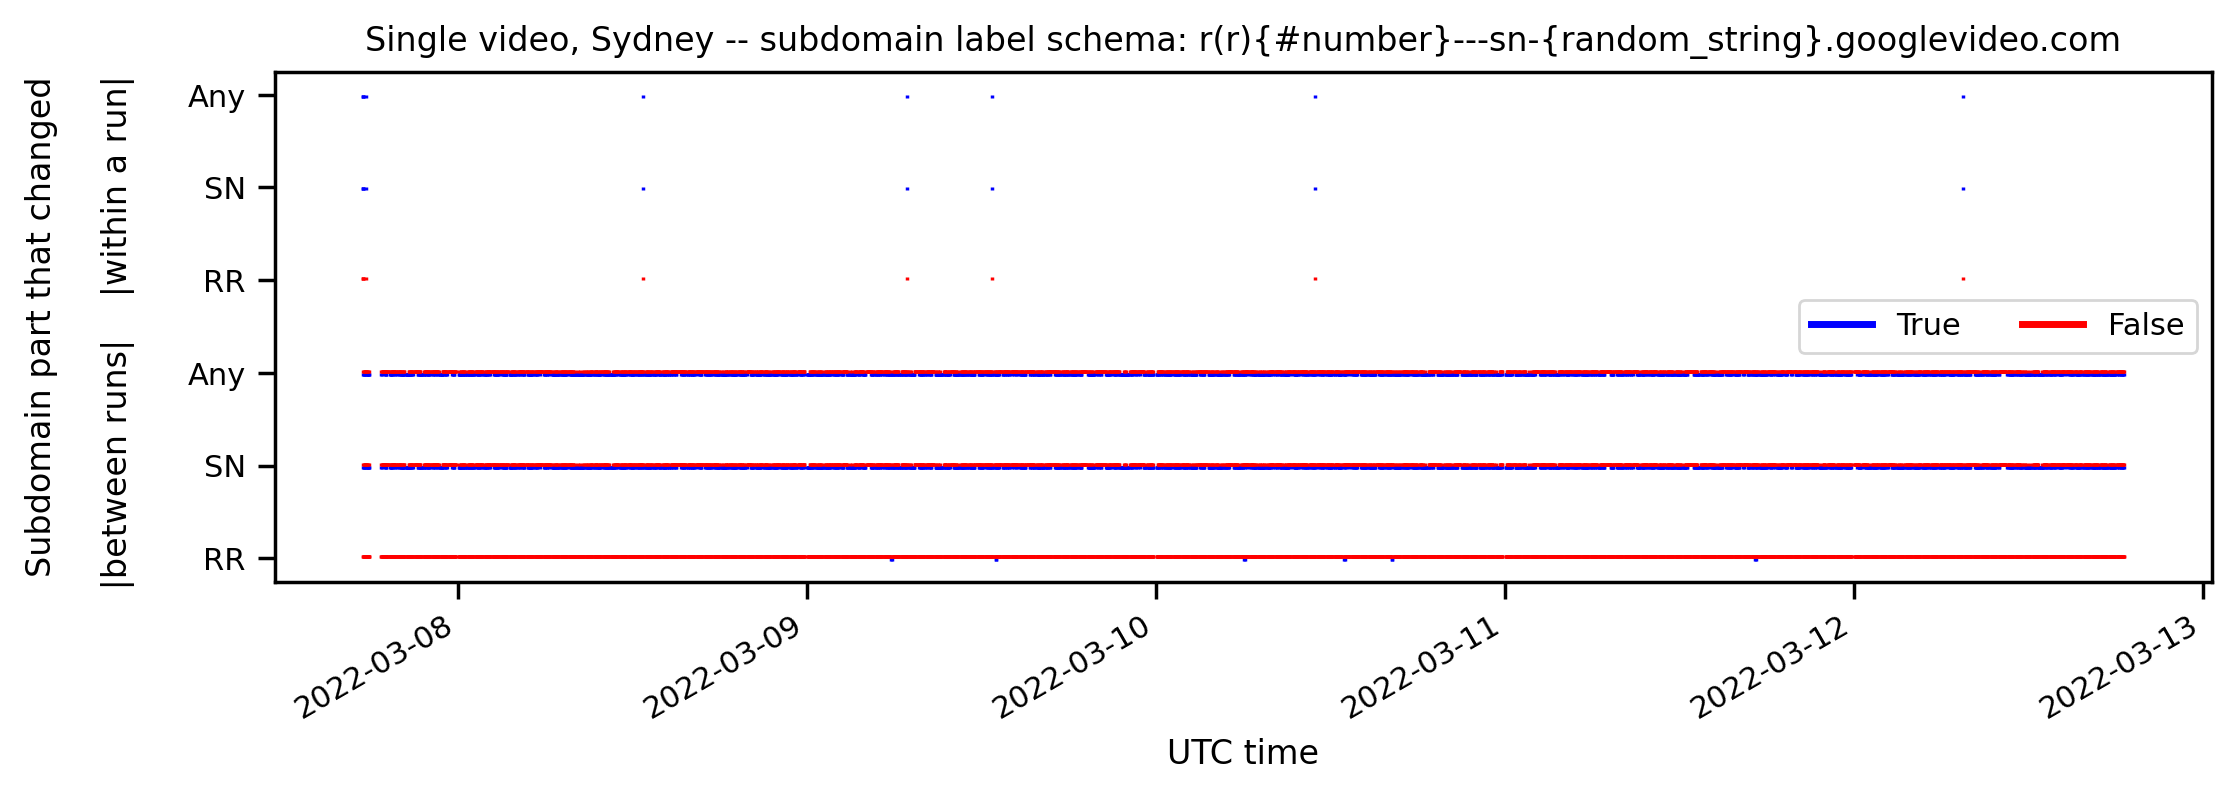

In [767]:
lookups_au_single_video = lookups_au[lookups_au.video_id == 'lqiN98z6Dak'].copy()
lookups_au_single_video.reset_index(drop=True, inplace=True)
lookups_au_single_video['rr_changed_btw_msm'] = np.nan
lookups_au_single_video['sn_changed_btw_msm'] = np.nan
lookups_au_single_video['subdomain_changed_btw_msm'] = np.nan
lookups_au_single_video['rr_changed_in_msm'] = np.nan
lookups_au_single_video['sn_changed_in_msm'] = np.nan
lookups_au_single_video['subdomain_changed_in_msm'] = np.nan
lookups_au_single_video = lookups_au_single_video.sort_values('first_time_seen')
last_row = pd.Series()
for index, row in lookups_au_single_video.iterrows():
    if index == 0:
        last_row = row
        continue
    else:
        if row['msm_id'] == last_row['msm_id']:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_au_single_video.loc[index, 'rr_changed_in_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'rr_changed_in_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_au_single_video.loc[index, 'sn_changed_in_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'sn_changed_in_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_au_single_video.loc[index, 'subdomain_changed_in_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'subdomain_changed_in_msm'] = True
        else:
            if row['round_robin_str'] == last_row['round_robin_str']:
                lookups_au_single_video.loc[index, 'rr_changed_btw_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'rr_changed_btw_msm'] = True
            if row['rand_sn_str'] == last_row['rand_sn_str']:
                lookups_au_single_video.loc[index, 'sn_changed_btw_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'sn_changed_btw_msm'] = True
            if row['video_subdomain'] == last_row['video_subdomain']:
                lookups_au_single_video.loc[index, 'subdomain_changed_btw_msm'] = False
            else:
                lookups_au_single_video.loc[index, 'subdomain_changed_btw_msm'] = True
        last_row = row
        
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
labels = ['rr_changed_btw_msm', 'sn_changed_btw_msm', 'subdomain_changed_btw_msm', 
          'rr_changed_in_msm', 'sn_changed_in_msm', 'subdomain_changed_in_msm']
label_map={'rr_changed_btw_msm': 'RR string changed between runs', 
           'sn_changed_btw_msm':'SN string changed between runs', 
           'subdomain_changed_btw_msm':'Whole subdomain changed between runs', 
          'rr_changed_in_msm':'RR string changed within run', 
           'sn_changed_in_msm':'SN string changed within run', 
           'subdomain_changed_in_msm':'Whole subdomain changed within run'}
cmap = {True:'blue', False:'red'}
for idx in range(len(labels)):
    label=labels[idx]
    for is_true in [True, False]:
        df_tmp = lookups_au_single_video[(lookups_au_single_video[label] == is_true)][['first_time_seen']].set_index('first_time_seen')
        df_tmp[label_map[label]+' '+str(is_true)] = (idx+1)/10
        df_tmp.plot(y=label_map[label]+' '+str(is_true), ax=ax, marker=is_true+2, markersize=1, drawstyle="default", lw=0, color=cmap[is_true])
#df_tmp.plot(ax=ax, marker=2, markersize=3, drawstyle="default", lw=0, color='C2')
ax.legend_.remove()
ax.set_title("Single video, Sydney -- subdomain label schema: r(r){#number}---sn-{random_string}.googlevideo.com")
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
ax.set_ylabel('Subdomain part that changed\n\n |      between runs      |                  |        within a run       |\n')
ax.set_ylabel('Subdomain part that changed\n\n |between runs|    |within a run|  \n')
ax.set_xlabel("UTC time")
legend_elements = [mpl.lines.Line2D([0], [0], color=cmap[legend_item], lw=2, label=legend_item, marker='') for legend_item in cmap.keys()]
plt.gca().legend(handles=legend_elements, loc='best', ncol=2)#, bbox_to_anchor=(.5, -.4))
print(lookups_au_single_video.subdomain_changed_btw_msm.value_counts())
plt.show()

In [661]:
lookups = pd.merge(lookups, measurements[measurements.error == ''][['msm_id', 'vantagePoint']], on='msm_id')

In [662]:
lookups

,msm_id,domain,elapsed,status,answer,ip_addr,round_robin_str,rand_sn_str,video_subdomain,subdomain_and_ip,googlevideo,first_time_seen,ip_addr/24,ip_addr/16,video_id,player_dimensions,timestamp,vantagePoint
0,544b9c53-fb16-e2fe-5fb0-0268b693a586,rr2---sn-5hnekn7z.googlevideo.com.,152.211291,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,699,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:22:49.099600128,74.125.100,74.125,aqz-KE-bpKQ,1280x720,2022-03-07 17:22:43.846963,Africa South
1,7a1a699c-6c32-6b28-f8f1-cac46c3d96c8,rr4---sn-5hnekn7k.googlevideo.com.,149.194440,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,627,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73,rr4---sn-5hnekn7k.googlevideo.com,2022-03-07 17:23:32.022299904,209.85.226,209.85,lqiN98z6Dak,1280x720,2022-03-07 17:23:26.657266,Africa South
2,e2576b0d-50a9-f803-e475-4d880109c675,rr2---sn-5hnekn7z.googlevideo.com.,142.190267,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,610,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:24:18.062300160,74.125.100,74.125,aqz-KE-bpKQ,1920x1080,2022-03-07 17:24:12.805090,Africa South
3,22cb024f-8247-54be-730f-b2b57f8a4074,rr4---sn-5hnekn7k.googlevideo.com.,171.337583,NOERROR,"rr4---sn-5hnekn7k.googlevideo.com.,538,IN,CNAM...",209.85.226.73,rr4,sn-5hnekn7k,rr4---sn-5hnekn7k,rr4---sn-5hnekn7k-209.85.226.73,rr4---sn-5hnekn7k.googlevideo.com,2022-03-07 17:25:02.213599744,209.85.226,209.85,lqiN98z6Dak,1920x1080,2022-03-07 17:24:55.775264,Africa South
4,150bdff4-3e93-9c75-8236-5c550ea665e1,rr2---sn-5hnekn7z.googlevideo.com.,150.356304,NOERROR,"rr2---sn-5hnekn7z.googlevideo.com.,521,IN,CNAM...",74.125.100.103,rr2,sn-5hnekn7z,rr2---sn-5hnekn7z,rr2---sn-5hnekn7z-74.125.100.103,rr2---sn-5hnekn7z.googlevideo.com,2022-03-07 17:25:47.131300096,74.125.100,74.125,aqz-KE-bpKQ,2560x1440,2022-03-07 17:25:41.910113,Africa South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60954,3c7e0c54-cae9-53bd-6256-b9189b271137,rr4---sn-n4v7snl7.googlevideo.com.,9.886096,NOERROR,"rr4---sn-n4v7snl7.googlevideo.com.,860,IN,CNAM...",74.125.103.137,rr4,sn-n4v7snl7,rr4---sn-n4v7snl7,rr4---sn-n4v7snl7-74.125.103.137,rr4---sn-n4v7snl7.googlevideo.com,2022-03-12 18:28:17.776300032,74.125.103,74.125,lqiN98z6Dak,1920x1080,2022-03-12 18:28:10.312525,US West
60955,2cf02006-5094-efc4-77ec-750435ef9ad0,rr2---sn-o097znsr.googlevideo.com.,12.252375,NOERROR,"rr2---sn-o097znsr.googlevideo.com.,1041,IN,CNA...",173.194.8.7,rr2,sn-o097znsr,rr2---sn-o097znsr,rr2---sn-o097znsr-173.194.8.7,rr2---sn-o097znsr.googlevideo.com,2022-03-12 18:28:53.731100160,173.194.8,173.194,aqz-KE-bpKQ,2560x1440,2022-03-12 18:28:51.125717,US West
60956,892bb7e6-6971-f8e2-dbad-f9193758c29c,rr4---sn-o097znse.googlevideo.com.,8.844368,NOERROR,"rr4---sn-o097znse.googlevideo.com.,666,IN,CNAM...",74.125.166.41,rr4,sn-o097znse,rr4---sn-o097znse,rr4---sn-o097znse-74.125.166.41,rr4---sn-o097znse.googlevideo.com,2022-03-12 18:29:31.903500032,74.125.166,74.125,lqiN98z6Dak,2560x1440,2022-03-12 18:29:29.181181,US West
60957,651c800b-d38c-86f8-5228-bdbb1bf68384,rr2---sn-n4v7sney.googlevideo.com.,8.729008,NOERROR,"rr2---sn-n4v7sney.googlevideo.com.,179,IN,CNAM...",74.125.103.39,rr2,sn-n4v7sney,rr2---sn-n4v7sney,rr2---sn-n4v7sney-74.125.103.39,rr2---sn-n4v7sney.googlevideo.com,2022-03-12 18:30:13.217699840,74.125.103,74.125,aqz-KE-bpKQ,3840x2160,2022-03-12 18:30:10.764789,US West


In [739]:
video_subdomain_vp_map = lookups.groupby('domain', as_index=False).agg(vp_count=('vantagePoint', pd.Series.nunique), vps=('vantagePoint', pd.Series.unique)).sort_values('vp_count')

In [668]:
video_subdomain_vp_map.vp_count.value_counts()

1    77
2    16
7     1
Name: vp_count, dtype: int64

In [678]:
lookups[(lookups.status == 'NOERROR')&(lookups.domain.isin(video_subdomain_vp_map[video_subdomain_vp_map.vp_count == 1].domain.unique()))].groupby('domain', as_index=False).agg(ip_count=('ip_addr',pd.Series.nunique)).sort_values('ip_count')

,domain,ip_count
0,r1---sn-1gi7znek.googlevideo.com.,1
54,rr4---sn-a5mekn6d.googlevideo.com.,1
53,rr4---sn-5hnedn7e.googlevideo.com.,1
52,rr4---sn-4g5ednly.googlevideo.com.,1
51,rr4---sn-4g5ednde.googlevideo.com.,1
...,...,...
21,r4---sn-p5qs7n7d.googlevideo.com.,1
32,rr2---sn-a5mekn6d.googlevideo.com.,2
40,rr2---sn-o097znsr.googlevideo.com.,2
65,rr4---sn-o097znse.googlevideo.com.,2


In [690]:
print(lookups[lookups.domain == 'rr2---sn-a5mekn6d.googlevideo.com.'].ip_addr.unique())
print(lookups[lookups.domain == 'rr2---sn-o097znsr.googlevideo.com.'].ip_addr.unique())
print(lookups[lookups.domain == 'rr4---sn-o097znse.googlevideo.com.'].ip_addr.unique())
print(lookups[lookups.domain == 'rr2---sn-n4v7sney.googlevideo.com.'].ip_addr.unique())


['173.194.8.199' '142.250.68.65']
['173.194.8.7' '173.194.8.199']
['74.125.166.41' '173.194.8.105']
['74.125.103.39' '173.194.8.7']


In [692]:
print(lookups[lookups.domain == 'rr2---sn-a5mekn6d.googlevideo.com.'].timestamp.unique())
print('--')
print(lookups[lookups.domain == 'rr2---sn-o097znsr.googlevideo.com.'].timestamp.unique())
print('--')
print(lookups[lookups.domain == 'rr4---sn-o097znse.googlevideo.com.'].timestamp.unique())
print('--')
print(lookups[lookups.domain == 'rr2---sn-n4v7sney.googlevideo.com.'].timestamp.unique())
print('--')

['2022-03-08T02:20:07.816970000' '2022-03-08T04:09:06.260629000'
 '2022-03-08T04:45:26.633692000' '2022-03-08T10:34:07.387131000'
 '2022-03-08T12:28:26.134450000' '2022-03-08T12:40:26.879620000'
 '2022-03-09T03:38:05.062937000' '2022-03-09T11:06:26.556120000'
 '2022-03-09T11:07:45.351217000' '2022-03-09T11:09:04.867605000'
 '2022-03-09T11:10:24.159472000' '2022-03-09T11:11:43.612974000'
 '2022-03-09T11:13:02.447124000' '2022-03-10T06:08:37.263685000'
 '2022-03-10T09:59:04.616025000' '2022-03-11T16:04:05.905554000'
 '2022-03-12T00:18:39.503791000' '2022-03-12T16:10:50.543870000']
--
['2022-03-07T17:10:41.534764000' '2022-03-07T17:12:00.956360000'
 '2022-03-07T17:13:20.708278000' ... '2022-03-12T18:24:54.700550000'
 '2022-03-12T18:27:32.364633000' '2022-03-12T18:28:51.125717000']
--
['2022-03-07T17:11:19.848882000' '2022-03-07T17:12:39.582123000'
 '2022-03-07T17:15:18.794988000' ... '2022-03-12T18:24:13.691802000'
 '2022-03-12T18:26:51.445962000' '2022-03-12T18:29:29.181181000']
--
['202

rr2---sn-a5mekn6d.googlevideo.com.->173.194.8.199: 19
rr2---sn-a5mekn6d.googlevideo.com.->142.250.68.65: 1
rr2---sn-o097znsr.googlevideo.com.->173.194.8.7: 2782
rr2---sn-o097znsr.googlevideo.com.->173.194.8.199: 1
rr4---sn-o097znse.googlevideo.com.->74.125.166.41: 2770
rr4---sn-o097znse.googlevideo.com.->173.194.8.105: 1
rr2---sn-n4v7sney.googlevideo.com.->74.125.103.39: 1330
rr2---sn-n4v7sney.googlevideo.com.->173.194.8.7: 2


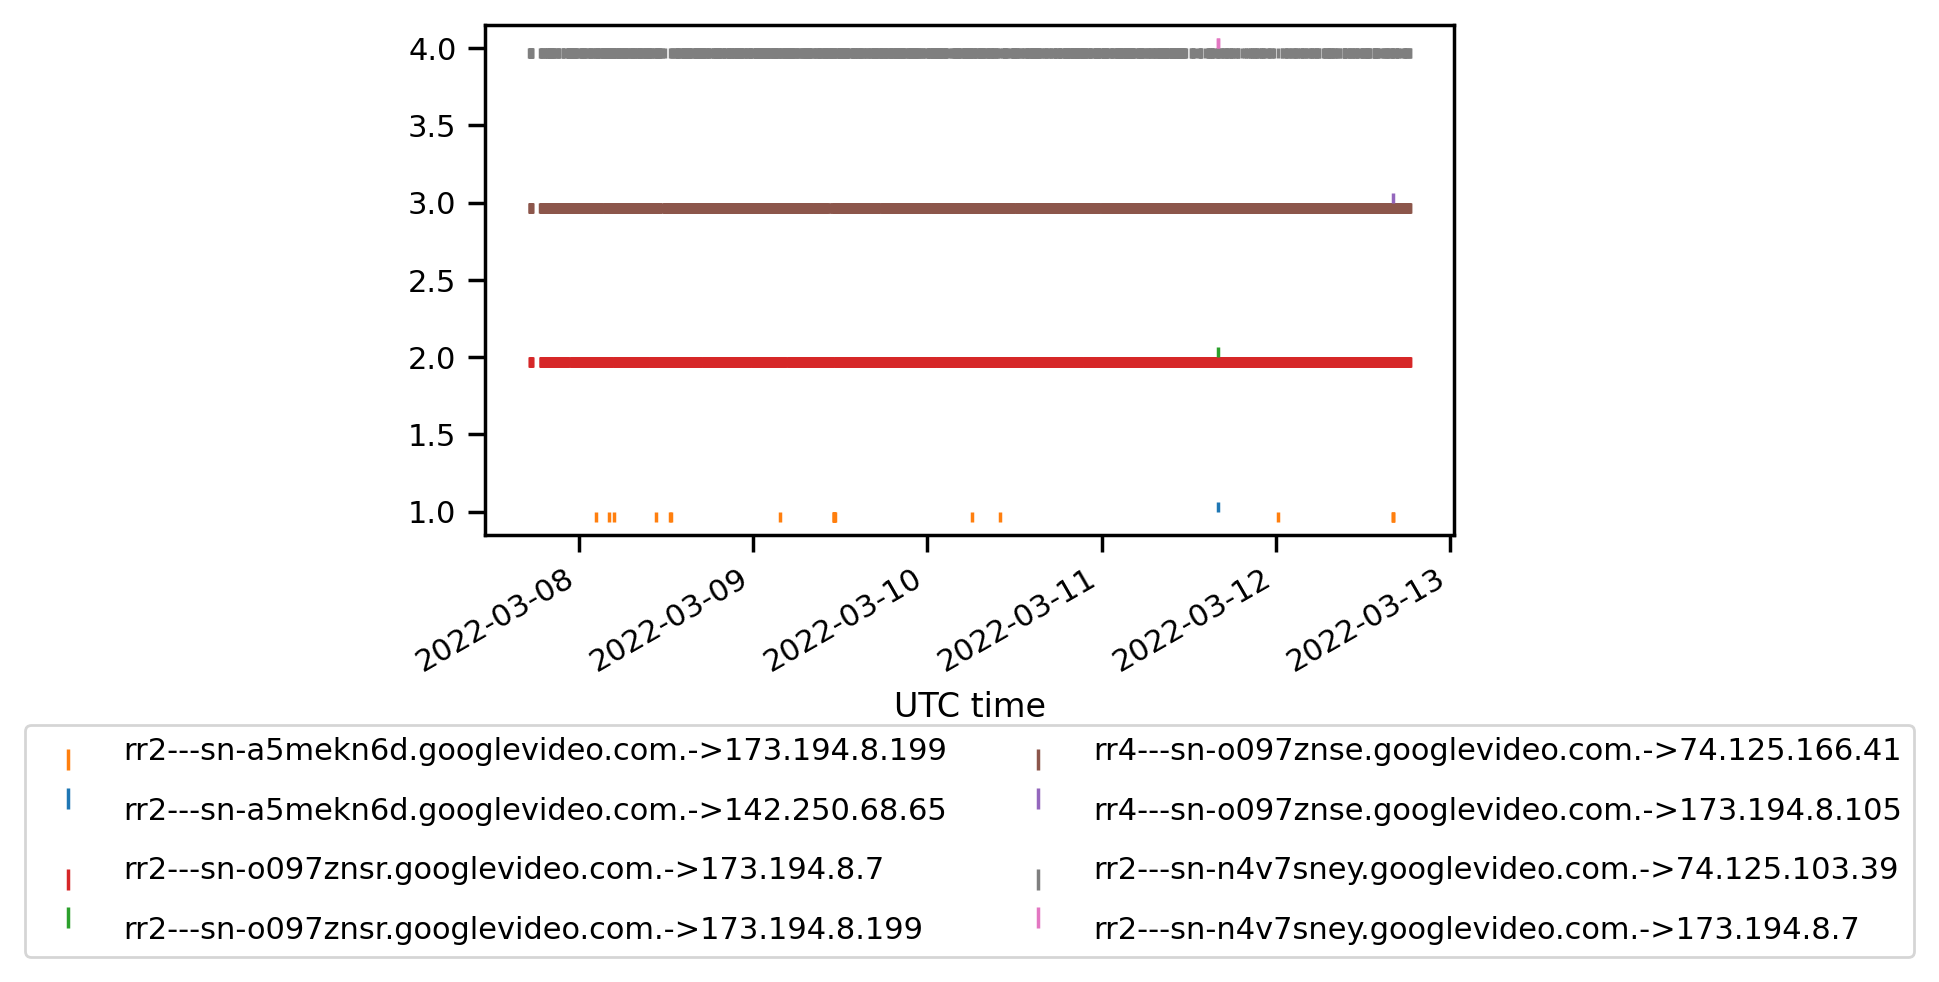

In [732]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
us_west_subdomain_with_two_ip = ['rr2---sn-a5mekn6d.googlevideo.com.', 'rr2---sn-o097znsr.googlevideo.com.', 
                                'rr4---sn-o097znse.googlevideo.com.', 'rr2---sn-n4v7sney.googlevideo.com.']

with sns.color_palette('tab10'):
    for idx in range(len(us_west_subdomain_with_two_ip)):
        dn = us_west_subdomain_with_two_ip[idx]
        is_first_ip = True
        ips = lookups[lookups.domain == dn].ip_addr.unique().tolist()
        for ip in ips:
            df_tmp = lookups[(lookups.domain == dn) & (lookups.ip_addr == ip)][['first_time_seen']].set_index('first_time_seen')
            print(dn+'->'+ip+': '+str(len(df_tmp)))
            df_tmp['dummy'] = idx+1.
            df_tmp.plot(y='dummy', ax=ax, marker=is_first_ip+2, markersize=3, drawstyle="default", lw=0, label=dn+'->'+ip, color='C'+str(2*idx+is_first_ip))
            is_first_ip=False

    #ax.legend_.remove()
    ax.set_title("")
    #ax.set_yticks([1.,2.,3.,4.,5.,6.])
    #ax.set_yticklabels(['RR', 'SN', 'Any', 'RR', 'SN', 'Any'])
    ax.set_ylabel('')
    ax.set_xlabel("UTC time")
    ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.6), labelspacing=1)
    plt.show()

In [745]:

video_subdomain_vp_map['vp_list_as_str'] = ''
for index, row in video_subdomain_vp_map.iterrows():
    if isinstance(row['vps'], str):
        video_subdomain_vp_map.loc[index, 'vp_list_as_str'] = row['vps']
    else:
        video_subdomain_vp_map.loc[index, 'vp_list_as_str'] = ', '.join(sorted(row['vps'].tolist()))
video_subdomain_vp_map

,domain,vp_count,vps,vp_list_as_str
0,r1---sn-1gi7znek.googlevideo.com.,1,Europe Central,Europe Central
64,rr4---sn-5hnedn7e.googlevideo.com.,1,Africa South,Africa South
62,rr4---sn-4g5ednly.googlevideo.com.,1,Europe Central,Europe Central
61,rr4---sn-4g5ednde.googlevideo.com.,1,Europe Central,Europe Central
60,rr4---sn-4g5e6nsr.googlevideo.com.,1,Europe Central,Europe Central
...,...,...,...,...
74,rr4---sn-npoe7nss.googlevideo.com.,2,"[Asia Pacific Northeast, Asia Pacific Southeast]","Asia Pacific Northeast, Asia Pacific Southeast"
56,rr3---sn-npoe7nsl.googlevideo.com.,2,"[Asia Pacific Northeast, Asia Pacific Southeast]","Asia Pacific Northeast, Asia Pacific Southeast"
83,rr4---sn-q4flrn7r.googlevideo.com.,2,"[South America East, US East]","South America East, US East"
32,rr2---sn-4g5ednly.googlevideo.com.,2,"[Africa South, Europe Central]","Africa South, Europe Central"


In [746]:
video_subdomain_vp_map[video_subdomain_vp_map.vp_count == 2].vp_list_as_str.value_counts()

South America East, US East                       8
Africa South, Europe Central                      5
Asia Pacific Northeast, Asia Pacific Southeast    3
Name: vp_list_as_str, dtype: int64

In [748]:
video_subdomain_vp_map[video_subdomain_vp_map.vp_count == 2].domain.unique()

array(['rr2---sn-npoe7nsl.googlevideo.com.',
       'rr2---sn-p5qddn7k.googlevideo.com.',
       'rr2---sn-5hnekn7z.googlevideo.com.',
       'rr2---sn-5hne6nsr.googlevideo.com.',
       'rr4---sn-vgqsrnlz.googlevideo.com.',
       'rr2---sn-p5qlsn7s.googlevideo.com.',
       'rr4---sn-5hnekn7k.googlevideo.com.',
       'rr4---sn-p5qs7n7d.googlevideo.com.',
       'rr4---sn-p5qlsn76.googlevideo.com.',
       'rr4---sn-5hne6nz6.googlevideo.com.',
       'rr2---sn-vgqsknez.googlevideo.com.',
       'rr2---sn-vgqsrnlk.googlevideo.com.',
       'rr4---sn-npoe7nss.googlevideo.com.',
       'rr3---sn-npoe7nsl.googlevideo.com.',
       'rr4---sn-q4flrn7r.googlevideo.com.',
       'rr2---sn-4g5ednly.googlevideo.com.'], dtype=object)

In [768]:
lookups[(lookups.status == 'NOERROR') & (lookups.domain.isin(video_subdomain_vp_map[video_subdomain_vp_map.vp_count == 2].domain.unique()))].groupby(['domain', 'ip_addr']).agg(vps=('vantagePoint', pd.Series.unique))

,,vps
domain,ip_addr,
rr2---sn-4g5ednly.googlevideo.com.,173.194.187.231,"[Africa South, Europe Central]"
rr2---sn-5hne6nsr.googlevideo.com.,172.217.132.71,"[Africa South, Europe Central]"
rr2---sn-5hnekn7z.googlevideo.com.,74.125.100.103,"[Africa South, Europe Central]"
rr2---sn-npoe7nsl.googlevideo.com.,173.194.59.39,"[Asia Pacific Northeast, Asia Pacific Southeast]"
rr2---sn-p5qddn7k.googlevideo.com.,173.194.7.135,"[South America East, US East]"
rr2---sn-p5qlsn7s.googlevideo.com.,172.217.135.167,"[South America East, US East]"
rr2---sn-vgqsknez.googlevideo.com.,173.194.191.71,"[South America East, US East]"
rr2---sn-vgqsrnlk.googlevideo.com.,74.125.156.103,"[South America East, US East]"
rr3---sn-npoe7nsl.googlevideo.com.,173.194.59.40,"[Asia Pacific Northeast, Asia Pacific Southeast]"


In [866]:
video_ip_vp_map = lookups[(lookups.status == 'NOERROR') & (lookups.video_subdomain != 'redirector')].groupby('ip_addr', as_index=False).agg(vp_count=('vantagePoint', pd.Series.nunique), vps=('vantagePoint', pd.Series.unique)).sort_values('vp_count')

In [867]:
video_ip_vp_map

,ip_addr,vp_count,vps
0,142.250.68.65,1,US West
32,173.194.8.7,1,US West
65,74.125.9.105,1,US East
35,209.85.229.172,1,Asia Pacific Northeast
36,209.85.229.41,1,Asia Pacific Northeast
...,...,...,...
34,209.85.226.73,2,"[Africa South, Europe Central]"
26,173.194.59.40,2,"[Asia Pacific Northeast, Asia Pacific Southeast]"
27,173.194.59.73,2,"[Asia Pacific Northeast, Asia Pacific Southeast]"
55,74.125.156.9,2,"[South America East, US East]"


In [772]:
subdomains_on_two_vp_ip_addr_list = lookups[(lookups.status == 'NOERROR') & (lookups.domain.isin(video_subdomain_vp_map[video_subdomain_vp_map.vp_count == 2].domain.unique()))].groupby(['domain', 'ip_addr'], as_index=False).agg(vps=('vantagePoint', pd.Series.unique)).ip_addr.unique().tolist()

In [868]:
video_ip_vp_map[video_ip_vp_map.ip_addr.isin(subdomains_on_two_vp_ip_addr_list)].vp_count.value_counts()

2    16
Name: vp_count, dtype: int64

In [869]:
video_ip_vp_map.vp_count.value_counts()

1    51
2    16
Name: vp_count, dtype: int64

In [870]:

video_ip_vp_map['vp_list_as_str'] = ''
for index, row in video_ip_vp_map.iterrows():
    if isinstance(row['vps'], str):
        video_ip_vp_map.loc[index, 'vp_list_as_str'] = row['vps']
    else:
        video_ip_vp_map.loc[index, 'vp_list_as_str'] = ', '.join(sorted(row['vps'].tolist()))
video_ip_vp_map

,ip_addr,vp_count,vps,vp_list_as_str
0,142.250.68.65,1,US West,US West
32,173.194.8.7,1,US West,US West
65,74.125.9.105,1,US East,US East
35,209.85.229.172,1,Asia Pacific Northeast,Asia Pacific Northeast
36,209.85.229.41,1,Asia Pacific Northeast,Asia Pacific Northeast
...,...,...,...,...
34,209.85.226.73,2,"[Africa South, Europe Central]","Africa South, Europe Central"
26,173.194.59.40,2,"[Asia Pacific Northeast, Asia Pacific Southeast]","Asia Pacific Northeast, Asia Pacific Southeast"
27,173.194.59.73,2,"[Asia Pacific Northeast, Asia Pacific Southeast]","Asia Pacific Northeast, Asia Pacific Southeast"
55,74.125.156.9,2,"[South America East, US East]","South America East, US East"


In [871]:
video_ip_vp_map[video_ip_vp_map.vp_count == 2].vp_list_as_str.value_counts()

South America East, US East                       8
Africa South, Europe Central                      5
Asia Pacific Northeast, Asia Pacific Southeast    3
Name: vp_list_as_str, dtype: int64

In [872]:
video_ip_vp_map[video_ip_vp_map.vp_count == 1].vp_list_as_str.value_counts()

Europe Central            16
US West                   10
Asia Pacific Northeast     8
Asia Pacific Southeast     6
South America East         5
US East                    3
Africa South               3
Name: vp_list_as_str, dtype: int64

In [791]:
video_subdomain_vp_map[video_subdomain_vp_map.vp_count == 1].vp_list_as_str.value_counts()

Europe Central            24
US West                   11
Asia Pacific Northeast    10
Asia Pacific Southeast    10
South America East         9
Africa South               7
US East                    6
Name: vp_list_as_str, dtype: int64

In [876]:
video_ip_vp_map[~video_ip_vp_map.ip_addr.isin(subdomains_on_two_vp_ip_addr_list)].vp_count.value_counts()

1    51
Name: vp_count, dtype: int64

In [878]:
lookups[(lookups.status == 'NOERROR')&(lookups.domain.isin(video_subdomain_vp_map[video_subdomain_vp_map.vp_count == 1].domain.unique())) & (lookups.video_subdomain != 'redirector')].groupby(['domain', 'ip_addr'], as_index=False).agg({'vantagePoint':'count'}).sort_values('vantagePoint').ip_addr.nunique()

57

In [880]:
video_ip_and_dn_vp_map = lookups[(lookups.status == 'NOERROR')& (lookups.video_subdomain != 'redirector')].groupby(['domain','ip_addr'], as_index=False).agg(vp_count=('vantagePoint', pd.Series.nunique), vps=('vantagePoint', pd.Series.unique)).sort_values('vp_count')

In [881]:
video_ip_and_dn_vp_map['vp_list_as_str'] = ''
for index, row in video_ip_and_dn_vp_map.iterrows():
    if isinstance(row['vps'], str):
        video_ip_and_dn_vp_map.loc[index, 'vp_list_as_str'] = row['vps']
    else:
        video_ip_and_dn_vp_map.loc[index, 'vp_list_as_str'] = ', '.join(sorted(row['vps'].tolist()))
video_ip_and_dn_vp_map

,domain,ip_addr,vp_count,vps,vp_list_as_str
0,r1---sn-1gi7znek.googlevideo.com.,74.125.108.198,1,Europe Central,Europe Central
68,rr4---sn-a5mekn6d.googlevideo.com.,173.194.8.201,1,US West,US West
66,rr4---sn-5hnedn7e.googlevideo.com.,74.125.100.138,1,Africa South,Africa South
64,rr4---sn-4g5ednly.googlevideo.com.,173.194.187.233,1,Europe Central,Europe Central
63,rr4---sn-4g5ednde.googlevideo.com.,74.125.162.137,1,Europe Central,Europe Central
...,...,...,...,...,...
31,rr2---sn-4g5ednly.googlevideo.com.,173.194.187.231,2,"[Africa South, Europe Central]","Africa South, Europe Central"
76,rr4---sn-npoe7nss.googlevideo.com.,173.194.59.73,2,"[Asia Pacific Northeast, Asia Pacific Southeast]","Asia Pacific Northeast, Asia Pacific Southeast"
58,rr3---sn-npoe7nsl.googlevideo.com.,173.194.59.40,2,"[Asia Pacific Northeast, Asia Pacific Southeast]","Asia Pacific Northeast, Asia Pacific Southeast"
85,rr4---sn-p5qs7n7d.googlevideo.com.,74.125.155.234,2,"[South America East, US East]","South America East, US East"


In [882]:
video_ip_and_dn_vp_map.vp_count.value_counts()

1    81
2    16
Name: vp_count, dtype: int64

In [883]:
video_ip_and_dn_vp_map.ip_addr.nunique()

67

In [827]:
video_ip_and_dn_vp_map[video_ip_and_dn_vp_map.domain != 'redirector.googlevideo.com.'].ip_addr.nunique()

67

In [824]:
lookups[(lookups.status == 'NOERROR') & (lookups.video_subdomain != 'redirector')].ip_addr.nunique()

67

In [847]:
video_ip_and_dn_vp_map[video_ip_and_dn_vp_map.domain != 'redirector.googlevideo.com.'].ip_addr.nunique()

67

In [885]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 1)].ip_addr.nunique()

57

In [891]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 1)].vp_count.count()

81

In [892]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 1)].domain.nunique()

77

In [886]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 2)].ip_addr.nunique()

16

In [893]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 2)].vp_count.count()

16

In [894]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 2)].domain.nunique()

16

In [851]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 1) & (video_ip_and_dn_vp_map.domain != 'redirector.googlevideo.com.')].groupby(['ip_addr', 'domain'], as_index=False).agg(vp_combo_nunique=('vp_list_as_str',pd.Series.nunique), vp_combo_unique=('vp_list_as_str',pd.Series.unique)).sort_values('vp_combo_nunique')

,ip_addr,domain,vp_combo_nunique,vp_combo_unique
0,142.250.68.65,rr2---sn-a5mekn6d.googlevideo.com.,1,US West
57,74.125.108.202,r5---sn-1gi7znek.googlevideo.com.,1,Europe Central
56,74.125.108.200,rr3---sn-1gi7znek.googlevideo.com.,1,Europe Central
55,74.125.108.198,rr1---sn-1gi7znek.googlevideo.com.,1,Europe Central
54,74.125.108.198,r1---sn-1gi7znek.googlevideo.com.,1,Europe Central
...,...,...,...,...
23,173.194.28.39,rr2---sn-ntq7yned.googlevideo.com.,1,Asia Pacific Southeast
22,173.194.28.39,r2---sn-ntq7yned.googlevideo.com.,1,Asia Pacific Southeast
21,173.194.22.154,rr4---sn-3pm76n7d.googlevideo.com.,1,Asia Pacific Northeast
39,209.85.229.172,r6---sn-3pm76n7s.googlevideo.com.,1,Asia Pacific Northeast


In [828]:
ip_vp_map_to_dn = video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 1) & (video_ip_and_dn_vp_map.domain != 'redirector.googlevideo.com.')].groupby(['ip_addr', 'vp_list_as_str'], as_index=False).agg(dn_nunique=('domain',pd.Series.nunique), dn_unique=('domain',pd.Series.unique)).sort_values('dn_nunique')

In [833]:
r_removed_count = 0
seen_dns = []
for dn_list in ip_vp_map_to_dn[ip_vp_map_to_dn.dn_nunique == 2].dn_unique:
    if dn_list[0] not in seen_dns and dn_list[1] not in seen_dns:
        if (dn_list[0][1:] == dn_list[1]) or (dn_list[1][1:] == dn_list[0]):
            print('first r removed')
            print(dn_list)
            r_removed_count = r_removed_count+1
        else:
            print('what changed?')
            print(dn_list)
        seen_dns.append(dn_list[0])
        seen_dns.append(dn_list[1])
print(r_removed_count)
print(len(seen_dns))

first r removed
['rr5---sn-1gieen7e.googlevideo.com.' 'r5---sn-1gieen7e.googlevideo.com.']
first r removed
['rr3---sn-1gieen7e.googlevideo.com.' 'r3---sn-1gieen7e.googlevideo.com.']
what changed?
['rr4---sn-o097znse.googlevideo.com.' 'rr4---sn-a5mekn6l.googlevideo.com.']
first r removed
['rr2---sn-woc7ln7y.googlevideo.com.' 'r2---sn-woc7ln7y.googlevideo.com.']
first r removed
['rr6---sn-3pm7sn7y.googlevideo.com.' 'r6---sn-3pm7sn7y.googlevideo.com.']
first r removed
['rr2---sn-4g5lzner.googlevideo.com.' 'r2---sn-4g5lzner.googlevideo.com.']
first r removed
['rr4---sn-4g5ednde.googlevideo.com.' 'r4---sn-4g5ednde.googlevideo.com.']
first r removed
['rr4---sn-woc7ln7y.googlevideo.com.' 'r4---sn-woc7ln7y.googlevideo.com.']
first r removed
['rr2---sn-ntqe6nez.googlevideo.com.' 'r2---sn-ntqe6nez.googlevideo.com.']
first r removed
['rr4---sn-ntq7ynle.googlevideo.com.' 'r4---sn-ntq7ynle.googlevideo.com.']
first r removed
['rr2---sn-bg07dn6r.googlevideo.com.' 'r2---sn-bg07dn6r.googlevideo.com.']


In [836]:
lookups[lookups.domain.isin(['rr4---sn-o097znse.googlevideo.com.', 'rr4---sn-a5mekn6l.googlevideo.com.'])].vantagePoint.value_counts()


US West    2795
Name: vantagePoint, dtype: int64

In [837]:
lookups[lookups.domain.isin(['rr2---sn-o097znsr.googlevideo.com.', 'rr2---sn-a5mekn6d.googlevideo.com.'])].vantagePoint.value_counts()


US West    2803
Name: vantagePoint, dtype: int64

In [842]:
for index, row in ip_vp_map_to_dn[(ip_vp_map_to_dn.dn_nunique == 2) & (ip_vp_map_to_dn.vp_list_as_str == 'US West')].iterrows():
    print(row['ip_addr'])
    print(row['dn_unique'])

173.194.8.105
['rr4---sn-o097znse.googlevideo.com.' 'rr4---sn-a5mekn6l.googlevideo.com.']
74.125.166.41
['rr4---sn-o097znse.googlevideo.com.' 'r4---sn-o097znse.googlevideo.com.']
173.194.8.199
['rr2---sn-o097znsr.googlevideo.com.' 'rr2---sn-a5mekn6d.googlevideo.com.']
74.125.103.39
['rr2---sn-n4v7sney.googlevideo.com.' 'r2---sn-n4v7sney.googlevideo.com.']
173.194.8.7
['rr2---sn-o097znsr.googlevideo.com.' 'rr2---sn-n4v7sney.googlevideo.com.']


In [844]:
lookups[(lookups.domain == 'rr4---sn-a5mekn6l.googlevideo.com.') &5 (lookups.ip_addr == '173.194.8.105')].first_time_seen.nunique()

20

In [ ]:
'''
rr2---sn-a5mekn6d.googlevideo.com.->173.194.8.199: 19
rr2---sn-o097znsr.googlevideo.com.->173.194.8.199: 1

rr4---sn-o097znse.googlevideo.com.->173.194.8.105: 1
rr4---sn-a5mekn6l.googlevideo.com.->173.194.8.105: 20
'''

In [855]:
ip_on_two_vps_vp_map_to_dn = video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.vp_count == 2) & (video_ip_and_dn_vp_map.domain != 'redirector.googlevideo.com.')].groupby(['ip_addr'], as_index=False).agg(dn_nunique=('domain',pd.Series.nunique), dn_unique=('domain',pd.Series.unique)).sort_values('dn_nunique')

In [856]:
ip_on_two_vps_vp_map_to_dn

,ip_addr,dn_nunique,dn_unique
0,172.217.132.71,1,rr2---sn-5hne6nsr.googlevideo.com.
1,172.217.135.167,1,rr2---sn-p5qlsn7s.googlevideo.com.
2,172.217.135.201,1,rr4---sn-p5qlsn76.googlevideo.com.
3,173.194.187.231,1,rr2---sn-4g5ednly.googlevideo.com.
4,173.194.191.71,1,rr2---sn-vgqsknez.googlevideo.com.
5,173.194.59.39,1,rr2---sn-npoe7nsl.googlevideo.com.
6,173.194.59.40,1,rr3---sn-npoe7nsl.googlevideo.com.
7,173.194.59.73,1,rr4---sn-npoe7nss.googlevideo.com.
8,173.194.7.135,1,rr2---sn-p5qddn7k.googlevideo.com.
9,209.85.165.105,1,rr4---sn-q4flrn7r.googlevideo.com.


In [862]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.domain != 'redirector.googlevideo.com.')].groupby('ip_addr').agg(vp_list_nunique=('vp_list_as_str', pd.Series.nunique)).sort_values('vp_list_nunique')

,vp_list_nunique
ip_addr,
142.250.68.65,1
209.85.229.172,1
209.85.229.41,1
74.125.100.138,1
74.125.100.201,1
...,...
74.125.100.103,2
173.194.187.231,2
172.217.135.201,2


In [863]:
video_ip_and_dn_vp_map[(video_ip_and_dn_vp_map.domain != 'redirector.googlevideo.com.')].groupby(['ip_addr', 'domain']).agg(vp_list_nunique=('vp_list_as_str', pd.Series.nunique)).sort_values('vp_list_nunique')

vp_list_nunique
ip_addr        domain                                             
142.250.68.65  rr2---sn-a5mekn6d.googlevideo.com.                1
74.125.108.200 rr3---sn-1gi7znek.googlevideo.com.                1
74.125.108.198 rr1---sn-1gi7znek.googlevideo.com.                1
               r1---sn-1gi7znek.googlevideo.com.                 1
74.125.107.103 rr2---sn-bg0eznek.googlevideo.com.                1
...                                                            ...
173.194.28.39  r2---sn-ntq7yned.googlevideo.com.                 1
173.194.22.154 rr4---sn-3pm76n7d.googlevideo.com.                1
173.194.191.73 rr4---sn-vgqsknez.googlevideo.com.                1
209.85.165.105 rr4---sn-q4flrn7r.googlevideo.com.                1
74.125.97.73   rr4---sn-aigzrnld.googlevideo.com.                1

[97 rows x 1 columns]

In [888]:
video_ip_vp_map.vp_count.value_counts()

1    51
2    16
Name: vp_count, dtype: int64